# Projet 7 Implémentez un modèle de scoring - DISCH Anthony - Notebook

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

# Votre mission

- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.

Michaël, votre manager, vous incite à sélectionner un kernel Kaggle pour vous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Vous analyserez ce kernel et l’adapterez pour vous assurer qu’il répond aux besoins de votre mission.

Vous pourrez ainsi vous focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.

<b>J'utilise le kernel Kaggle suivant : https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction. J'ai notamment récupéré le chargement des fichiers et l'analyse exploratoire de données.</b>

## Spécifications du dashboard

Michaël vous a fourni des spécifications pour le dashboard interactif. Celui-ci devra contenir au minimum les fonctionnalités suivantes :
- Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
- Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
- Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

# Metrics

- TP : True Positives : The cases in which we predicted 1 and the actual output was also 1.
    - crédit non attribué, pas de remboursement : pas de perte ni de gain
- TN : The cases in which we predicted 0 and the actual output was 0.
    - crédit attribué, rembourse : gain des intérêts du crédit
- FP : The cases in which we predicted 1 and the actual output was 0.
    - crédit non attribué, aurait remboursé : perte des intérêts du crédit
- FN : The cases in which we predicted 0 and the actual output was 1.
    - crédit attribué, ne rembourse pas : perte des intérêts du crédit et une partie du crédit

<b>On cherche à tout prix à minimiser les FN.</b>

- precision : It is the number of correct positive results divided by the number of positive results predicted by the classifier.

![PRECISION](img/precision.png)

- recall : It is the number of correct positive results divided by the number of all relevant samples

![RECALL](img/recall.png)

- F1-score : F1 Score is used to measure a test’s accuracy. F1 Score is the Harmonic Mean between precision and recall.

![F1-SCORE](img/f1.png)

- AUC

![AUC](img/auc.png)

- matrice de confusion

![CONFUSION-MATRIX](img/confusion_matrix.png)

# Imports

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set()
# %matplotlib inline

# Les données

In [2]:
# List files available
print(os.listdir("data"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'Projet+Mise+en+prod+-+home-credit-default-risk.zip', 'sample_submission.csv']


- <b>application_{train|test}.csv</b>

Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET). Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données. 

- <b>bureau.csv</b>

Tous les crédits antérieurs des clients fournis par d'autres institutions financières qui ont été déclarés à l'agence d'évaluation du crédit (pour les clients qui ont un prêt dans notre échantillon).
Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le bureau de crédit avant la date de la demande.

- <b>bureau_balance.csv</b>

Soldes mensuels des crédits précédents dans l'agence d'évaluation du crédit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé à l'agence d'évaluation du crédit – c'est-à-dire que le tableau comporte (#loans dans l'échantillon * # de crédits antérieurs relatifs * nombre de mois où nous avons un historique observable pour les crédits précédents).

- <b>POS_CASH_balance.csv</b>

Instantanés du solde mensuel des prêts de point de vente (POS) et de trésorerie précédents que le demandeur avait avec Home Credit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans le crédit immobilier (crédit à la consommation et prêts en espèces) liés aux prêts de notre échantillon – c'est-à-dire que le tableau comporte (#loans dans l'échantillon * # de crédits antérieurs relatifs * nombre de mois au cours desquels nous avons un certain historique observable pour les crédits précédents). 

- <b>credit_card_balance.csv</b>

Instantanés du solde mensuel des cartes de crédit précédentes que le demandeur a avec Crédit habitation. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans le crédit immobilier (crédit à la consommation et prêts en espèces) liés aux prêts de notre échantillon – c'est-à-dire que le tableau contient (#loans dans l'échantillon * # de cartes de crédit antérieures relatives * nombre de mois où nous avons un certain historique observable pour la carte de crédit précédente).

- <b>previous_application.csv</b>

Toutes les demandes précédentes de prêts de crédit immobilier de clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

- <b>installments_payments.csv</b>

Historique de remboursement des crédits précédemment décaissés en crédit immobilier liés aux prêts de notre échantillon. 
Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
Une ligne équivaut à un paiement d'un versement OU un versement correspondant à un paiement d'un crédit immobilier précédent lié aux prêts de notre échantillon. 

- <b>HomeCredit_columns_description.csv</b>

Ce fichier contient des descriptions pour les colonnes des différents fichiers de données.

## Diagramme de classes

![MAPPING](img/home_credit.png)

## Chargement des données

Les différents fichiers csv :
- application_test.csv
- application_train.csv
- bureau.csv
- bureau_balance.csv
- credit_card_balance.csv
- HomeCredit_columns_description.csv
- installments_payments.csv
- POS_CASH_balance.csv
- previous_application.csv
- sample_submission.csv

- <b>application_{train|test}.csv</b>

Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET). Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données. 

In [3]:
df_application_train = pd.read_csv('data/application_train.csv')
print('Train data shape: ', df_application_train.shape)
df_application_train.head()

Train data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

On compte 307511 observations (chacune décrit un prêt différent) and 122 features (variables) dont la TARGET (le label qu'on cherche à prédire).

In [4]:
# Testing data features
df_application_test = pd.read_csv('data/application_test.csv')
print('Testing data shape: ', df_application_test.shape)
df_application_test.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

L'ensemble de tests est considérablement plus petit et n'a pas de colonne TARGET.

<b>On se contente de travailler sur ces fichiers pour l'instant.</b>

# Analyse exploratoire des données

## Examiner la distribution de la colonne cible

In [5]:
df_application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Concernant les valeurs de la TARGET :
- 0 = crédit accordé
- 1 = crédit refusé

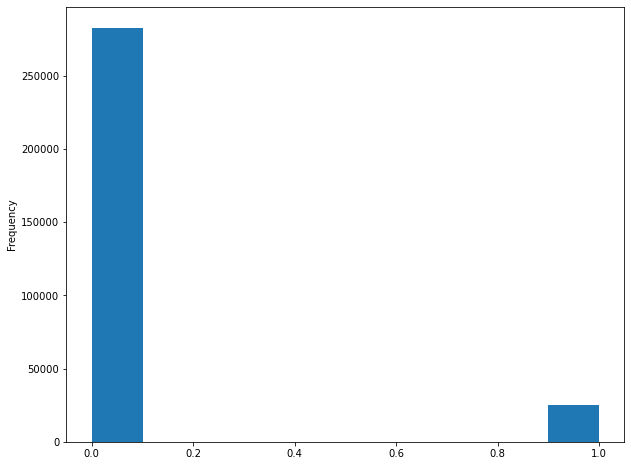

In [6]:
plt.figure(figsize = (10, 8))

df_application_train['TARGET'].astype(int).plot.hist()

plt.savefig('0-target-distribution-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

À partir de ces informations, nous voyons qu'il s'agit d'un problème de classe déséquilibré (http://www.chioka.in/class-imbalance-problem/). Il y a beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui n'ont pas été remboursés. Une fois que nous entrons dans des modèles d'apprentissage automatique plus sophistiqués, nous pouvons pondérer les classes (https://xgboost.readthedocs.io/en/latest/parameter.html) en fonction de leur représentation dans les données pour refléter ce déséquilibre.

## Examiner les valeurs manquantes

Ensuite, nous pouvons examiner le nombre et le pourcentage de valeurs manquantes dans chaque colonne.

In [7]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
# Missing values statistics
missing_values = missing_values_table(df_application_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

Lorsque viendra le temps de construire nos modèles d'apprentissage automatique, nous devrons remplir ces valeurs manquantes (appelées imputation). Dans des travaux ultérieurs, nous utiliserons des modèles tels que XGBoost qui peuvent gérer les valeurs manquantes sans avoir besoin d'imputation (https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase). Une autre option serait de supprimer les colonnes avec un pourcentage élevé de valeurs manquantes, bien qu'il soit impossible de savoir à l'avance si ces colonnes seront utiles à notre modèle. Par conséquent, nous conserverons toutes les colonnes pour l'instant.

In [9]:
missing_values

Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
...                                  ...                ...
EXT_SOURCE_2                         660                0.2
AMT_GOODS_PRICE                      278                0.1
AMT_ANNUITY                           12                0.0
CNT_FAM_MEMBERS                        2                0.0
DAYS_LAST_PHONE_CHANGE                 1                0.0

[67 rows x 2 columns]

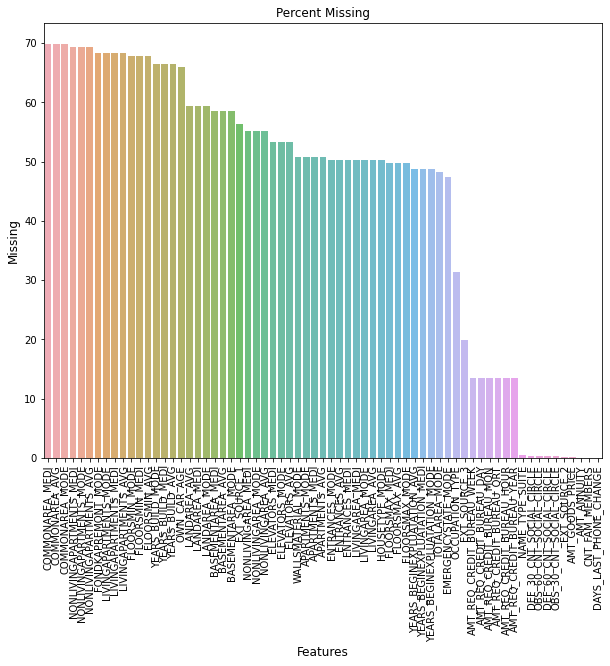

In [10]:
plt.figure(figsize = (10, 8))

sns.barplot(missing_values.index, missing_values['% of Total Values'].values, alpha=0.8)

plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)

plt.savefig('0-Missing-values-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()

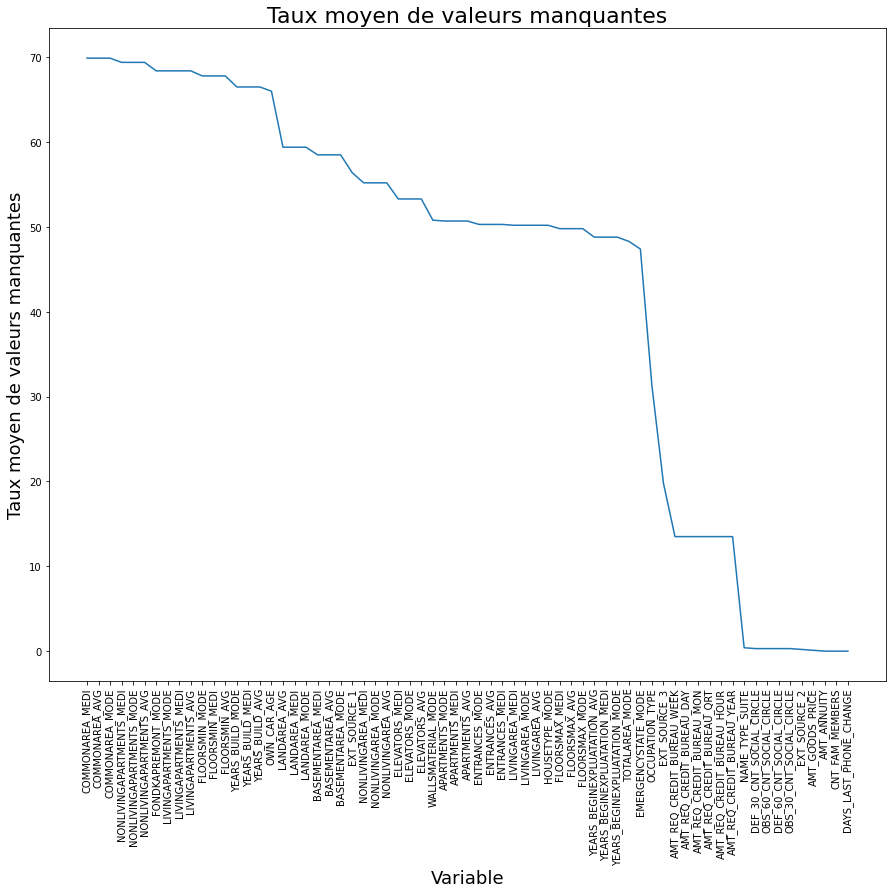

In [11]:
f, ax = plt.subplots(figsize = (15, 12))

# palette colors
sns.set_palette(sns.color_palette('dark'))

ax = sns.lineplot(data=missing_values['% of Total Values'])

# Titre et axes
ax.set(xlabel='Variable', ylabel='Taux moyen de valeurs manquantes', title='Taux moyen de valeurs manquantes')

ax.title.set_size(22)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(rotation=90)

plt.savefig('0-Taux-moyen-de-valeurs-manquantes-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

## Types des colonnes

Examinons le nombre de colonnes de chaque type de données.
- int64 et float64 sont des variables numériques (qui peuvent être discrètes ou continues https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data).
- Les colonnes d'objet contiennent des chaînes et sont des entités catégorielles (https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/).

In [12]:
# Number of each type of column
df_application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Examinons maintenant le nombre d'entrées uniques dans chacune des colonnes d'objet (catégorielles).

In [13]:
# Number of unique classes in each object column
df_application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques. Nous devrons trouver un moyen de traiter ces variables catégoriques!

## Encodage des variables catégorielles

Avant d'aller plus loin, nous devons traiter des variables catégoriques embêtantes. Un modèle d'apprentissage automatique ne peut malheureusement pas traiter les variables catégorielles (à l'exception de certains modèles tels que LightGBM). Par conséquent, nous devons trouver un moyen d'encoder (représenter) ces variables sous forme de nombres avant de les transmettre au modèle.

Il existe deux façons principales de mener à bien ce processus :
- Label encoding (Codage d'étiquettes) : attribuez chaque catégorie unique dans une variable catégorielle avec un entier. Aucune nouvelle colonne n'est créée. Un exemple est illustré ci-dessous.

![LABEL-ENCODING](img/Label_encoding.png)

- One-hot encoding (Codage à chaud) : créez une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle. Chaque observation reçoit un 1 dans la colonne pour sa catégorie correspondante et un 0 dans toutes les autres nouvelles colonnes.

![ONE-HOT-ENCODING](img/One-hot_encoding.png)

Le problème avec l'encodage d'étiquettes est qu'il donne aux catégories un ordre arbitraire. La valeur attribuée à chacune des catégories est aléatoire et ne reflète aucun aspect inhérent à la catégorie. Dans l'exemple ci-dessus, le programmeur reçoit un 4 et le data scientist un 1, mais si nous refaisons le même processus, les étiquettes pourraient être inversées ou complètement différentes. L'affectation réelle des entiers est arbitraire. Par conséquent, lorsque nous effectuons un codage d'étiquettes, le modèle peut utiliser la valeur relative de la fonctionnalité (par exemple programmeur = 4 et data scientist = 1) pour attribuer des poids qui ne sont pas ce que nous voulons. Si nous n'avons que deux valeurs uniques pour une variable catégorielle (telle que Mâle/Femelle), alors l'encodage d'étiquette est correct, mais pour plus de 2 catégories uniques, l'encodage à chaud est l'option sûre.

Il y a un débat sur les mérites relatifs de ces approches, et certains modèles peuvent traiter des variables catégorielles codées par étiquette sans problème. Voici une bonne discussion sur Stack Overflow (https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor). Je pense (et ce n'est qu'une opinion personnelle) que pour les variables catégorielles avec de nombreuses classes, l'encodage à chaud est l'approche la plus sûre car il n'impose pas de valeurs arbitraires aux catégories. Le seul inconvénient de l'encodage à chaud est que le nombre de fonctionnalités (dimensions des données) peut exploser avec des variables catégorielles avec de nombreuses catégories. Pour faire face à cela, nous pouvons effectuer un codage à chaud suivi d'une ACP (http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) ou d'autres méthodes de réduction de la dimensionnalité (https://www.analyticsvidhya.com/blog/2015/07/dimension-reduction-methods/) pour réduire le nombre de dimensions (tout en essayant de préserver les informations).

Dans ce bloc-notes, nous utiliserons l'encodage d'étiquettes pour toutes les variables catégorielles avec seulement 2 catégories et l'encodage à chaud pour toutes les variables catégorielles avec plus de 2 catégories. Ce processus devra peut-être changer à mesure que nous avancerons dans le projet, mais pour l'instant, nous verrons où cela nous mènera. (Nous n'utiliserons pas non plus de réduction de dimensionnalité dans ce bloc-notes, mais nous explorerons dans les itérations futures).

## Label Encoding and One-Hot Encoding¶

Implémentons la politique décrite ci-dessus :
- pour toute variable catégorielle (dtype == objet) avec 2 catégories uniques, nous utiliserons le label encoding,
- pour toute variable catégorielle avec plus de 2 catégories uniques, nous utiliserons le one-hot encoding.

Pour le label encoding, nous utilisons le LabelEncoder Scikit-Learn.

In [14]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df_application_train:
    if df_application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_application_train[col])
            # Transform both training and testing data
            df_application_train[col] = le.transform(df_application_train[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


Pour le One-Hot encoding, la fonction pandas get_dummies(df).

In [15]:
print('Training Features shape before one-hot encoding: ', df_application_train.shape)

Training Features shape before one-hot encoding:  (307511, 122)


In [16]:
# one-hot encoding of categorical variables
df_application_train = pd.get_dummies(df_application_train)
# df_application_test = pd.get_dummies(df_application_test)

print('Training Features shape after one-hot encoding: ', df_application_train.shape)
# print('Training Features shape: ', df_application_test.shape)

Training Features shape after one-hot encoding:  (307511, 243)


## Alignement des données de train et de test

Il doit y avoir les mêmes caractéristiques (colonnes) dans les données d'entraînement et de test. L'encodage à chaud a créé plus de colonnes dans les données d'apprentissage car il y avait des variables catégorielles avec des catégories non représentées dans les données de test. Pour supprimer les colonnes des données d'entraînement qui ne figurent pas dans les données de test, nous devons aligner les trames de données. Tout d'abord, nous extrayons la colonne cible des données d'entraînement (car ce n'est pas dans les données de test, mais nous devons conserver ces informations). Lorsque nous faisons l'alignement, nous devons nous assurer de définir axis = 1 pour aligner les trames de données en fonction des colonnes et non des lignes!

In [17]:
# train_labels = df_application_train['TARGET']

# # Align the training and testing data, keep only columns present in both dataframes
# df_application_train, df_application_test = df_application_train.align(df_application_test, join = 'inner', axis = 1)

# # Add the target back in
# df_application_train['TARGET'] = train_labels

# print('Training Features shape: ', df_application_train.shape)
# print('Testing Features shape: ', df_application_test.shape)

Les ensembles de données de formation et de test ont désormais les mêmes fonctionnalités que celles requises pour l'apprentissage automatique. Le nombre de fonctionnalités a considérablement augmenté en raison de l'encodage à chaud. À un moment donné, nous voudrons probablement essayer la réduction de la dimensionnalité (suppression des entités qui ne sont pas pertinentes) (https://en.wikipedia.org/wiki/Dimensionality_reduction) pour réduire la taille des jeux de données.

## Anomalies

Un problème que nous voulons toujours surveiller lorsque nous faisons de l'AED (Analyse Exploratoire de Données) est les anomalies dans les données. Ceux-ci peuvent être dus à des nombres mal saisis, à des erreurs dans l'équipement de mesure, ou ils peuvent être des mesures valides mais extrêmes. Une façon de soutenir quantitativement les anomalies consiste à examiner les statistiques d'une colonne à l'aide de la méthode describe. Les chiffres de la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons mutliple par -1 et diviser par le nombre de jours dans une année:

In [18]:
(df_application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Ces âges semblent raisonnables. Il n'y a pas de valeurs aberrantes pour l'âge, que ce soit sur le haut ou le bas de gamme. Qu'en est-il des jours d'emploi?

In [19]:
df_application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Cela n'a pas l'air correct! La valeur maximale (en plus d'être positive) est d'environ 1000 ans!

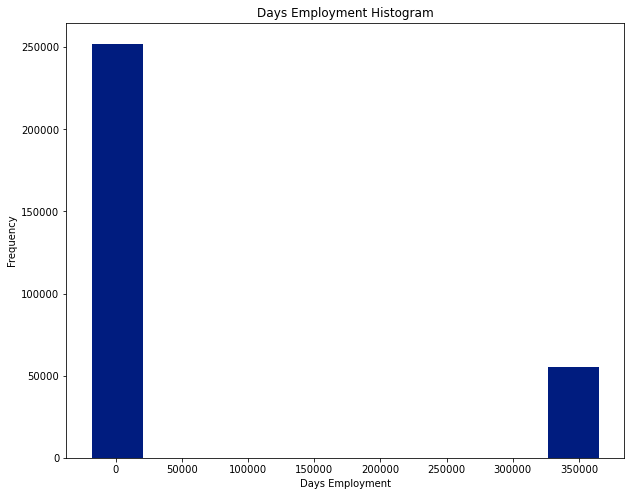

In [20]:
plt.figure(figsize = (10, 8))

df_application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

plt.savefig('0-days-employed-distribution-init-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [21]:
anom = df_application_train[df_application_train['DAYS_EMPLOYED'] == 365243]
non_anom = df_application_train[df_application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Eh bien, c'est extrêmement intéressant! Il s'avère que les anomalies ont un taux de défaut plus faible.

La gestion des anomalies dépend de la situation exacte, sans règles définies. L'une des approches les plus sûres consiste simplement à définir les anomalies sur une valeur manquante, puis à les faire remplir (à l'aide de l'imputation) avant l'apprentissage automatique. Dans ce cas, puisque toutes les anomalies ont exactement la même valeur, nous voulons les remplir avec la même valeur au cas où tous ces prêts partagent quelque chose en commun. Les valeurs anormales semblent avoir une certaine importance, nous voulons donc dire au modèle d'apprentissage automatique si nous avons effectivement rempli ces valeurs. Comme solution, nous allons remplir les valeurs anormales avec pas un nombre (np.nan), puis créer une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.

There are 55374 anomalies in the train data out of 307511 entries


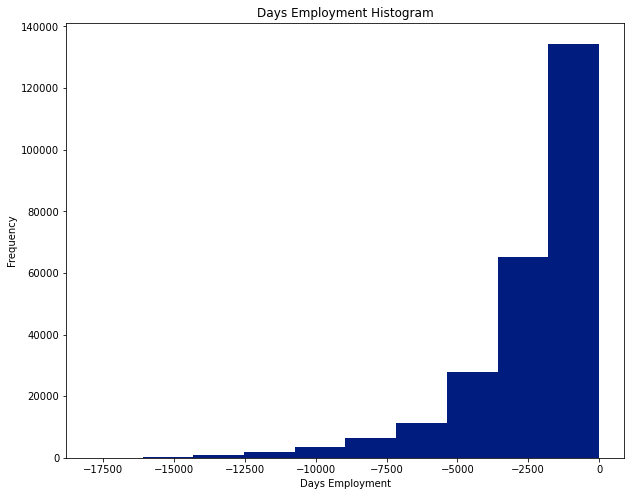

In [22]:
# Create an anomalous flag column
df_application_train['DAYS_EMPLOYED_ANOM'] = df_application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df_application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the train data out of %d entries' % (df_application_train["DAYS_EMPLOYED_ANOM"].sum(), len(df_application_train)))

plt.figure(figsize = (10, 8))

df_application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

plt.savefig('0-days-employed-distribution-after-correction-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

La distribution semble être beaucoup plus conforme à ce à quoi nous nous attendions, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine anormales (car nous devrons remplir les nans avec une certaine valeur, probablement la médiane de la colonne). Les autres colonnes avec DAYS dans le cadre de données semblent être à peu près ce que nous attendons sans valeurs aberrantes évidentes.

Comme une note extrêmement importante, tout ce que nous faisons aux données d'entraînement, nous devons également le faire aux données de test. Assurons-nous de créer la nouvelle colonne et de remplir la colonne existante avec np.nan dans les données de test.

In [23]:
# df_application_test['DAYS_EMPLOYED_ANOM'] = df_application_test["DAYS_EMPLOYED"] == 365243
# df_application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# print('There are %d anomalies in the test data out of %d entries' % (df_application_test["DAYS_EMPLOYED_ANOM"].sum(), len(df_application_test)))

## Corrélations

Maintenant que nous avons traité les variables catégorielles et les valeurs aberrantes, continuons avec l'EDA. Une façon d'essayer de comprendre les données consiste à rechercher des corrélations entre les fonctionnalités et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible à l'aide de la méthode.corr dataframe.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la « pertinence » d'une caractéristique, mais il nous donne une idée des relations possibles au sein des données.

Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :
- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

In [24]:
# Find correlations with the target and sort
correlations = df_application_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [25]:
df_application_train[correlations.tail(15).index].corr()

OCCUPATION_TYPE_Laborers  \
OCCUPATION_TYPE_Laborers                                           1.000000   
FLAG_DOCUMENT_3                                                    0.078676   
REG_CITY_NOT_LIVE_CITY                                             0.020013   
FLAG_EMP_PHONE                                                     0.219149   
NAME_EDUCATION_TYPE_Secondary / secondary special                  0.132427   
REG_CITY_NOT_WORK_CITY                                             0.114263   
DAYS_ID_PUBLISH                                                    0.043492   
CODE_GENDER_M                                                      0.235741   
DAYS_LAST_PHONE_CHANGE                                             0.002242   
NAME_INCOME_TYPE_Working                                           0.204414   
REGION_RATING_CLIENT                                               0.011683   
REGION_RATING_CLIENT_W_CITY                                        0.011690   
DAYS_EMPLOYED                                                     -0.009049   
DAYS_BIRTH                                                         0.142519   
TARGET                                                             0.043019   

                                                   FLAG_DOCUMENT_3  \
OCCUPATION_TYPE_Laborers                                  0.078676   
FLAG_DOCUMENT_3                                           1.000000   
REG_CITY_NOT_LIVE_CITY                                    0.003117   
FLAG_EMP_PHONE                                            0.248534   
NAME_EDUCATION_TYPE_Secondary / secondary special         0.060650   
REG_CITY_NOT_WORK_CITY                                    0.056275   
DAYS_ID_PUBLISH                                           0.050309   
CODE_GENDER_M                                            -0.087258   
DAYS_LAST_PHONE_CHANGE                                   -0.061760   
NAME_INCOME_TYPE_Working                                  0.164231   
REGION_RATING_CLIENT                                      0.062528   
REGION_RATING_CLIENT_W_CITY                               0.067083   
DAYS_EMPLOYED                                            -0.047286   
DAYS_BIRTH                                                0.109666   
TARGET                                                    0.044346   

                                                   REG_CITY_NOT_LIVE_CITY  \
OCCUPATION_TYPE_Laborers                                         0.020013   
FLAG_DOCUMENT_3                                                  0.003117   
REG_CITY_NOT_LIVE_CITY                                           1.000000   
FLAG_EMP_PHONE                                                   0.092166   
NAME_EDUCATION_TYPE_Secondary / secondary special               -0.022009   
REG_CITY_NOT_WORK_CITY                                           0.440409   
DAYS_ID_PUBLISH                                                  0.076326   
CODE_GENDER_M                                                    0.048257   
DAYS_LAST_PHONE_CHANGE                                           0.054183   
NAME_INCOME_TYPE_Working                                         0.032899   
REGION_RATING_CLIENT                                             0.035741   
REGION_RATING_CLIENT_W_CITY                                      0.045669   
DAYS_EMPLOYED                                                    0.114101   
DAYS_BIRTH                                                       0.180382   
TARGET                                                           0.044395   

                                                   FLAG_EMP_PHONE  \
OCCUPATION_TYPE_Laborers                                 0.219149   
FLAG_DOCUMENT_3                                          0.248534   
REG_CITY_NOT_LIVE_CITY                                   0.092166   
FLAG_EMP_PHONE                                           1.000000   
NAME_EDUCATION_TYPE_Secondary / secondary special       -0.107785   
REG_CITY_NOT_WORK_

In [26]:
# plt.figure(figsize = (15, 12))

# # Heatmap of correlations
# sns.heatmap(df_application_train[correlations.tail(15).index].corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6, linewidths=.5)
# plt.title('Correlation Heatmap - Les plus corrélés positivement');

# plt.savefig('0-heatmap-most-positive-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [27]:
# plt.figure(figsize = (15, 12))

# # Heatmap of correlations
# sns.heatmap(df_application_train[correlations.head(15).index].corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6, linewidths=.5)
# plt.title('Correlation Heatmap - Les plus corrélés négativement');

# plt.savefig('0-heatmap-most-negative-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

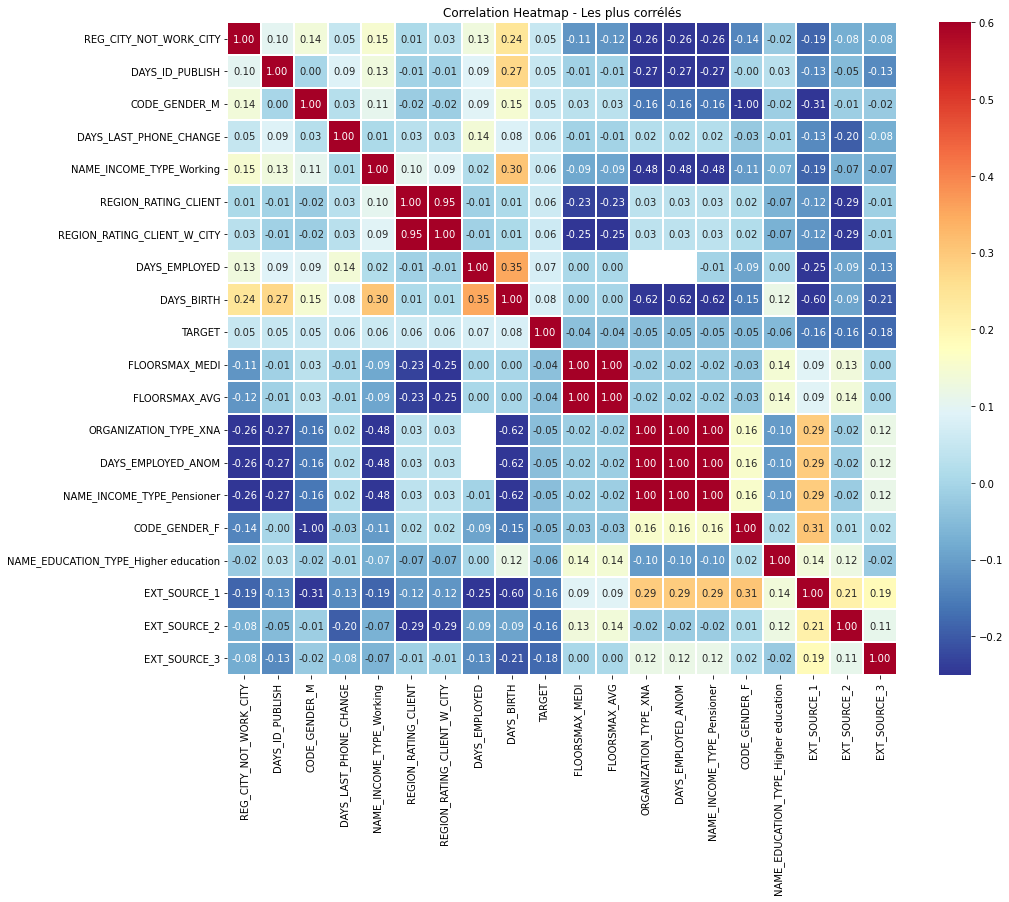

In [28]:
plt.figure(figsize = (15, 12))

# Heatmap of correlations
top_positive = list(correlations.tail(10).index)
top_negative = list(correlations.head(10).index)
top_negative.reverse()

sns.heatmap(df_application_train[top_positive + top_negative].corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6, linewidths=.3, fmt=".2f")
plt.title('Correlation Heatmap - Les plus corrélés');

plt.savefig('0-heatmap-most-correlated-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

Jetons un coup d'œil à certaines des corrélations les plus significatives: la variable DAYS_BIRTH est la corrélation la plus positive. (sauf pour TARGET car la corrélation d'une variable avec elle-même est toujours 1 !)

En regardant la documentation, DAYS_BIRTH est l'âge en jours du client au moment du prêt en jours négatifs (pour une raison quelconque!). La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie qu'à mesure que le client vieillit, il est moins susceptible de faire défaut sur son prêt (c'est-à-dire la cible == 0). C'est un peu déroutant, donc nous allons prendre la valeur absolue de la fonctionnalité et ensuite la corrélation sera négative.

## Effet de l'âge sur le remboursement

In [29]:
# Trouver la corrélation des jours positifs depuis la naissance et la cible
df_application_train['DAYS_BIRTH'] = abs(df_application_train['DAYS_BIRTH'])

df_application_train['DAYS_BIRTH'].corr(df_application_train['TARGET'])

-0.07823930830984513

À mesure que le client vieillit, il existe une relation linéaire négative avec la cible, ce qui signifie qu'à mesure que les clients vieillissent, ils ont tendance à rembourser leurs prêts à temps plus souvent. Commençons par examiner cette variable. Tout d'abord, nous pouvons faire un histogramme de l'âge. Nous allons mettre l'axe des x dans les années pour rendre l'intrigue un peu plus compréhensible.

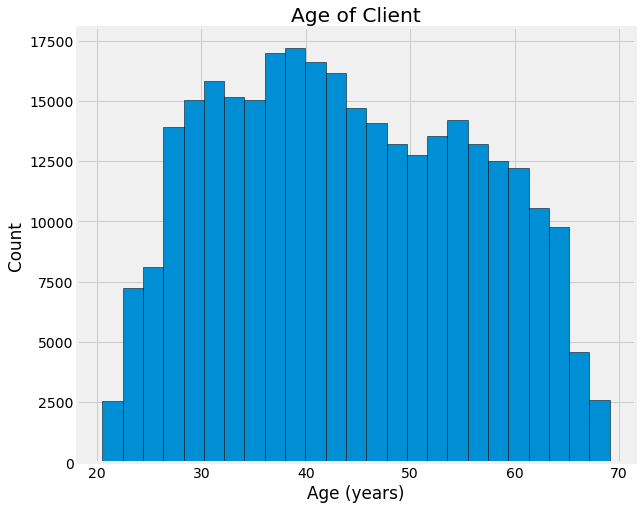

In [30]:
plt.figure(figsize = (10, 8))

# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(df_application_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

plt.savefig('0-age-client-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

En soi, la répartition de l'âge ne nous dit pas grand-chose d'autre que le fait qu'il n'y a pas de valeurs aberrantes car tous les âges sont raisonnables. Pour visualiser l'effet de l'âge sur la cible, nous allons ensuite faire un diagramme d'estimation de la densité du noyau (KDE) (https://en.wikipedia.org/wiki/Kernel_density_estimation) coloré par la valeur de la cible. Un diagramme d'estimation de la densité du noyau montre la distribution d'une seule variable (https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement un gaussien, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer une seule courbe lisse). Nous utiliserons le kdeplot seaborn pour ce graphique.

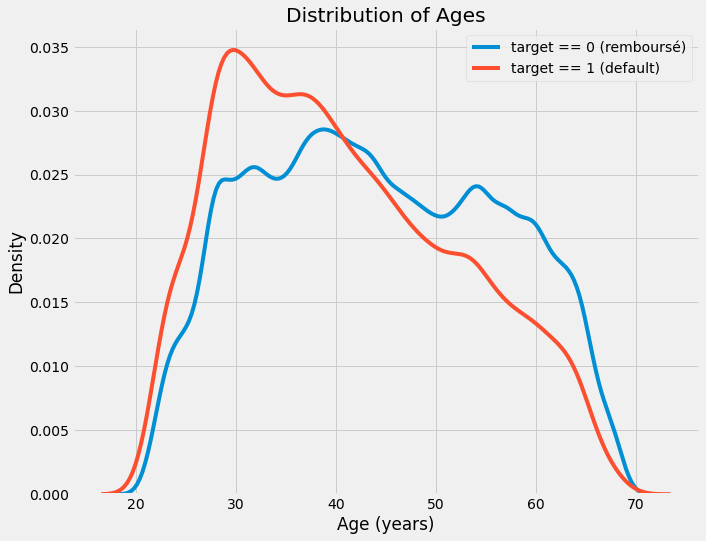

In [31]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0 (remboursé)')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1 (default)')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

plt.savefig('0-ages-distribution-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

plt.legend()

La courbe TARGET == 1 s'incline vers l'extrémité la plus jeune de la plage. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Regardons cette relation d'une autre manière: l'incapacité moyenne à rembourser les prêts par tranche d'âge.

Pour faire ce graphique, nous avons d'abord coupé la catégorie d'âge en bacs de 5 ans chacun. Ensuite, pour chaque bac, nous calculons la valeur moyenne de la cible, qui nous indique le ratio des prêts qui n'ont pas été remboursés dans chaque catégorie d'âge.

In [32]:
# Age information into a separate dataframe
age_data = df_application_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [33]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

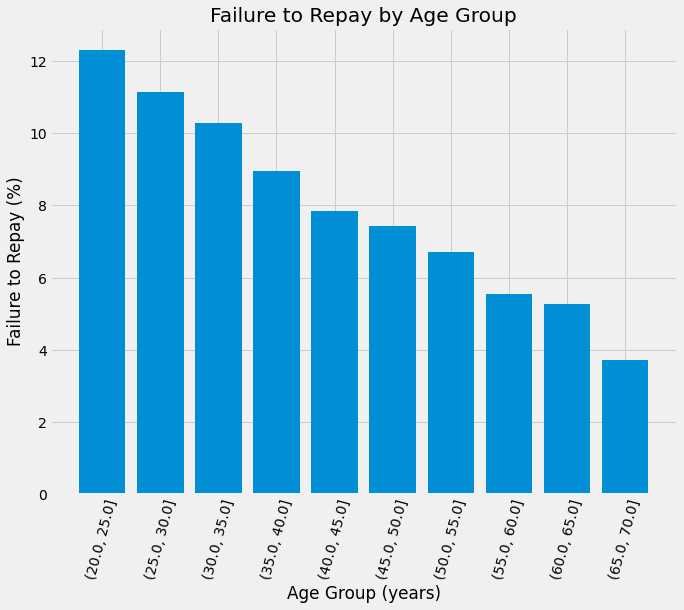

In [34]:
plt.figure(figsize = (10, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

plt.savefig('0-failure-to-repay-by-age-group-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

Il y a une tendance claire: les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt! Le taux de non-remboursement est supérieur à 10 % pour les trois groupes d'âge les plus jeunes et inférieur à 5 % pour le groupe d'âge le plus âgé.

Il s'agit d'informations qui pourraient être directement utilisées par la banque : étant donné que les jeunes clients sont moins susceptibles de rembourser le prêt, ils devraient peut-être recevoir plus de conseils ou de conseils de planification financière. Cela ne signifie pas que la banque devrait discriminer les clients plus jeunes, mais il serait judicieux de prendre des mesures de précaution pour aider les jeunes clients à payer à temps.

## Sources externes

Les 3 variables ayant les corrélations négatives les plus fortes avec la cible sont EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3. Selon la documentation, ces caractéristiques représentent un « score normalisé à partir d'une source de données externe ». Je ne suis pas sûr de ce que cela signifie exactement, mais il peut s'agir d'une sorte de notation de crédit cumulative établie à l'aide de nombreuses sources de données.

Jetons un coup d'œil à ces variables. Tout d'abord, nous pouvons montrer les corrélations des caractéristiques EXT_SOURCE avec la cible et entre elles.

In [35]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = df_application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

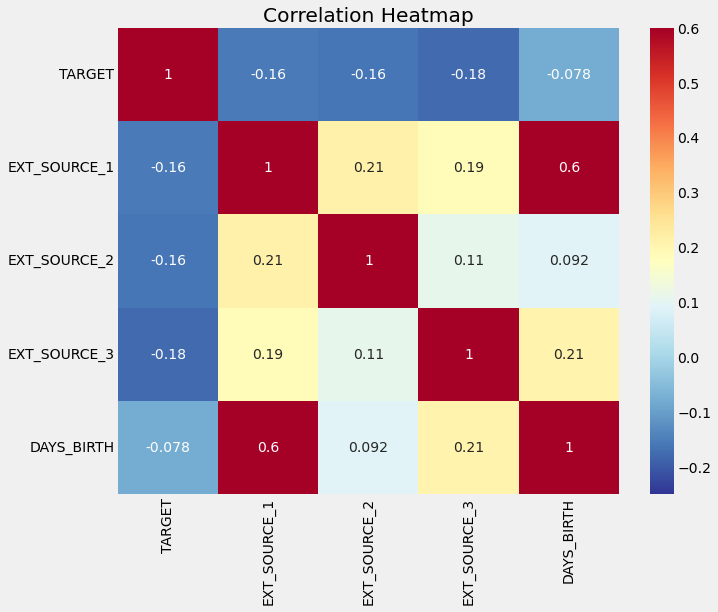

In [36]:
plt.figure(figsize = (10, 8))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

plt.savefig('0-heatmap-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique qu'à mesure que la valeur du EXT_SOURCE augmente, le client est plus susceptible de rembourser le prêt. Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1 ce qui indique que l'un des facteurs de ce score est peut-être l'âge du client.

Ensuite, nous pouvons examiner la distribution de chacune de ces caractéristiques colorées par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

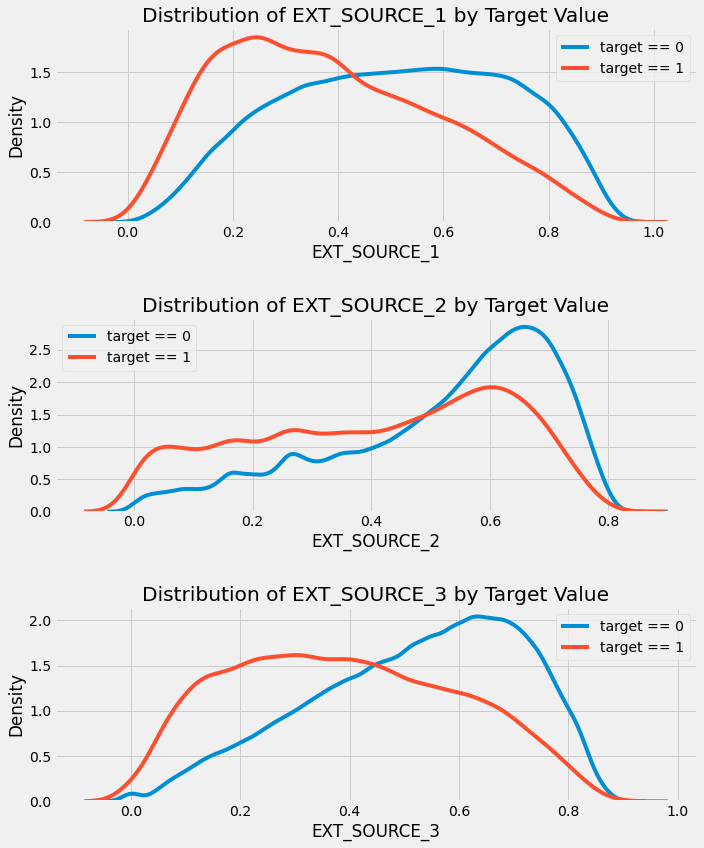

In [37]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
    plt.legend()

plt.tight_layout(h_pad = 2.5)

plt.savefig('0-distribution-features-by-target-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

EXT_SOURCE_3 affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a un certain rapport avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, ils sont tous considérés comme très faibles, mais ces variables seront toujours utiles pour un modèle d'apprentissage automatique afin de prédire si un demandeur remboursera ou non un prêt à temps.

## Pairs Plot

En tant que graphique exploratoire final, nous pouvons faire un pairplot des variables EXT_SOURCE et de la variable DAYS_BIRTH. Le pairplot est un excellent outil d'exploration car il nous permet de voir les relations entre plusieurs paires de variables ainsi que les distributions de variables uniques. Ici, nous utilisons la bibliothèque de visualisation seaborn et la fonction PairGrid pour créer un diagramme de paires avec :
- des nuages de points sur le triangle supérieur,
- des histogrammes sur la diagonale,
- des diagrammes de densité de noyau 2D et des coefficients de corrélation sur le triangle inférieur.

No handles with labels found to put in legend.


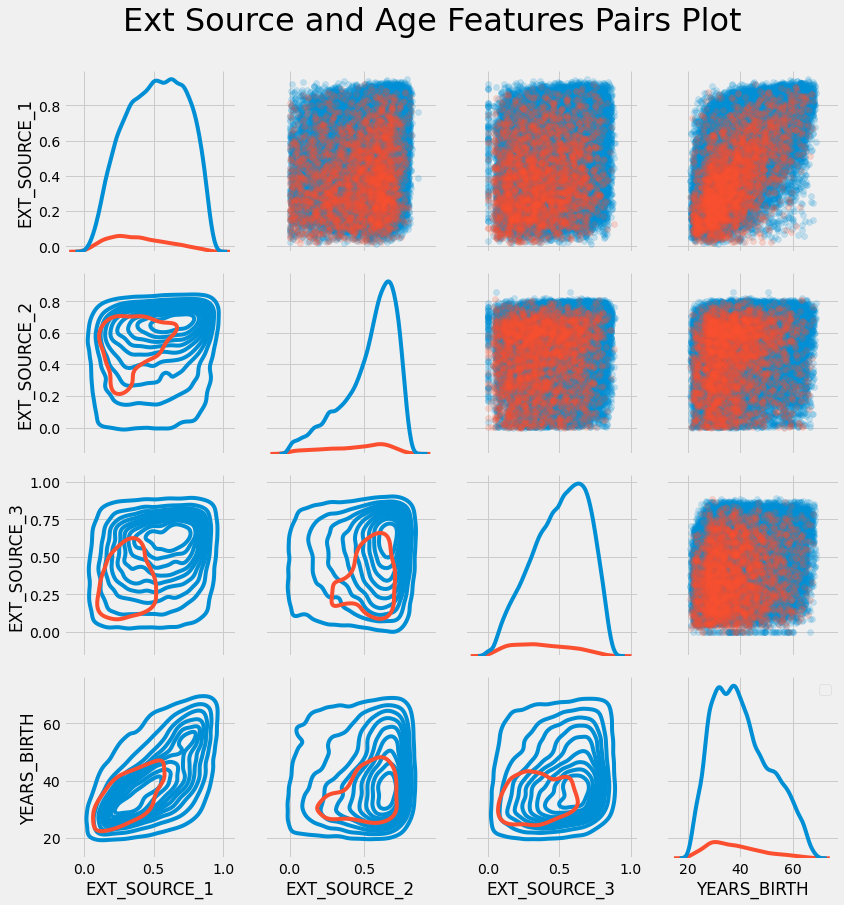

In [38]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

plt.legend()

plt.savefig('0-pairplots-300dpi.png', dpi=300, bbox_inches='tight', pad_inches=0)

Dans ce graphique, le rouge indique les prêts qui n'ont pas été remboursés et le bleu sont les prêts qui sont payés. Nous pouvons voir les différentes relations au sein des données. Il semble y avoir une relation linéaire positive modérée entre le EXT_SOURCE_1 et le DAYS_BIRTH (ou de manière équivalente YEARS_BIRTH), ce qui indique que cette caractéristique peut tenir compte de l'âge du client.

# Modélisation initiale

- Séparer les données en deux bases train/test (à partir du fichier train.csv). Le fichier test.csv ne peut pas être utilisé car il ne contient pas la target (dans le contexte du concours kaggle)
- Entraîner plusieurs modèles de classification : approche naïve (DummyClassifier), régression logistique, arbre de décision, random forests, xgboost/lightgbm/catboost
- Calculer les métriques sur les bases de train/test : recall, F1-score, AUC, matrice de confusion
- Cross-validation avec GridSearchCV (pour la recherche des hyper-paramètres, scoring=roc auc)
- Si jamais la recherche est trop longue, prendre un sous-échantillon du dataset.
- Créer une fonction regroupant la recherche des hyperparamètres et le calcul de performance
- Récapitulatif des performances (faire un tableau récapitulatif des performances)
- Cette étape est validée si la majorité des ROC AUC > 0.6 ou > 0.72, recall  et F1 score<= 0.1. Aussi les performances doivent être croissantes en fonction de la compléxité des modèles.

## Préparation des données

In [39]:
print('Train data shape: ', df_application_train.shape)
df_application_train.head()

Train data shape:  (307511, 244)


SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002       1                   0             0                1   
1      100003       0                   0             0                0   
2      100004       0                   1             1                1   
3      100006       0                   0             0                1   
4      100007       0                   0             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ...  WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0  ...                         0                         0   
1  ...                         1                         0   
2  ...                         0                         0   
3  ...                         0                         0   
4  ...                         0                         0   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                         0                                1   
1                         0                                0   
2                         0                                0   
3                         0                                0   
4                         0                                0   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  \
0                          0                       1                        0   
1                          0                       1                        0   
2                          0                       0                        0   
3                          0                       0                        0   
4                          0                       0                        0   

   DAYS_EMPLOYED_ANOM  
0               False  
1               False  
2               False  
3               False  
4               False  

[5 rows x 244 columns]

Pour obtenir une ligne de base, nous utiliserons toutes les fonctionnalités après avoir codé les variables catégorielles. Nous allons prétraiter les données en remplissant les valeurs manquantes (imputation) et en normalisant la plage des fonctionnalités (mise à l'échelle des fonctionnalités). Le code suivant effectue ces deux étapes de prétraitement.

In [40]:
from collections import Counter

print('TARGET shape %s' % Counter(df_application_train['TARGET']))

TARGET shape Counter({0: 282686, 1: 24825})


### Imputation

In [41]:
df_application_train.isna().mean().value_counts()

0.000000    182
0.135016      6
0.003320      4
0.532960      3
0.503488      3
0.551792      3
0.694330      3
0.501933      3
0.683550      3
0.593767      3
0.678486      3
0.497608      3
0.698723      3
0.664978      3
0.487810      3
0.585160      3
0.507497      3
0.000039      1
0.180072      1
0.198253      1
0.002146      1
0.563811      1
0.000007      1
0.482685      1
0.659908      1
0.000003      1
0.000904      1
dtype: int64

In [42]:
# if modelization is too long, take sample of dataset
df_application_train_splitable = df_application_train.sample(frac=0.2, replace=False, random_state=42)

# if not too long or for computing all dataset
# df_application_train_splitable = df_application_train.copy()

In [43]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

target = df_application_train_splitable['TARGET']

features = df_application_train_splitable.drop(columns = ['TARGET'])

# Feature names
feature_names = list(features.columns)

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(features)

# Transform both training and testing data
features = imputer.transform(features)

# Repeat with the scaler
scaler.fit(features)
features = scaler.transform(features)

print('Training data shape: ', features.shape)

Training data shape:  (61502, 243)


In [44]:
np.count_nonzero(np.isnan(features))

0

### Séparer les données en train et test

In [45]:
from sklearn.model_selection import train_test_split

# Séparer X et y
# Séparer les données en train et test 80/20 avec train test split de sklearn
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size = 0.2, random_state = 0)

In [46]:
X_train.shape

(49201, 243)

In [47]:
X_test.shape

(12301, 243)

In [48]:
y_train.shape

(49201,)

### Santardiser les données d'entraînement

In [49]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler().fit(X_train)
X_scaled = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

## Baseline

Pour une base de référence naïve, nous pourrions deviner la même valeur pour tous les exemples de l'ensemble de tests. On nous demande de prédire la probabilité de ne pas rembourser le prêt, donc si nous ne sommes pas du tout sûrs, nous devinerions 0,5 pour toutes les observations sur l'ensemble de test. Cela nous permettra d'obtenir une aire caractéristique de fonctionnement du récepteur sous la courbe (AUC ROC) de 0,5 dans la compétition (deviner au hasard une tâche de classification donnera un score de 0,5).

Puisque nous savons déjà quel score nous allons obtenir, nous n'avons pas vraiment besoin de faire une supposition de base naïve. Utilisons un modèle légèrement plus sophistiqué pour notre base de référence réelle : la régression logistique.

### Logistic Regression Implementation

In [50]:
from sklearn.linear_model import LogisticRegression

model_name = 'LogisticRegression'

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_scaled, y_train)

LogisticRegression(C=0.0001)

Maintenant que le modèle a été formé, nous pouvons l'utiliser pour faire des prédictions. Nous voulons prédire les probabilités de ne pas payer un prêt, nous utilisons donc la méthode model predict.proba. Cela renvoie un tableau m x 2 où m est le nombre d'observations. La première colonne est la probabilité que la cible soit 0 et la deuxième colonne est la probabilité que la cible soit 1 (donc pour une seule ligne, les deux colonnes doivent être additionnées à 1). Nous voulons la probabilité que le prêt ne soit pas remboursé, nous sélectionnerons donc la deuxième colonne.

Le code suivant effectue les prédictions et sélectionne la colonne correcte.

In [51]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(X_test_std)[:, 1]

Les prédictions représentent une probabilité comprise entre 0 et 1 que le prêt ne sera pas remboursé. Si nous utilisions ces prédictions pour classer les demandeurs, nous pourrions établir un seuil de probabilité pour déterminer qu'un prêt est risqué.

In [52]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# y_pred contains probability, need to choose class depending on threshold
# take 0.5 for now :
threshold = 0.5

# if prediction is 0.5, client has same chance of repaying than defaulting the loan
# from bank perspective, it's better not to take the chance to lose money, so don't loan = class 1
# if pred < 0.5, class 0 the loan was repaid on time
# else pred >= 0.5, class 1 the client had payment difficulties
log_reg_pred_binarized = np.where(np.array(log_reg_pred) >= threshold, 1, 0)

# calculate recall : tp / (tp + fn)
recall = recall_score(y_test, log_reg_pred_binarized)

# calculate F1 score : 2 * (precision * recall) / (precision + recall)
f1 = f1_score(y_test, log_reg_pred_binarized)

# calculate ROC_AUC
roc_auc = roc_auc_score(y_test, log_reg_pred)

print('\nModel: \t\t', model_name,
        '\nRecall: \t', "{:.2f}".format(recall),
        '\nF1 score: \t', "{:.2f}".format(f1),
        '\nROC_AUC: \t', "{:.2f}".format(roc_auc),
        '\n')

print('\n', confusion_matrix(y_test, log_reg_pred_binarized))
print('\n', classification_report(y_test, log_reg_pred_binarized))


Model: 		 LogisticRegression 
Recall: 	 0.00 
F1 score: 	 0.00 
ROC_AUC: 	 0.72 


 [[11328     0]
 [  973     0]]

               precision    recall  f1-score   support

           0       0.92      1.00      0.96     11328
           1       0.00      0.00      0.00       973

    accuracy                           0.92     12301
   macro avg       0.46      0.50      0.48     12301
weighted avg       0.85      0.92      0.88     12301



Changer le seuil de décision peut sembler attrayant, mais conduira évidemment à une augmentation drastique des faux positifs (bien que les FP ne soient peut-être pas aussi mauvais que les FN dans le cas d'un diagnostic médical, si les tests ne sont pas prohibitifs).

## Automatisation

### Objets

In [53]:
# scores : recall, F1-score, AUC, matrice de confusion
initial_data_models_scores = {'Step': [], 'Model': [], 'best_params': [], 'recall': [], 'F1-score': [], 'ROC_AUC': [], 'execution_time': [], 'mean_fit_time': [], 'mean_score_time': [], 'predictions': []}

### Méthodes

In [54]:
def computeScoresPredictions(model_name, best_params, y_test, y_pred, step, df_scores, execution_time, mean_fit_time, mean_score_time):
        
    # y_pred contains probability, need to choose class depending on threshold
    # take 0.5 for now :
    threshold = 0.5
    
    # if prediction is 0.5, client has same chance of repaying than defaulting the loan
    # from bank perspective, it's better not to take the chance to lose money, so don't loan = class 1
    # if pred < 0.5, class 0 the loan was repaid on time
    # else pred >= 0.5, class 1 the client had payment difficulties
    y_pred_binarized = np.where(np.array(y_pred) >= threshold, 1, 0)
    
    # calculate recall : tp / (tp + fn)
    recall = recall_score(y_test, y_pred_binarized)

    # calculate F1 score : 2 * (precision * recall) / (precision + recall)
    f1 = f1_score(y_test, y_pred_binarized)

    # calculate ROC_AUC
    roc_auc = roc_auc_score(y_test, y_pred)
    
    print('\nStep: \t\t\t', step,
            '\nModel: \t\t\t', model_name,
            '\nbest_params: \t\t', best_params,
            '\nRecall: \t\t', "{:.4f}".format(recall),
            '\nF1 score: \t\t', "{:.4f}".format(f1),
            '\nROC_AUC: \t\t', "{:.4f}".format(roc_auc),
            '\nExecution time: \t', "{:.4f}s".format(execution_time), "({:}m ".format(int(execution_time / 60)), "{:.2f}s)".format(round((execution_time - (60 * int(execution_time / 60))) % 60, 2)),
            '\nMean fit time: \t', "{:.2f}s".format(mean_fit_time), "({:}m ".format(int(mean_fit_time / 60)), "{:.2f}s)".format(round((mean_fit_time - (60 * int(mean_fit_time / 60))) % 60, 2)),
            '\nMean score time: ', "{:.2f}s".format(mean_score_time), "({:}m ".format(int(mean_score_time / 60)), "{:.2f}s)".format(round((mean_score_time - (60 * int(mean_score_time / 60))) % 60, 2)),
            '\n')
    
    print('\n', confusion_matrix(y_test, y_pred_binarized))
    print('\n', classification_report(y_test, y_pred_binarized))
    
    # add new row to end of DataFrame
    df_scores.loc[len(df_scores.index)] = [step, model_name, best_params, recall, f1, roc_auc, execution_time, mean_fit_time, mean_score_time, y_pred]

In [55]:
import time

def computeGridSearchCVOneClassifierOneY(model, model_name, param_grid, n_folds, scoring, X_train, X_test, y_train, y_test, step, df_scores, n_jobs):
    
    startTime = time.time()
    
    # GridSearchCV
    gscv = GridSearchCV(model, param_grid, cv=n_folds, scoring=scoring, n_jobs=n_jobs)
    
    # Lancer l'entraînement du model pour la variable
    gscv.fit(X_train, y_train)
    
    # Score du model sur la variable
    score_train = gscv.score(X_train, y_train)
    
    # Calculer les performances sur la base de test avec score
    score_test = gscv.score(X_test, y_test)

    # Prédictions sur les variables de test
    # Now that the model has been trained, we can use it to make predictions.
    # We want to predict the probabilities of not paying a loan, so we use the model predict.proba method.
    # This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1).
    # We want the probability the loan is not repaid, so we will select the second column.
    y_pred_proba = gscv.predict_proba(X_test)[:, 1]
    # y_pred = gscv.predict(X_test)
    
    cv_results = gscv.cv_results_
    best_estimator = gscv.best_estimator_

    executionTime = (time.time() - startTime)
    
    # Temps d'entraînement 
    mean_fit_time = round(gscv.cv_results_['mean_fit_time'].mean() * gscv.n_splits_ * gscv.cv_results_['mean_fit_time'].shape[0], 2)    
    
    # Temps de prédiction 
    mean_score_time = round(gscv.cv_results_['mean_score_time'].mean() * gscv.n_splits_ * gscv.cv_results_['mean_fit_time'].shape[0], 2)
    
    print('Execution time in seconds: ' + str(executionTime))
    
    # Calcul des résultats
    computeScoresPredictions(model_name, best_estimator.get_params(), y_test, y_pred_proba, step, df_scores, executionTime, mean_fit_time, mean_score_time)    

    return best_estimator, y_pred_proba, cv_results

In [56]:
def gridSearchCVOneClassifierOneY(model, model_name, param_grid, n_folds, scoring, X_train, X_test, y_train, y_test, step, df_scores, n_jobs, logScale, graphics):
            
    # Résultats
    results = dict()
        
    # Entraînement, CV, sélection des meilleurs hyperparamètres, calcul des scores et prédictions
    best_estimator, y_pred, cv_results = computeGridSearchCVOneClassifierOneY(model, model_name, param_grid, n_folds, scoring, X_train, X_test, y_train, y_test, step, df_scores, n_jobs)

    # Enregistrement des résultats
    results = dict(best_estimator=best_estimator, y_pred=y_pred, cv_results=cv_results)

    # Affichage
    if graphics:
        fig, ax = plt.subplots(figsize=(15, 12))
        plt.title(step + ' - ' + model_name + ' - ' + variable_name + ' - Nuage de points valeurs réelles/prédites')
        plt.ylabel('Valeurs réelles')
        plt.xlabel('Valeurs prédites')

        if logScale:
            ax.set_xscale("log")
            ax.set_yscale("log")

        # Affichage des valeurs prédites en fonction des valeurs réelles 
        # axs[index].scatter(actual, predicted, color='coral')
        plt.scatter(y_test, y_pred, color='coral', label=model_name + ' - ' + variable_name)

        # Affichage de la diagonale entre la valeur min et la valeur max réelle
        y_test_min = y_test.min()
        y_test_max = y_test.max()
        plt.plot([y_test_min, y_test_max], [y_test_min, y_test_max], linestyle='--', color='blue', alpha=0.8, label="Diagonale entre la valeur min et la valeur max réelle")

        plt.legend(loc = 'lower right')
        plt.show()
        
    # retourne les résultats pour les multiples y de la recherche CV pour ce regresseur
    return results

In [57]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def gridSearchCVMultipleClassifiersOneY(classifiers_cv, n_folds, scoring, X_train, X_test, y_train, y_test, step, df_scores, n_jobs=None, logScale=False, graphics=False):
    
    classifiers_cv_results = classifiers_cv.copy()
    
    for model_name in classifiers_cv:
        model = classifiers_cv[model_name]['classifier']
        param_grid = classifiers_cv[model_name]['param_grid']
        
        print("Processing {} ...\n".format(model))
        
        results = gridSearchCVOneClassifierOneY(model, model_name, param_grid, n_folds, scoring, X_train, X_test, y_train, y_test, step, df_scores, n_jobs, logScale, graphics)
        classifiers_cv_results[model_name]['results'] = results
        
    return classifiers_cv_results

## Initialisation des models et des hyperparamètres

In [58]:
# import sys
# !{sys.executable} -m pip install catboost

In [59]:
df_scores = pd.DataFrame(data=initial_data_models_scores)

In [60]:
from sklearn.dummy import DummyClassifier
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import GridSearchCV

# Nombre de plis pour la CV
n_folds = 5

scoring = 'roc_auc'

step = '1 Initial'

# Préparation du dictionnaire contenant les models et leurs paramètres pour la recherche croisée    
classifiers_cv = {
    'Dummy Classifier': {
        'classifier': DummyClassifier(),
        'color': 'brown', 
        'param_grid': {}
    },
    'Logistic Regression': {
        'classifier': LogisticRegression(),
        'color': 'coral',
        'param_grid': 
            {'multi_class': ['ovr'],
             'penalty': ['l2'],
             'C': [.1, .01, .001, .0001],
             'multi_class': ['ovr'],
            }
    },
    'Decision Tree Classifier': {
        'classifier': DecisionTreeClassifier(),
        'color': 'lightblue',
        'param_grid':
            {'criterion': ['gini', 'entropy'],
             'max_depth': [9, 10, 11],
             'min_samples_leaf': [1, 2],
             'min_samples_split': [.1, .5, .8, 1],
             'splitter': ['best', 'random']}
    },
    'Random Forest Classifier': {
        'classifier': RandomForestClassifier(),
        'color': 'green',
        'param_grid':
            {'criterion': ['entropy'],
             'max_depth': [10, 15],
             'min_samples_leaf': [3, 4],
             'min_samples_split': [3, 4],
             'n_estimators': [500]}
    },
    # 'Gradient Boosting Classifier': {
    #     'classifier': GradientBoostingClassifier(),
    #     'color': 'grey',
    #     'param_grid':
    #         {'learning_rate': [.03, .05, .07],
    #          'n_estimators': [500],
    #          'max_depth': [1, 2, 3]}
    # },
    'LightGBM Classifier': {
        'classifier': lgb.LGBMClassifier(),
        'color': 'violet',
        'param_grid': # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
            {'learning_rate': [.03, .05, .07],
             'n_estimators': [500],
             'max_depth': [1, 2, 3],
             'reg_alpha': np.logspace(-4, -1, 5),
             'reg_lambda': np.logspace(-4, -1, 5)}
    },
    'XGBoost Classifier': {
        'classifier': xgb.XGBClassifier(),
        'color': 'orange',
        'param_grid': # https://xgboost.readthedocs.io/en/latest/parameter.html
            {'objective':['reg:linear'],
             'learning_rate': [.03, 0.05, .07],
             'max_depth': [5, 6, 7],
             'min_child_weight': [1, 2, 3, 4]}
    },
    'CatBoost Classifier': {
        'classifier': CatBoostClassifier(),
        'color': 'yellow',
        'param_grid': # https://medium.com/analytics-vidhya/catboost-101-fb2fdc3398f3 # https://catboost.ai/en/docs/references/training-parameters/common
            {'learning_rate': [.03, 0.05, .07],
             'depth': [5, 6, 7],
             'iterations': [10],
             'train_dir': ['crossentropy']}
    }
}

In [61]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

## Entraînements, prédictions, scoring

In [62]:
classifiers_cv_results = gridSearchCVMultipleClassifiersOneY(classifiers_cv, n_folds, scoring, X_scaled, X_test_std, y_train, y_test, step, df_scores, n_jobs=6, logScale=False, graphics=False)

Processing DummyClassifier() ...

Execution time in seconds: 2.7594897747039795

Step: 			 0 Initial 
Model: 			 Dummy Classifier 
best_params: 		 {'constant': None, 'random_state': None, 'strategy': 'prior'} 
Recall: 		 0.0000 
F1 score: 		 0.0000 
ROC_AUC: 		 0.5000 
Execution time: 	 2.7595s (0m  2.76s) 
Mean fit time: 	 0.31s (0m  0.31s) 
Mean score time:  0.01s (0m  0.01s) 


 [[11328     0]
 [  973     0]]

               precision    recall  f1-score   support

           0       0.92      1.00      0.96     11328
           1       0.00      0.00      0.00       973

    accuracy                           0.92     12301
   macro avg       0.46      0.50      0.48     12301
weighted avg       0.85      0.92      0.88     12301

Processing LogisticRegression() ...

Execution time in seconds: 5.3641297817230225

Step: 			 0 Initial 
Model: 			 Logistic Regression 
best_params: 		 {'C': 0.001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_r

## Résultats GridSearchCV numériques et graphiques

Les résultats des scores de modélisation avec CV pour la variable TARGET.

In [63]:
df_scores

Step                     Model  \
0  0 Initial          Dummy Classifier   
1  0 Initial       Logistic Regression   
2  0 Initial  Decision Tree Classifier   
3  0 Initial  Random Forest Classifier   
4  0 Initial       LightGBM Classifier   
5  0 Initial        XGBoost Classifier   
6  0 Initial       CatBoost Classifier   

                                         best_params    recall  F1-score  \
0  {'constant': None, 'random_state': None, 'stra...  0.000000  0.000000   
1  {'C': 0.001, 'class_weight': None, 'dual': Fal...  0.006166  0.012195   
2  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  0.000000  0.000000   
3  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  0.000000  0.000000   
4  {'boosting_type': 'gbdt', 'class_weight': None...  0.015416  0.029940   
5  {'objective': 'reg:linear', 'use_label_encoder...  0.014388  0.028000   
6  {'iterations': 10, 'learning_rate': 0.07, 'dep...  0.000000  0.000000   

    ROC_AUC  execution_time  mean_fit_time  mean_score_time  \
0  0.500000        2.759490           0.31             0.01   
1  0.731831        5.364130          26.38             0.23   
2  0.691500       52.889139         295.32             4.19   
3  0.731154      415.735168        1992.03            30.29   
4  0.738876      575.357862        3276.77           132.07   
5  0.735621      778.177010        4597.73             5.62   
6  0.694644       35.755430         133.05            30.07   

                                         predictions  
0  [0.08081136562264994, 0.08081136562264994, 0.0...  
1  [0.2718529797978223, 0.08796157869098979, 0.05...  
2  [0.12148010239702117, 0.13855421686746988, 0.0...  
3  [0.15928920402372373, 0.055912015986737916, 0....  
4  [0.2269374499911105, 0.076065362927037, 0.0678...  
5  [0.14767434, 0.08503602, 0.0619463, 0.09896713...  
6  [0.25961769385861094, 0.2051074946079513, 0.19...

In [64]:
import matplotlib.patches as mpatches

def displayTimesScoresComparisonForVariable(variable, df_scores_, colors, patches, yticklabels, step, filename_key):
    # graphique
    fig = plt.figure(figsize=(20, 12))

    print('Comparaison des temps d\'entraînement et de prédictions et des scores Recall/F1/ROC_AUC par modèles pour la variable {} à l\'étape {}'.format(variable, step))

    # use default palette colors
    # sns.set_palette(default_colors_palette)

    y = np.arange(len(df_scores_['Model'].index))
    width = 0.35

    fig, ax = plt.subplots(1, 4, figsize=(20,8), sharey=False, sharex=False)
    # fig.subplots_adjust(top=0.8)
    # fig.tight_layout()
    # fig.subplots_adjust(wspace=0.6)

    # Temps de Train/Test
    train = ax[0].barh(y - width/2, df_scores_['mean_fit_time'], width, color=colors, hatch="+", label='Fit time +')
    test = ax[0].barh(y + width/2, df_scores_['mean_score_time'], width, color=colors, hatch="o", label='Predict time o')
    ax[0].set_xlabel('Temps par modèle (secondes)')
    ax[0].set_title('Temps')
    ax[0].set_yticks(y)
    ax[0].set_yticklabels(yticklabels)
    ax[0].invert_yaxis()  # labels read top-to-bottom
    ax[0].legend()
    # patches_copy = patches.copy()
    # patches_copy.insert(0, mpatches.Patch(label="Fit pattern", hatch="o"))
    # patches_copy.insert(1, mpatches.Patch(label="Train pattern", hatch="+"))
    # plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", handles=patches)
    ax[0].bar_label(test, padding=3)
    ax[0].bar_label(train, padding=3)
    
    # Scores Recall
    scores1 = ax[1].barh(y, df_scores_['recall'], width, color=colors)
    ax[1].set_xlabel('Score recall par modèle')
    ax[1].set_title('Recall')
    ax[1].set_yticks(y)
    ax[1].set_yticklabels(yticklabels)
    ax[1].invert_yaxis()  # labels read top-to-bottom
    ax[1].tick_params(labelleft=False)
    # ax[1].legend(handles=patches)
    ax[1].bar_label(scores1, padding=3)
    ax[1].axvline(x=max(df_scores_['recall']), color=colors[df_scores_.loc[df_scores_['recall'] == df_scores_['recall'].max(axis=0), :].index[0]], linestyle='--')
    
    # Scores F1
    scores2 = ax[2].barh(y, df_scores_['F1-score'], width, color=colors)
    ax[2].set_xlabel('F1-score par modèle')
    ax[2].set_title('F1-score')
    ax[2].set_yticks(y)
    ax[2].set_yticklabels(yticklabels)
    ax[2].invert_yaxis()  # labels read top-to-bottom
    ax[2].tick_params(labelleft=False)
    # ax[2].legend(handles=patches)
    ax[2].bar_label(scores2, padding=3)
    ax[2].axvline(x=max(df_scores_['F1-score']), color=colors[df_scores_.loc[df_scores_['F1-score'] == df_scores_['F1-score'].max(axis=0), :].index[0]], linestyle='--')
    
    # Scores ROC_AUC
    scores3 = ax[3].barh(y, df_scores_['ROC_AUC'], width, color=colors)
    ax[3].set_xlabel('ROC_AUC par modèle')
    ax[3].set_title('ROC_AUC')
    ax[3].set_yticks(y)
    ax[3].set_yticklabels(yticklabels)
    ax[3].invert_yaxis()  # labels read top-to-bottom
    ax[3].tick_params(labelleft=False)
    # ax[3].legend(handles=patches)
    ax[3].bar_label(scores3, padding=3)
    ax[3].axvline(x=max(df_scores_['ROC_AUC']), color=colors[df_scores_.loc[df_scores_['ROC_AUC'] == df_scores_['ROC_AUC'].max(axis=0), :].index[0]], linestyle='--')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", handles=patches)
    
    fig.suptitle('Variable {} - Comparaison de différentes métriques - Étape {}'.format(variable, step), fontsize=30, y=0.98)

    plt.savefig('10-Groupedbar-times-scores-models-{}-for-{}-300dpi.png'.format(filename_key, variable), dpi=300, bbox_inches='tight', pad_inches=0)

    plt.grid()
    plt.show()

In [65]:
colors_arr = ['brown', 'coral', 'lightblue', 'green', 'grey', 'violet', 'orange', 'yellow', 'brown', 'coral', 'lightblue', 'green', 'grey', 'violet', 'orange', 'yellow']

Comparaison des temps d'entraînement et de prédictions et des scores Recall/F1/ROC_AUC par modèles pour la variable TARGET à l'étape 0 Initial


<Figure size 1440x864 with 0 Axes>

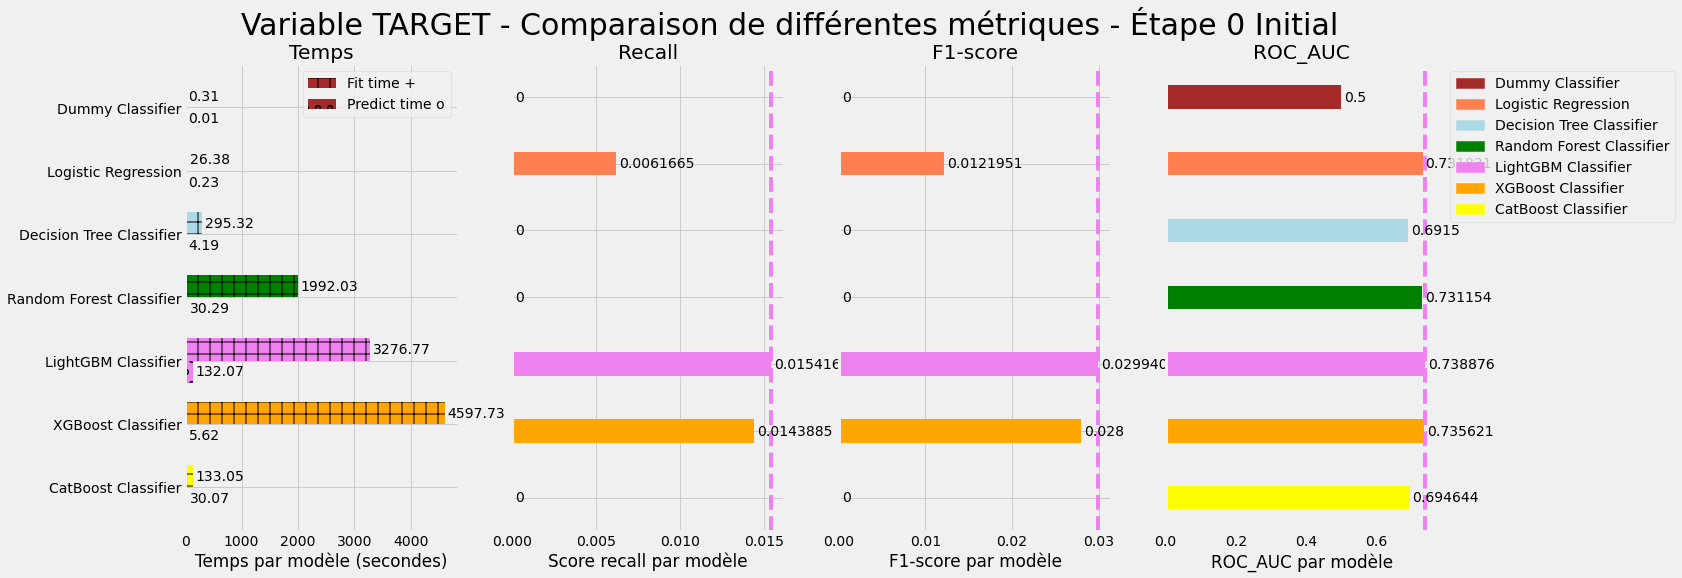

In [66]:
df_scores_step = df_scores.loc[df_scores['Step'] == step].reset_index(drop=True)

colors = []
for index, classifier_name in enumerate(classifiers_cv_results):
    colors.append(classifiers_cv_results[classifier_name]['color'])
colors

patches = []
for model, color in zip(df_scores_step['Model'], colors):
    patches.append(mpatches.Patch(color=color, label=model))

yticklabels = df_scores_step['Model']
    
displayTimesScoresComparisonForVariable('TARGET', df_scores_step, colors, patches, yticklabels, step, step)

<b>Cette étape est validée si la majorité des ROC AUC > 0.6 ou > 0.72, recall  et F1 score<= 0.1. Aussi les performances doivent être croissantes en fonction de la compléxité des modèles.</b>

In [67]:
# model = 4

# # y_pred contains probability, need to choose class depending on threshold
# # take 0.5 for now :
# threshold = 0.5

# y_pred_tmp = df_scores.iloc[model]['predictions']

# # if prediction is 0.5, client has same chance of repaying than defaulting the loan
# # from bank perspective, it's better not to take the chance to lose money, so don't loan = class 1
# # if pred < 0.5, class 0 the loan was repaid on time
# # else pred >= 0.5, class 1 the client had payment difficulties
# y_pred_binarized = np.where(np.array(y_pred_tmp) >= threshold, 1, 0)

# # calculate recall : tp / (tp + fn)
# recall = recall_score(y_test, y_pred_binarized)

# # calculate F1 score : 2 * (precision * recall) / (precision + recall)
# f1 = f1_score(y_test, y_pred_binarized)

# # calculate ROC_AUC
# roc_auc = roc_auc_score(y_test, y_pred_tmp)

# print('\nModel: \t\t', df_scores.iloc[model]['Model'],
#         '\nRecall: \t', "{:.4f}".format(recall),
#         '\nF1 score: \t', "{:.4f}".format(f1),
#         '\nROC_AUC: \t', "{:.4f}".format(roc_auc),
#         '\n')

# print('\n', confusion_matrix(y_test, y_pred_binarized))
# print('\n', classification_report(y_test, y_pred_binarized))

# Modélisation avec pondération

- Séparer les données en deux bases train/test (à partir du fichier train.csv). Le fichier test.csv ne peut pas être utilisé car il ne contient pas la target (dans le contexte du concours kaggle)
- Entraîner plusieurs modèles de classification : approche naïve (DummyClassifier), régression logistique, arbre de décision, random forests, xgboost/lightgbm/catboost
- Calculer les métriques sur les bases de train/test : recall, F1-score, AUC, matrice de confusion
- Cross-validation avec GridSearchCV (pour la recherche des hyper-paramètres, scoring=roc auc)
- Si jamais la recherche est trop longue, prendre un sous-échantillon du dataset.
- Créer une fonction regroupant la recherche des hyperparamètres et le calcul de performance
- Récapitulatif des performances (faire un tableau récapitulatif des performances)
- Cette étape est validée si la majorité des ROC AUC > 0.6 ou > 0.72, recall  et F1 score<= 0.1. Aussi les performances doivent être croissantes en fonction de la compléxité des modèles.

## Gestion du problème du déséquilibre des classes

Deux solutions possibles au problème du déséquilibre des classes:
- Sampling : under sampling
- Pondération des classes avec class_weights

On va utiliser la pondération des classes avec class_weights.

https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

## Initialisation des models et des hyperparamètres avec class_weight

In [68]:
# class_weight
# on peut soit utiliser 'balanced' qui applique une formule
# soit on utilise un dictionnaire

# balanced, by default
class_weight_params = ['balanced']

# Setting the range for class weights
# weights = np.linspace(.0, .25, 50)
# # Creating a dictionary grid for grid search
# class_weight_params = [{0:x, 1:1.0-x} for x in weights]
# class_weight_params

In [69]:
from sklearn.dummy import DummyClassifier
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import GridSearchCV

# Nombre de plis pour la CV
n_folds = 5

# meilleur scoring pour la recherche des poids
scoring = 'roc_auc'

# balanced, by default
class_weight_params = ['balanced']

# Setting the range for class weights
# weights = np.linspace(.0, .25, 50)
# Creating a dictionary grid for grid search
# class_weight_params = [{0:x, 1:1.0-x} for x in weights]

# Préparation du dictionnaire contenant les models et leurs paramètres pour la recherche croisée    
classifiers_cv = {
    'Dummy Classifier': {
        'classifier': DummyClassifier(),
        'color': 'brown',
        'param_grid': {}
    },
    'Logistic Regression': {
        'classifier': LogisticRegression(),
        'color': 'coral',
        'param_grid': 
            {'multi_class': ['ovr'],
             'penalty': ['l2'],
             'C': [.1],
             'multi_class': ['ovr'],
             'class_weight': class_weight_params}
    },
    'Logistic Regression': {
        'classifier': LogisticRegression(),
        'color': 'coral',
        'param_grid': 
            {'multi_class': ['ovr'],
             'penalty': ['l2'],
             'C': [.1, .01, .001, .0001],
             'multi_class': ['ovr'],
             'class_weight': class_weight_params}
    },
    'Decision Tree Classifier': {
        'classifier': DecisionTreeClassifier(),
        'color': 'lightblue',
        'param_grid':
            {'criterion': ['gini', 'entropy'],
             'max_depth': [9, 10, 11],
             'min_samples_leaf': [1, 2],
             'min_samples_split': [.1, .5, .8, 1],
             'splitter': ['best', 'random'],
             'class_weight': class_weight_params}
    },
    'Random Forest Classifier': {
        'classifier': RandomForestClassifier(),
        'color': 'green',
        'param_grid':
            {'criterion': ['entropy'],
             'max_depth': [10, 15],
             'min_samples_leaf': [3, 4],
             'min_samples_split': [3, 4],
             'n_estimators': [500],
             'class_weight': class_weight_params}
    },
    # 'Gradient Boosting Classifier': trop long
    'LightGBM Classifier': {
        'classifier': lgb.LGBMClassifier(),
        'color': 'violet',
        'param_grid': # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
            {'learning_rate': [.03, .05, .07],
             'n_estimators': [500],
             'max_depth': [1, 2, 3],
             'reg_alpha': np.logspace(-4, -1, 5),
             'reg_lambda': np.logspace(-4, -1, 5),
             'class_weight': class_weight_params}
    },
    'XGBoost Classifier': {
        'classifier': xgb.XGBClassifier(),
        'color': 'violet',
        'param_grid': # https://xgboost.readthedocs.io/en/latest/parameter.html
            {'objective':['reg:linear'],
             'learning_rate': [.03, 0.05, .07],
             'max_depth': [5, 6, 7],
             'min_child_weight': [1, 2, 3, 4],
             'class_weight': class_weight_params}
    },
    # 'CatBoost Classifier': pas de class_weight
}

In [70]:
CatBoostClassifier().get_params().keys()

dict_keys([])

## Entraînements, prédictions, scoring

<b>On réentraîne les models sur la base de train undersampled et sur la base de test originale.</b>

In [71]:
step = '2 class_weight'

classifiers_cv_results_weights = gridSearchCVMultipleClassifiersOneY(classifiers_cv, n_folds, scoring, X_scaled, X_test_std, y_train, y_test, step, df_scores, n_jobs=6, logScale=False, graphics=False)

Processing DummyClassifier() ...

Execution time in seconds: 0.3613288402557373

Step: 			 2 class_weight 
Model: 			 Dummy Classifier 
best_params: 		 {'constant': None, 'random_state': None, 'strategy': 'prior'} 
Recall: 		 0.0000 
F1 score: 		 0.0000 
ROC_AUC: 		 0.5000 
Execution time: 	 0.3613s (0m  0.36s) 
Mean fit time: 	 0.28s (0m  0.28s) 
Mean score time:  0.01s (0m  0.01s) 


 [[11328     0]
 [  973     0]]

               precision    recall  f1-score   support

           0       0.92      1.00      0.96     11328
           1       0.00      0.00      0.00       973

    accuracy                           0.92     12301
   macro avg       0.46      0.50      0.48     12301
weighted avg       0.85      0.92      0.88     12301

Processing LogisticRegression() ...

Execution time in seconds: 6.558413505554199

Step: 			 2 class_weight 
Model: 			 Logistic Regression 
best_params: 		 {'C': 0.001, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_sca

## Résultats GridSearchCV numériques et graphiques

Les résultats des scores de modélisation avec CV pour la variable TARGET.

In [72]:
df_scores

Step                     Model  \
0        0 Initial          Dummy Classifier   
1        0 Initial       Logistic Regression   
2        0 Initial  Decision Tree Classifier   
3        0 Initial  Random Forest Classifier   
4        0 Initial       LightGBM Classifier   
5        0 Initial        XGBoost Classifier   
6        0 Initial       CatBoost Classifier   
7   2 class_weight          Dummy Classifier   
8   2 class_weight       Logistic Regression   
9   2 class_weight  Decision Tree Classifier   
10  2 class_weight  Random Forest Classifier   
11  2 class_weight       LightGBM Classifier   
12  2 class_weight        XGBoost Classifier   

                                          best_params    recall  F1-score  \
0   {'constant': None, 'random_state': None, 'stra...  0.000000  0.000000   
1   {'C': 0.001, 'class_weight': None, 'dual': Fal...  0.006166  0.012195   
2   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  0.000000  0.000000   
3   {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  0.000000  0.000000   
4   {'boosting_type': 'gbdt', 'class_weight': None...  0.015416  0.029940   
5   {'objective': 'reg:linear', 'use_label_encoder...  0.014388  0.028000   
6   {'iterations': 10, 'learning_rate': 0.07, 'dep...  0.000000  0.000000   
7   {'constant': None, 'random_state': None, 'stra...  0.000000  0.000000   
8   {'C': 0.001, 'class_weight': 'balanced', 'dual...  0.633094  0.244154   
9   {'ccp_alpha': 0.0, 'class_weight': 'balanced',...  0.677287  0.220438   
10  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  0.492292  0.247098   
11  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.631038  0.251433   
12  {'objective': 'reg:linear', 'use_label_encoder...  0.014388  0.028000   

     ROC_AUC  execution_time  mean_fit_time  mean_score_time  \
0   0.500000        2.759490           0.31             0.01   
1   0.731831        5.364130          26.38             0.23   
2   0.691500       52.889139         295.32             4.19   
3   0.731154      415.735168        1992.03            30.29   
4   0.738876      575.357862        3276.77           132.07   
5   0.735621      778.177010        4597.73             5.62   
6   0.694644       35.755430         133.05            30.07   
7   0.500000        0.361329           0.28             0.01   
8   0.731172        6.558414          33.85             0.23   
9   0.690978       50.589114         280.54             4.32   
10  0.709825      414.565387        2045.09            32.03   
11  0.739702      887.912704        5237.40            54.16   
12  0.735621      788.893998        4657.29             5.73   

                                          predictions  
0   [0.08081136562264994, 0.08081136562264994, 0.0...  
1   [0.2718529797978223, 0.08796157869098979, 0.05...  
2   [0.12148010239702117, 0.13855421686746988, 0.0...  
3   [0.15928920402372373, 0.055912015986737916, 0....  
4   [0.2269374499911105, 0.076065362927037, 0.0678...  
5   [0.14767434, 0.08503602, 0.0619463, 0.09896713...  
6   [0.25961769385861094, 0.2051074946079513, 0.19...  
7   [0.08081136562264994, 0.08081136562264994, 0.0...  
8   [0.8420309830070022, 0.5505747666542581, 0.395...  
9   [0.6294307423351305, 0.6443037909077501, 0.509...  
10  [0.6693502383111138, 0.20874085200639553, 0.46...  
11  [0.7977831733673173, 0.35674312132629116, 0.45...  
12  [0.14767434, 0.08503602, 0.0619463, 0.09896713...

Comparaison des temps d'entraînement et de prédictions et des scores Recall/F1/ROC_AUC par modèles pour la variable TARGET à l'étape 2 class_weight


<Figure size 1440x864 with 0 Axes>

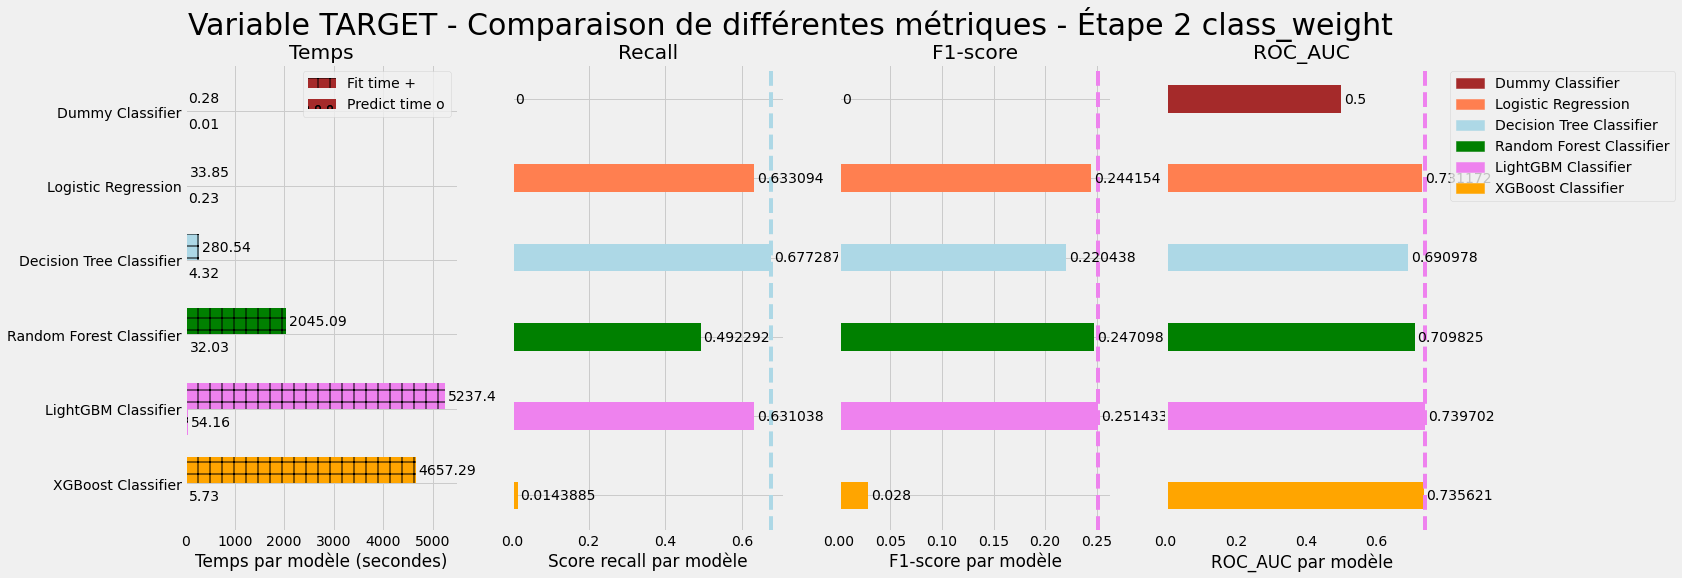

In [73]:
df_scores_step = df_scores.loc[df_scores['Step'] == step].reset_index(drop=True)

colors = []
for index, classifier_name in enumerate(classifiers_cv_results):
    colors.append(classifiers_cv_results[classifier_name]['color'])
colors

patches = []
for model, color in zip(df_scores_step['Model'], colors):
    patches.append(mpatches.Patch(color=color, label=model))

yticklabels = df_scores_step['Model']
    
displayTimesScoresComparisonForVariable('TARGET', df_scores_step, colors, patches, yticklabels, step, step)

<b>Cette étape est validée si la majorité des ROC AUC > 0.6 ou > 0.72, recall >= 0.5 et < 0.7, F1 score >= 0.2 et < 0.4 . On doit donc constater une amélioration de la capacité du modèle à détecter les FP et FN.</b>

In [74]:
# model = 'Logistic Regression'

# weigh_data = pd.DataFrame({'score': classifiers_cv_results_weights[model]['results']['cv_results']['mean_test_score'], 'weight': [params['class_weight'][1] for params in classifiers_cv_results_weights[model]['results']['cv_results']['params']]})

# #Ploting the score for different values of weight
# sns.set_style('whitegrid')
# plt.figure(figsize=(12,8))

# sns.lineplot(weigh_data['weight'], weigh_data['score'])

# plt.xlabel('Weight for class 1')
# plt.ylabel('f1 score')
# plt.xticks([round(i/10,1) for i in range(0,11,1)])
# plt.title('Scoring for different class weights', fontsize=24)

In [75]:
# max_mean_test_score = np.max(classifiers_cv_results_weights[model]['results']['cv_results']['mean_test_score'])
# index_max_mean_test_score = np.where(classifiers_cv_results_weights[model]['results']['cv_results']['mean_test_score'] == np.max(classifiers_cv_results_weights[model]['results']['cv_results']['mean_test_score']))[0][0]
# best_class_weight = classifiers_cv_results_weights[model]['results']['cv_results']['params'][index_max_mean_test_score]['class_weight']
# best_class_weight

In [76]:
# ROC AUC > 0.6 ou > 0.72
roc_auc_min = 0.6

# recall >= 0.5 et < 0.7
recall_min = 0.5
recall_max = 0.7

# F1 score >= 0.2 et < 0.4
f1_min = 0.2
f1_max = 0.4

# Filter and sort by ROC_AUC score, then recall
df_scores.loc[(df_scores['ROC_AUC'] > roc_auc_min)
             & df_scores['recall'].between(recall_min, recall_max)
             & df_scores['F1-score'].between(f1_min, f1_max)].sort_values(by=['ROC_AUC', 'recall'], ascending=False)

Step                     Model  \
11  2 class_weight       LightGBM Classifier   
8   2 class_weight       Logistic Regression   
9   2 class_weight  Decision Tree Classifier   

                                          best_params    recall  F1-score  \
11  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.631038  0.251433   
8   {'C': 0.001, 'class_weight': 'balanced', 'dual...  0.633094  0.244154   
9   {'ccp_alpha': 0.0, 'class_weight': 'balanced',...  0.677287  0.220438   

     ROC_AUC  execution_time  mean_fit_time  mean_score_time  \
11  0.739702      887.912704        5237.40            54.16   
8   0.731172        6.558414          33.85             0.23   
9   0.690978       50.589114         280.54             4.32   

                                          predictions  
11  [0.7977831733673173, 0.35674312132629116, 0.45...  
8   [0.8420309830070022, 0.5505747666542581, 0.395...  
9   [0.6294307423351305, 0.6443037909077501, 0.509...

# Sélection des deux meilleurs modèles

In [77]:
# ROC AUC > 0.6 ou > 0.72
roc_auc_min = 0.6

# recall >= 0.5 et < 0.7
recall_min = 0.5
recall_max = 0.7

# F1 score >= 0.2 et < 0.4
f1_min = 0.2
f1_max = 0.4

# Filter and sort by ROC_AUC score, then recall
df_scores.loc[(df_scores['ROC_AUC'] > roc_auc_min)
             & df_scores['recall'].between(recall_min, recall_max)
             & df_scores['F1-score'].between(f1_min, f1_max)].sort_values(by=['ROC_AUC', 'recall'], ascending=False)

Step                     Model  \
11  2 class_weight       LightGBM Classifier   
8   2 class_weight       Logistic Regression   
9   2 class_weight  Decision Tree Classifier   

                                          best_params    recall  F1-score  \
11  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.631038  0.251433   
8   {'C': 0.001, 'class_weight': 'balanced', 'dual...  0.633094  0.244154   
9   {'ccp_alpha': 0.0, 'class_weight': 'balanced',...  0.677287  0.220438   

     ROC_AUC  execution_time  mean_fit_time  mean_score_time  \
11  0.739702      887.912704        5237.40            54.16   
8   0.731172        6.558414          33.85             0.23   
9   0.690978       50.589114         280.54             4.32   

                                          predictions  
11  [0.7977831733673173, 0.35674312132629116, 0.45...  
8   [0.8420309830070022, 0.5505747666542581, 0.395...  
9   [0.6294307423351305, 0.6443037909077501, 0.509...

Les deux meilleurs models sont :
- LightGBM Classifier,
- Logistic Regression.

In [78]:
best_LGBM_classifier = classifiers_cv_results_weights['LightGBM Classifier']['results']['best_estimator']
best_LGBM_classifier

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=2,
               n_estimators=500, reg_alpha=0.0005623413251903491,
               reg_lambda=0.0031622776601683794)

In [79]:
best_decision_tree_classifier = classifiers_cv_results_weights['Decision Tree Classifier']['results']['best_estimator']
best_decision_tree_classifier

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=11, min_samples_split=0.1)

# Feature engineering

## Nouvelles variables

Créer au moins 3 nouvelles variables dans le but d'améliorer les performances, exemples :

The most important features that I engineered, in descending order of importance (measured by gain in the LGBM model), were the following:
- AMT_ANNUITY / INCOME
- credit_annuity_ratio: AMT_CREDIT / AMT_ANNUITY
- credit_goods_price_ratio: AMT_CREDIT / AMT_GOODS_PRICE
- credit_downpayment: AMT_GOOD_PRICE - AMT_CREDIT
- AGE_INT: int(DAYS_BIRTH / -365)

In [80]:
# df_application_train.columns

- CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
- ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
- CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
- DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [81]:
df_application_train_splitable[['AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_BIRTH']].describe()

AMT_ANNUITY  AMT_INCOME_TOTAL    AMT_CREDIT  AMT_GOODS_PRICE  \
count   61500.000000      6.150200e+04  6.150200e+04     6.144800e+04   
mean    27061.917220      1.701541e+05  5.965660e+05     5.360502e+05   
std     14425.973334      4.872706e+05  4.000463e+05     3.670081e+05   
min      1980.000000      2.610000e+04  4.500000e+04     4.500000e+04   
25%     16582.500000      1.125000e+05  2.700000e+05     2.385000e+05   
50%     24903.000000      1.485000e+05  5.099220e+05     4.500000e+05   
75%     34465.500000      2.025000e+05  8.086500e+05     6.795000e+05   
max    230161.500000      1.170000e+08  4.050000e+06     4.050000e+06   

         DAYS_BIRTH  
count  61502.000000  
mean   16029.189929  
std     4374.891140  
min     7673.000000  
25%    12395.000000  
50%    15730.000000  
75%    19680.000000  
max    25201.000000

In [82]:
df_application_train_splitable[['AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_BIRTH']].isna().mean()

AMT_ANNUITY         0.000033
AMT_INCOME_TOTAL    0.000000
AMT_CREDIT          0.000000
AMT_GOODS_PRICE     0.000878
DAYS_BIRTH          0.000000
dtype: float64

In [83]:
df_application_train_splitable_fe = df_application_train_splitable.copy()

df_application_train_splitable_fe['CREDIT_INCOME_PERCENT'] = df_application_train_splitable_fe['AMT_CREDIT'] / df_application_train_splitable_fe['AMT_INCOME_TOTAL']
df_application_train_splitable_fe['ANNUITY_INCOME_PERCENT'] = df_application_train_splitable_fe['AMT_ANNUITY'] / df_application_train_splitable_fe['AMT_INCOME_TOTAL']
df_application_train_splitable_fe['CREDIT_TERM'] = df_application_train_splitable_fe['AMT_ANNUITY'] / df_application_train_splitable_fe['AMT_CREDIT']
df_application_train_splitable_fe['DAYS_EMPLOYED_PERCENT'] = df_application_train_splitable_fe['DAYS_EMPLOYED'] / df_application_train_splitable_fe['DAYS_BIRTH']

In [84]:
df_application_train_splitable_fe[['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']].describe()

CREDIT_INCOME_PERCENT  ANNUITY_INCOME_PERCENT   CREDIT_TERM  \
count           61502.000000            61500.000000  61500.000000   
mean                3.950284                0.180990      0.053755   
std                 2.666389                0.094264      0.022480   
min                 0.004808                0.000224      0.022074   
25%                 2.021429                0.114876      0.037059   
50%                 3.267273                0.162942      0.050000   
75%                 5.148444                0.229696      0.064042   
max                36.692308                1.570600      0.124428   

       DAYS_EMPLOYED_PERCENT  
count           50452.000000  
mean               -0.157162  
std                 0.133351  
min                -0.718198  
25%                -0.219349  
50%                -0.119645  
75%                -0.056402  
max                -0.000107

## Visualisation des nouvelles variables

Nous devrions explorer ces variables de connaissance de domaine visuellement dans un graphique. Pour tous ces éléments, nous ferons le même tracé KDE coloré par la valeur de la TARGET.

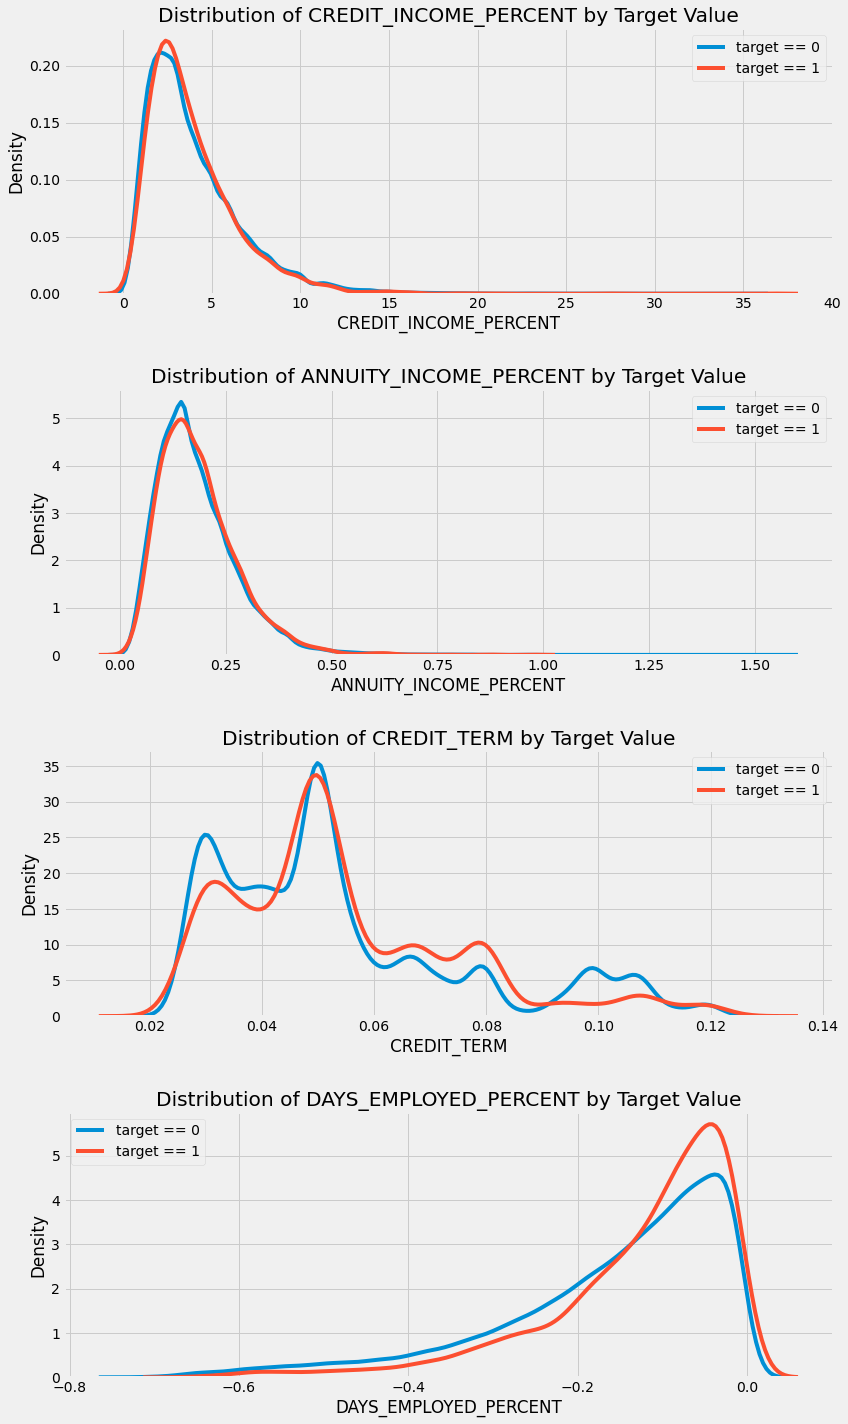

In [85]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_application_train_splitable_fe.loc[df_application_train_splitable_fe['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_application_train_splitable_fe.loc[df_application_train_splitable_fe['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

## Corrélations

Maintenant que nous avons traité les variables catégorielles et les valeurs aberrantes, continuons avec l'EDA. Une façon d'essayer de comprendre les données consiste à rechercher des corrélations entre les fonctionnalités et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible à l'aide de la méthode.corr dataframe.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la « pertinence » d'une caractéristique, mais il nous donne une idée des relations possibles au sein des données.

Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :
- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

In [86]:
# Find correlations with the target and sort
correlations_fe = df_application_train_splitable_fe.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations_fe.tail(15))
print('\nMost Negative Correlations:\n', correlations_fe.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043874
REG_CITY_NOT_LIVE_CITY                               0.044038
FLAG_EMP_PHONE                                       0.047226
DAYS_ID_PUBLISH                                      0.048411
REG_CITY_NOT_WORK_CITY                               0.050905
NAME_EDUCATION_TYPE_Secondary / secondary special    0.053917
CODE_GENDER_M                                        0.054320
DAYS_LAST_PHONE_CHANGE                               0.060831
REGION_RATING_CLIENT_W_CITY                          0.062071
REGION_RATING_CLIENT                                 0.062267
NAME_INCOME_TYPE_Working                             0.065021
DAYS_EMPLOYED_PERCENT                                0.071021
DAYS_EMPLOYED                                        0.077975
TARGET                                               1.000000
FLAG_MOBIL                                                NaN
Name: TARGET, dtype: float64

Most Negati

## Modélisation

### Préparation des données

In [87]:
df_engineered_vars = df_application_train_splitable_fe[['SK_ID_CURR', 'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']]
df_engineered_vars.head()

SK_ID_CURR  CREDIT_INCOME_PERCENT  ANNUITY_INCOME_PERCENT  \
245895      384575               2.248587                0.254304   
98194       214010               5.178636                0.197764   
36463       142232               2.444444                0.193133   
249923      389171               1.029091                0.100764   
158389      283617               2.738960                0.141000   

        CREDIT_TERM  DAYS_EMPLOYED_PERCENT  
245895     0.113095              -0.057306  
98194      0.038188              -0.077209  
36463      0.079009              -0.035684  
249923     0.097915              -0.355753  
158389     0.051479              -0.054361

In [88]:
df_application_train_splitable_fe.isna().mean()

SK_ID_CURR                0.000000
TARGET                    0.000000
NAME_CONTRACT_TYPE        0.000000
FLAG_OWN_CAR              0.000000
FLAG_OWN_REALTY           0.000000
                            ...   
DAYS_EMPLOYED_ANOM        0.000000
CREDIT_INCOME_PERCENT     0.000000
ANNUITY_INCOME_PERCENT    0.000033
CREDIT_TERM               0.000033
DAYS_EMPLOYED_PERCENT     0.179669
Length: 248, dtype: float64

In [89]:
features_fe = df_application_train_splitable_fe.drop(columns = ['TARGET'])

# Feature names
feature_fe_names = list(features_fe.columns)

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(features_fe)

# Transform both training and testing data
features_fe = imputer.transform(features_fe)

# Repeat with the scaler
scaler.fit(features_fe)
features_fe = scaler.transform(features_fe)

print('Features engineered training data shape: ', features_fe.shape)

Features engineered training data shape:  (61502, 247)


### Séparer les données en train et test

In [90]:
from sklearn.model_selection import train_test_split

# Séparer X et y
# Séparer les données en train et test 80/20 avec train test split de sklearn
X_train, X_test, y_train, y_test = train_test_split(features_fe,
                                                    target,
                                                    test_size = 0.2, random_state = 0)

In [91]:
X_train.shape

(49201, 247)

In [92]:
X_test.shape

(12301, 247)

In [93]:
y_train.shape

(49201,)

### Santardiser les données d'entraînement

In [94]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler().fit(X_train)
X_scaled = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

### Entraînements, prédictions, scoring

In [95]:
import time

def computeFitPredictProbaOneClassifierOneY(model, model_name, scoring, X_train, X_test, y_train, y_test, step, df_scores, n_jobs):
    
    startTime = time.time()
        
    # Lancer l'entraînement du model pour la variable
    model.fit(X_train, y_train)
    
    afterFittingTime = time.time()
    fitTime = (afterFittingTime - startTime)
    print('Fitting time in seconds: ' + str(fitTime))
    
#     # Score du model sur la variable
#     score_train = model.score(X_train, y_train)
    
#     # Calculer les performances sur la base de test avec score
#     score_test = model.score(X_test, y_test)

    # Prédictions sur les variables de test
    # Now that the model has been trained, we can use it to make predictions.
    # We want to predict the probabilities of not paying a loan, so we use the model predict.proba method.
    # This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1).
    # We want the probability the loan is not repaid, so we will select the second column.
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # y_pred = gscv.predict(X_test)
    
    # cv_results = gscv.cv_results_
    # best_estimator = gscv.best_estimator_

    predictTime = (time.time() - afterFittingTime)
    
    # Temps d'entraînement 
    mean_fit_time = round(fitTime, 2)    
    
    # Temps de prédiction 
    mean_score_time = round(predictTime, 2)
    
    print('Execution time in seconds: ' + str(mean_fit_time + mean_score_time))
    
    # Calcul des résultats
    computeScoresPredictions(model_name, model.get_params(), y_test, y_pred_proba, step, df_scores, mean_fit_time + mean_score_time, mean_fit_time, mean_score_time)    

#### LGBM Classifier

In [96]:
model_name = 'LightGBM Classifier'

# Train on the training data
# best_LGBM_classifier.fit(X_scaled, y_train)

In [97]:
computeFitPredictProbaOneClassifierOneY(best_LGBM_classifier, model_name, scoring, X_scaled, X_test_std, y_train, y_test, '3 Feature engineering', df_scores, n_jobs=6)

Fitting time in seconds: 1.2221107482910156
Execution time in seconds: 1.27

Step: 			 3 Feature engineering 
Model: 			 LightGBM Classifier 
best_params: 		 {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0005623413251903491, 'reg_lambda': 0.0031622776601683794, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Recall: 		 0.6516 
F1 score: 		 0.2604 
ROC_AUC: 		 0.7451 
Execution time: 	 1.2700s (0m  1.27s) 
Mean fit time: 	 1.22s (0m  1.22s) 
Mean score time:  0.05s (0m  0.05s) 


 [[8065 3263]
 [ 339  634]]

               precision    recall  f1-score   support

           0       0.96      0.71      0.82     11328
           1       0.16      0.65      0.26       973


In [98]:
df_scores.loc[df_scores['Model'] == 'LightGBM Classifier']

Step                Model  \
4               0 Initial  LightGBM Classifier   
11         2 class_weight  LightGBM Classifier   
13  3 Feature engineering  LightGBM Classifier   

                                          best_params    recall  F1-score  \
4   {'boosting_type': 'gbdt', 'class_weight': None...  0.015416  0.029940   
11  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.631038  0.251433   
13  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.651593  0.260370   

     ROC_AUC  execution_time  mean_fit_time  mean_score_time  \
4   0.738876      575.357862        3276.77           132.07   
11  0.739702      887.912704        5237.40            54.16   
13  0.745118        1.270000           1.22             0.05   

                                          predictions  
4   [0.2269374499911105, 0.076065362927037, 0.0678...  
11  [0.7977831733673173, 0.35674312132629116, 0.45...  
13  [0.8012274387338882, 0.3721689036232509, 0.458...

Comparaison des temps d'entraînement et de prédictions et des scores Recall/F1/ROC_AUC par modèles pour la variable TARGET à l'étape 3 Feature engineering


<Figure size 1440x864 with 0 Axes>

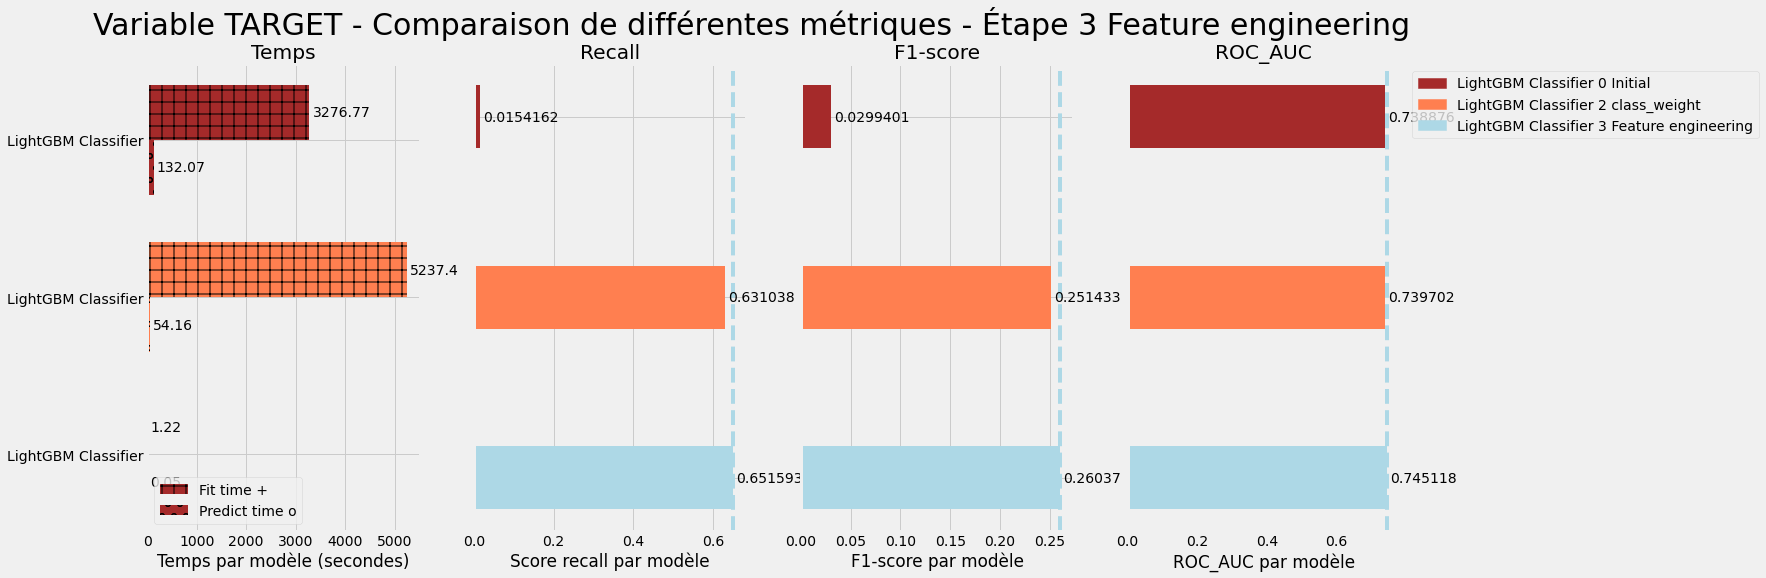

In [99]:
df_scores_lgbm = df_scores.loc[df_scores['Model'] == 'LightGBM Classifier'].reset_index(drop=True)

colors = []
for index, classifier_name in enumerate(df_scores_lgbm['Model']):
    colors.append(colors_arr[index])
colors

patches = []
for model, step, color in zip(df_scores_lgbm['Model'], df_scores_lgbm['Step'], colors):
    patches.append(mpatches.Patch(color=color, label=model + ' ' + step))

yticklabels = df_scores_lgbm['Model']
    
displayTimesScoresComparisonForVariable('TARGET', df_scores_lgbm, colors, patches, yticklabels, step, step)

In [100]:
best_LGBM_classifier.feature_importances_

array([ 24,  12,   4,   0,   0,  10,  31,  37,  39,  15,  65,  41,  22,
        36,  23,   0,   0,  10,   0,   2,   6,   1,   9,   4,  16,   0,
         0,   0,   2,   2,   1,  94, 125, 130,   0,   2,   5,   2,   3,
         2,   1,   1,   3,   7,   6,   3,   0,  18,   4,   0,  13,  10,
        16,   3,   1,   4,   0,   1,  18,   3,   4,   5,   1,   2,   3,
         9,   2,   0,   1,   0,   6,   5,   5,   2,   0,   2,   2,   6,
        15,   3,   9,  34,   0,  11,   0,   3,   2,   0,   0,   0,   0,
         0,   0,   6,   0,   2,   0,   0,   3,   0,   0,   0,   0,   2,
         0,  11,  15,  14,   0,  25,   0,   0,   1,   0,   0,   0,   0,
         3,   0,   1,   0,   0,   5,   0,   0,  11,   0,   9,   0,   0,
        16,   1,  20,   0,   1,   0,   0,   0,  12,   7,   0,   2,   0,
         1,   0,   0,  11,   9,   0,   0,   0,   4,   0,   0,   0,   9,
         0,   0,   0,   0,   0,   0,   4,   0,   0,   0,   0,   0,   0,
         0,   3,   0,   0,   5,   0,   1,   0,   0,   0,   0,   

On utilise les coefficients feature importance.

In [101]:
dict_feature_importance_lgbm = dict(zip(feature_fe_names, best_LGBM_classifier.feature_importances_))

Les 15 variables les plus influentes :

In [102]:
n_coeffs = 15

sorted_abs_dict_feature_importance_lgbm = sorted(dict_feature_importance_lgbm.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_abs_dict_feature_importance_lgbm[:n_coeffs]

[('EXT_SOURCE_3', 130),
 ('EXT_SOURCE_2', 125),
 ('CREDIT_TERM', 115),
 ('EXT_SOURCE_1', 94),
 ('DAYS_BIRTH', 65),
 ('DAYS_EMPLOYED', 41),
 ('AMT_GOODS_PRICE', 39),
 ('AMT_ANNUITY', 37),
 ('DAYS_ID_PUBLISH', 36),
 ('DAYS_LAST_PHONE_CHANGE', 34),
 ('DAYS_EMPLOYED_PERCENT', 32),
 ('AMT_CREDIT', 31),
 ('ANNUITY_INCOME_PERCENT', 28),
 ('CODE_GENDER_M', 25),
 ('CREDIT_INCOME_PERCENT', 25)]

In [103]:
# recherche des variables créées
[index + 1 for index, value in enumerate(sorted_abs_dict_feature_importance_lgbm) if value[0] == 'DAYS_EMPLOYED_PERCENT']

[11]

Voici le classement des variables créées en feature engineering par classement dans l'ordre des feature importance du lgbm classifier :
- CREDIT_INCOME_PERCENT: 15ème,
- ANNUITY_INCOME_PERCENT: 13ème,
- CREDIT_TERM: 3ème,
- DAYS_EMPLOYED_PERCENT: 11ème.

#### Decision Tree Classifier

In [104]:
model_name = 'Decision Tree Classifier'

# Train on the training data
# best_decision_tree_classifier.fit(X_scaled, y_train)

In [105]:
computeFitPredictProbaOneClassifierOneY(best_decision_tree_classifier, model_name, scoring, X_scaled, X_test_std, y_train, y_test, '3 Feature engineering', df_scores, n_jobs=6)

Fitting time in seconds: 1.234123945236206
Execution time in seconds: 1.24

Step: 			 3 Feature engineering 
Model: 			 Decision Tree Classifier 
best_params: 		 {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 11, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 
Recall: 		 0.6783 
F1 score: 		 0.2211 
ROC_AUC: 		 0.6914 
Execution time: 	 1.2400s (0m  1.24s) 
Mean fit time: 	 1.23s (0m  1.23s) 
Mean score time:  0.01s (0m  0.01s) 


 [[6991 4337]
 [ 313  660]]

               precision    recall  f1-score   support

           0       0.96      0.62      0.75     11328
           1       0.13      0.68      0.22       973

    accuracy                           0.62     12301
   macro avg       0.54      0.65      0.49     12301
weighted avg       0.89      0.62      0.71     12301



In [106]:
df_scores.loc[df_scores['Model'] == 'Decision Tree Classifier']

Step                     Model  \
2               0 Initial  Decision Tree Classifier   
9          2 class_weight  Decision Tree Classifier   
14  3 Feature engineering  Decision Tree Classifier   

                                          best_params    recall  F1-score  \
2   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  0.000000  0.000000   
9   {'ccp_alpha': 0.0, 'class_weight': 'balanced',...  0.677287  0.220438   
14  {'ccp_alpha': 0.0, 'class_weight': 'balanced',...  0.678314  0.221106   

     ROC_AUC  execution_time  mean_fit_time  mean_score_time  \
2   0.691500       52.889139         295.32             4.19   
9   0.690978       50.589114         280.54             4.32   
14  0.691402        1.240000           1.23             0.01   

                                          predictions  
2   [0.12148010239702117, 0.13855421686746988, 0.0...  
9   [0.6294307423351305, 0.6443037909077501, 0.509...  
14  [0.6294307423351305, 0.6443037909077501, 0.509...

Comparaison des temps d'entraînement et de prédictions et des scores Recall/F1/ROC_AUC par modèles pour la variable TARGET à l'étape 3 Feature engineering


<Figure size 1440x864 with 0 Axes>

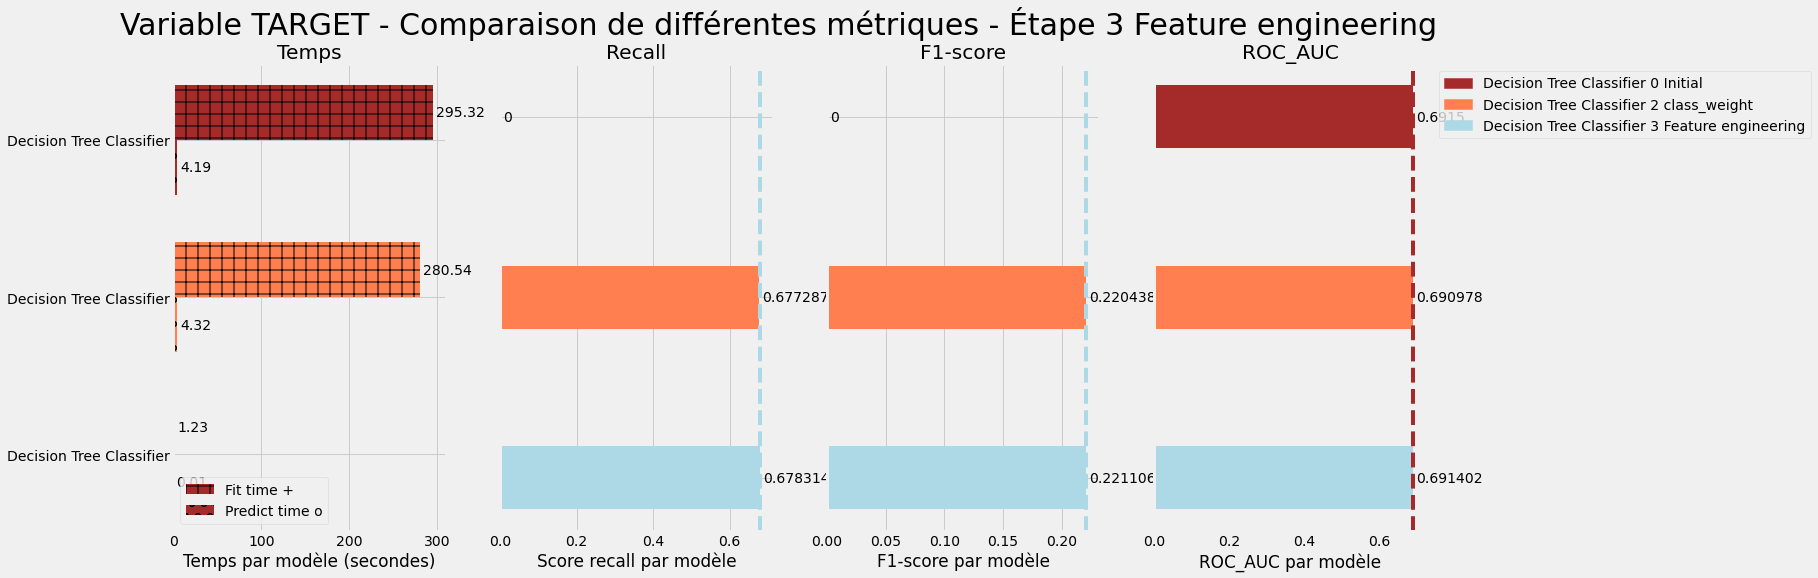

In [107]:
df_scores_dtree = df_scores.loc[df_scores['Model'] == 'Decision Tree Classifier'].reset_index(drop=True)

colors = []
for index, classifier_name in enumerate(df_scores_dtree['Model']):
    colors.append(colors_arr[index])
colors

patches = []
for model, step, color in zip(df_scores_dtree['Model'], df_scores_dtree['Step'], colors):
    patches.append(mpatches.Patch(color=color, label=model + ' ' + step))

yticklabels = df_scores_dtree['Model']
    
displayTimesScoresComparisonForVariable('TARGET', df_scores_dtree, colors, patches, yticklabels, step, step)

In [108]:
# best_decision_tree_classifier.feature_importances_

On utilise les coefficients feature importance.

In [109]:
dict_feature_importance_dtree = dict(zip(feature_fe_names, best_decision_tree_classifier.feature_importances_))

Les 15 variables les plus influentes :

In [110]:
n_coeffs = 15

sorted_abs_dict_feature_importance_dtree = sorted(dict_feature_importance_dtree.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_abs_dict_feature_importance_dtree[:n_coeffs]

[('EXT_SOURCE_2', 0.4657846039174428),
 ('EXT_SOURCE_3', 0.36707044156465773),
 ('EXT_SOURCE_1', 0.09634977276692044),
 ('DAYS_BIRTH', 0.016588395692271045),
 ('DAYS_EMPLOYED_PERCENT', 0.015386987335768019),
 ('YEARS_BUILD_MEDI', 0.010859155423690462),
 ('AMT_ANNUITY', 0.009624909672562576),
 ('REGION_POPULATION_RELATIVE', 0.009383455880726166),
 ('OBS_30_CNT_SOCIAL_CIRCLE', 0.008952277745960767),
 ('SK_ID_CURR', 0.0),
 ('NAME_CONTRACT_TYPE', 0.0),
 ('FLAG_OWN_CAR', 0.0),
 ('FLAG_OWN_REALTY', 0.0),
 ('CNT_CHILDREN', 0.0),
 ('AMT_INCOME_TOTAL', 0.0)]

In [111]:
# recherche des variables créées
[index + 1 for index, value in enumerate(sorted_abs_dict_feature_importance_dtree) if value[0] == 'CREDIT_INCOME_PERCENT']

[245]

Voici le classement des variables créées en feature engineering par classement dans l'ordre des feature importance du decision tree classifier :
- CREDIT_INCOME_PERCENT: 245ème du dtree,
- ANNUITY_INCOME_PERCENT: 246ème du dtree,
- CREDIT_TERM: 247ème du dtree,
- DAYS_EMPLOYED_PERCENT: 5ème dtree.

## Récapitulatif des améliorations

On constate que l'ajout de plusieurs (4) nouvelles variables construites à partir de variables existentes permet d'améliorer peu ou moyennement les performances. Ces nouvelles variables font parti du top x en feature importance, elles sont donc pertinentes pour la suite du projet de modélisation.

Voici le classement des variables créées en feature engineering par classement dans l'ordre des feature importance du lgbm et du decision tree classifier :
- CREDIT_INCOME_PERCENT: 15ème lgbm, 245ème du dtree,
- ANNUITY_INCOME_PERCENT: 13ème lgbm, 246ème du dtree,
- CREDIT_TERM: 3ème lgbm, 247ème du dtree,
- DAYS_EMPLOYED_PERCENT: 11ème lgbm, 5ème dtree.

# Feature selection

feature selection (supprimer des variables pour alléger/améliorer le modèle)
- Avec modèle entrainé : https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel
- Sans modèle : https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
- Automatiquement : https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples[…]ith-cross-validation-py
- Tuto d'un winner de la compet : https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

- https://www.kaggle.com/code/ogrellier/feature-selection-with-null-importances/notebook
- https://academic.oup.com/bioinformatics/article/26/10/1340/193348

## Feature selection using target permutation

In [112]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

## Read application_train

In [113]:
data = pd.read_csv('data/application_train.csv')

categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]

categorical_feats
for f_ in categorical_feats:
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype('category')

## Add engineered features

In [114]:
data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
data['DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

## Create a scoring function

importance_type (string, optional (default="split")) – How the importance is calculated :
- If 'split', result contains numbers of times the feature is used in a model,
- If 'gain', result contains total gains of splits which use the feature.

In [115]:
data['TARGET'].copy().value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [116]:
data['TARGET'].copy().sample(frac=1.0).value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [117]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['TARGET'].copy().sample(frac=1.0) # The data has been changed (permanently shuffled), but you will find that both the initial Series and the shuffled one are still equal (same value_counts)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

## Build the benchmark for feature importance

In [118]:
# Seed the unexpected randomness of this world
np.random.seed(123)

# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=data, shuffle=False)

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12399
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


In [119]:
actual_imp_df.sort_values(by='importance_gain', ascending=False).head(15)

feature  importance_gain  importance_split  trn_score
41             EXT_SOURCE_3    735460.204881              1527   0.760016
40             EXT_SOURCE_2    709632.801733              2223   0.760016
39             EXT_SOURCE_1    208046.774170              2754   0.760016
122             CREDIT_TERM     81179.377598              1770   0.760016
26          OCCUPATION_TYPE     80803.848079               524   0.760016
15               DAYS_BIRTH     63715.756635              1260   0.760016
38        ORGANIZATION_TYPE     60499.513599               923   0.760016
16            DAYS_EMPLOYED     45786.138658               917   0.760016
8           AMT_GOODS_PRICE     32010.909652               734   0.760016
123   DAYS_EMPLOYED_PERCENT     26141.305420               786   0.760016
7               AMT_ANNUITY     22756.139338               710   0.760016
6                AMT_CREDIT     20871.798136               572   0.760016
93   DAYS_LAST_PHONE_CHANGE     20863.815131               569   0.760016
1               CODE_GENDER     20070.803700               457   0.760016
18          DAYS_ID_PUBLISH     19221.844371               741   0.760016

In [120]:
actual_imp_df.sort_values(by='importance_split', ascending=False).head()

feature  importance_gain  importance_split  trn_score
39   EXT_SOURCE_1    208046.774170              2754   0.760016
40   EXT_SOURCE_2    709632.801733              2223   0.760016
122   CREDIT_TERM     81179.377598              1770   0.760016
41   EXT_SOURCE_3    735460.204881              1527   0.760016
15     DAYS_BIRTH     63715.756635              1260   0.760016

## Build Null Importances distribution

In [121]:
null_imp_df = pd.DataFrame()
nb_runs = 80

start = time.time()

dsp = ''
for i in range(nb_runs):

    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
        
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12399
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [122]:
null_imp_df.sort_values(by='importance_gain', ascending=False).head()

feature  importance_gain  importance_split  trn_score  run
38  ORGANIZATION_TYPE     13009.826085               876   0.700340   31
38  ORGANIZATION_TYPE     12938.862168               929   0.709834   75
38  ORGANIZATION_TYPE     12826.775497               885   0.702881   48
38  ORGANIZATION_TYPE     12528.285120               922   0.689105   56
38  ORGANIZATION_TYPE     12478.359046               759   0.676977   17

In [123]:
print('Nb of features: \t', null_imp_df['feature'].nunique(),
      '\nNb of iterations: \t', str(nb_runs),
      '\nNb of rows: \t\t', str(null_imp_df.shape[0]))

Nb of features: 	 124 
Nb of iterations: 	 80 
Nb of rows: 		 9920


## Display distribution examples

In [124]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
        

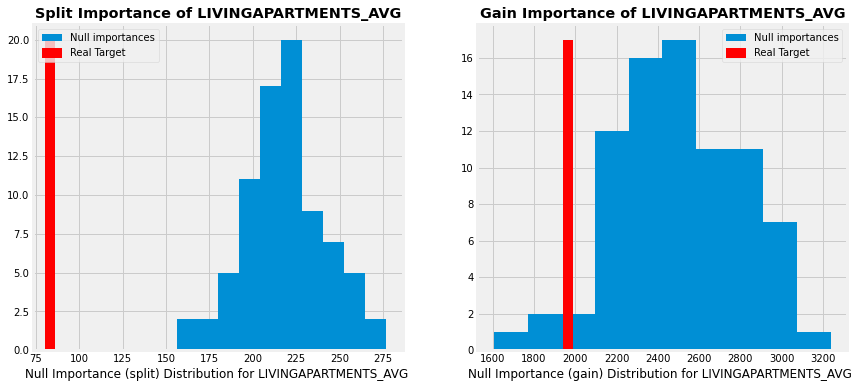

In [125]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='LIVINGAPARTMENTS_AVG')

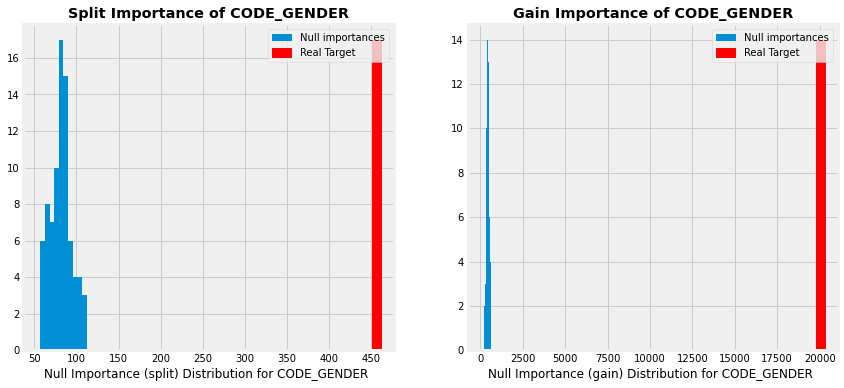

In [126]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='CODE_GENDER')

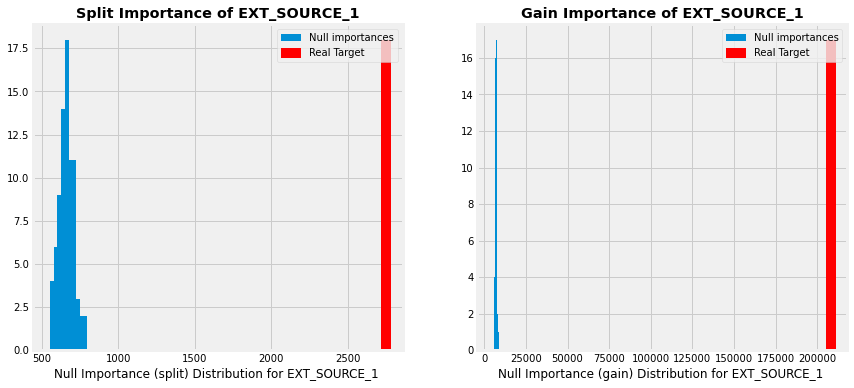

In [127]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='EXT_SOURCE_1')

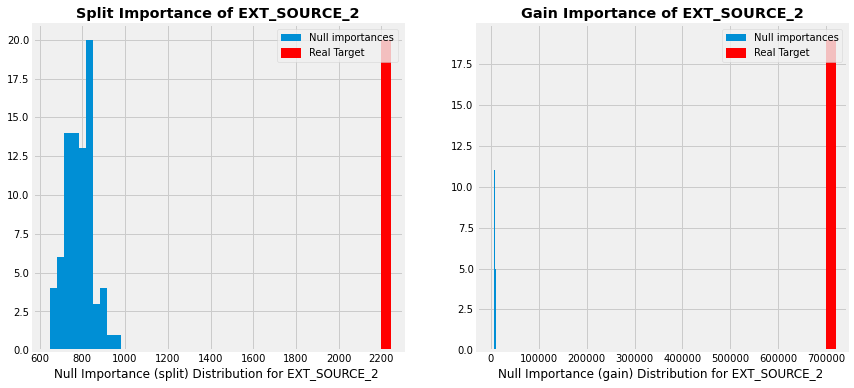

In [128]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='EXT_SOURCE_2')

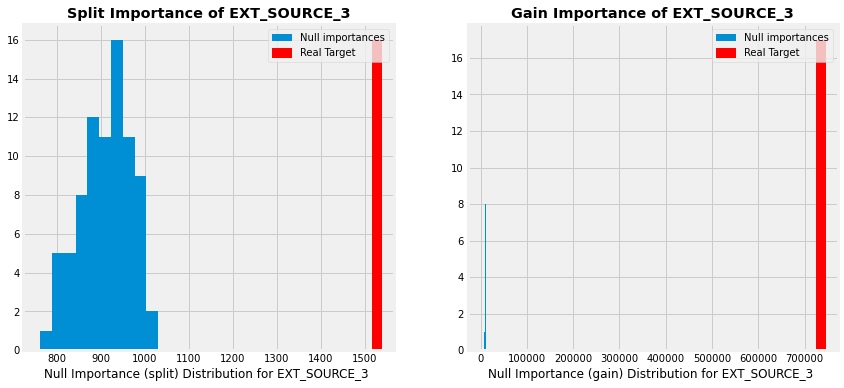

In [129]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='EXT_SOURCE_3')

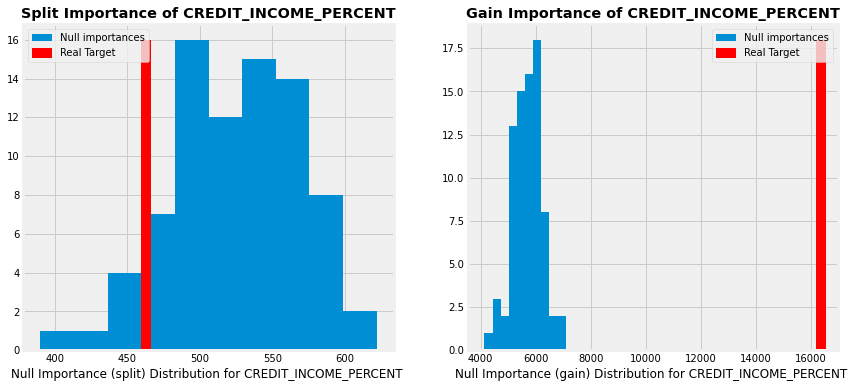

In [130]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='CREDIT_INCOME_PERCENT')

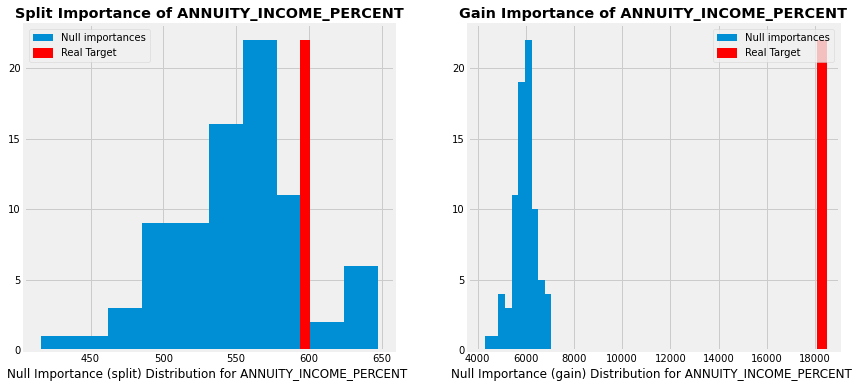

In [131]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='ANNUITY_INCOME_PERCENT')

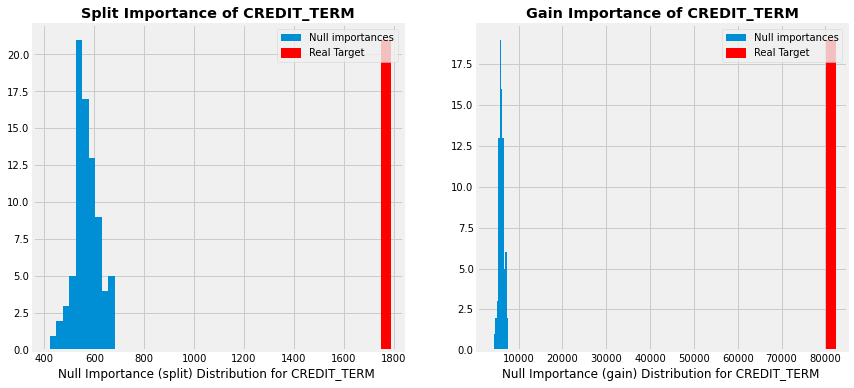

In [132]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='CREDIT_TERM')

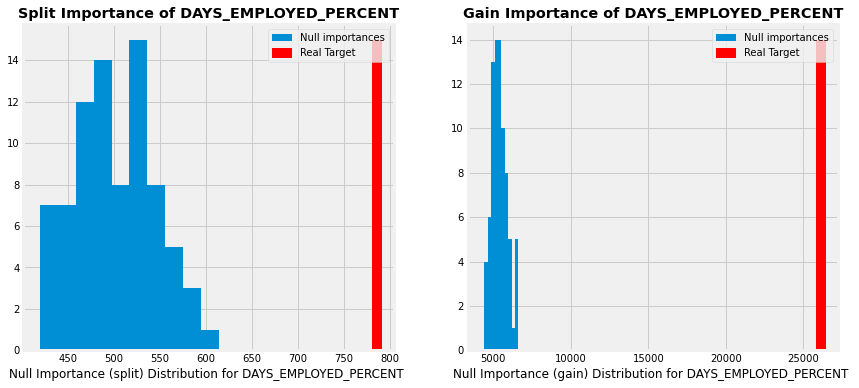

In [133]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='DAYS_EMPLOYED_PERCENT')

À partir du graphique ci-dessus, je pense que la puissance de la méthode de sélection des caractéristiques exposées est démontrée. En particulier, il est bien connu que :
- Toute variance suffisante peut être utilisée et rendue logique par les modèles d'arborescence. Vous pouvez toujours trouver des splits qui aident à mieux marquer Les caractéristiques corrélées ont des importances en décomposition une fois que l'une d'entre elles est utilisée par le modèle,
- La caractéristique choisie aura une forte importance et sa suite corrélée aura des importances en décomposition,
- <b>La méthode actuelle permet de :</b>
    - Supprimer les fonctionnalités à variance élevée si elles ne sont pas vraiment liées à la cible,
    - Supprimer le facteur de décomposition sur les caractéristiques corrélées, montrant leur importance réelle (ou leur importance impartiale)

## Score features

Il existe plusieurs façons de noter les fonctionnalités :
- Calculez le nombre d'échantillons dans les importances réelles qui sont éloignées de la distribution des importances nulles enregistrées.
- Calculer des ratios tels que Actual / Null Max, Actual / Null Mean, Actual Mean / Null Max

Dans une première étape, j'utiliserai le log actual feature importance divisée par le centile 75 de la distribution nulle.

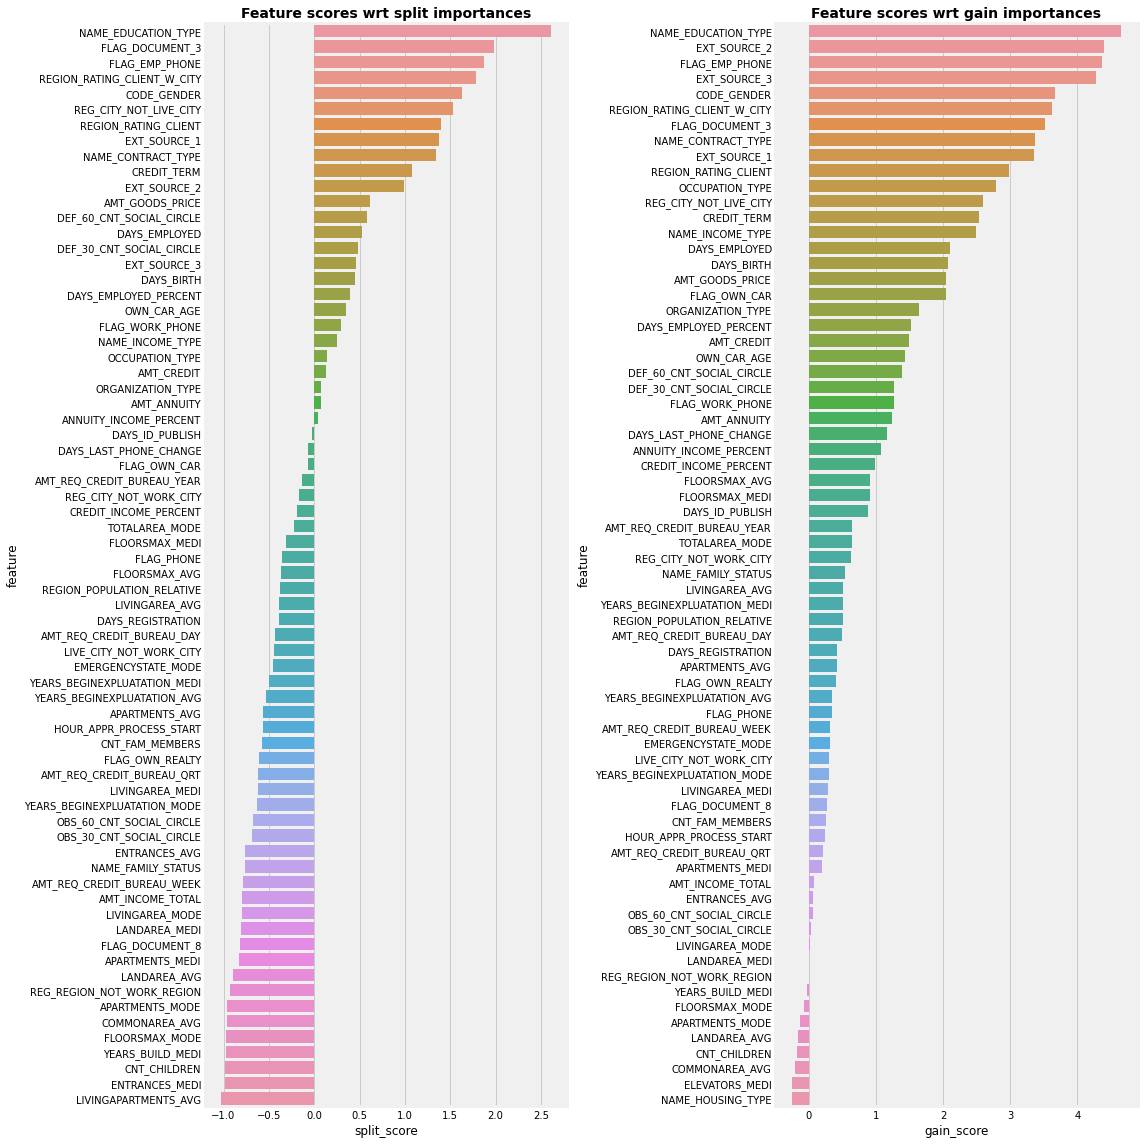

In [134]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

## Check the impact of removing uncorrelated features

Ici, je vais utiliser une métrique différente pour évaluer la corrélation avec la cible

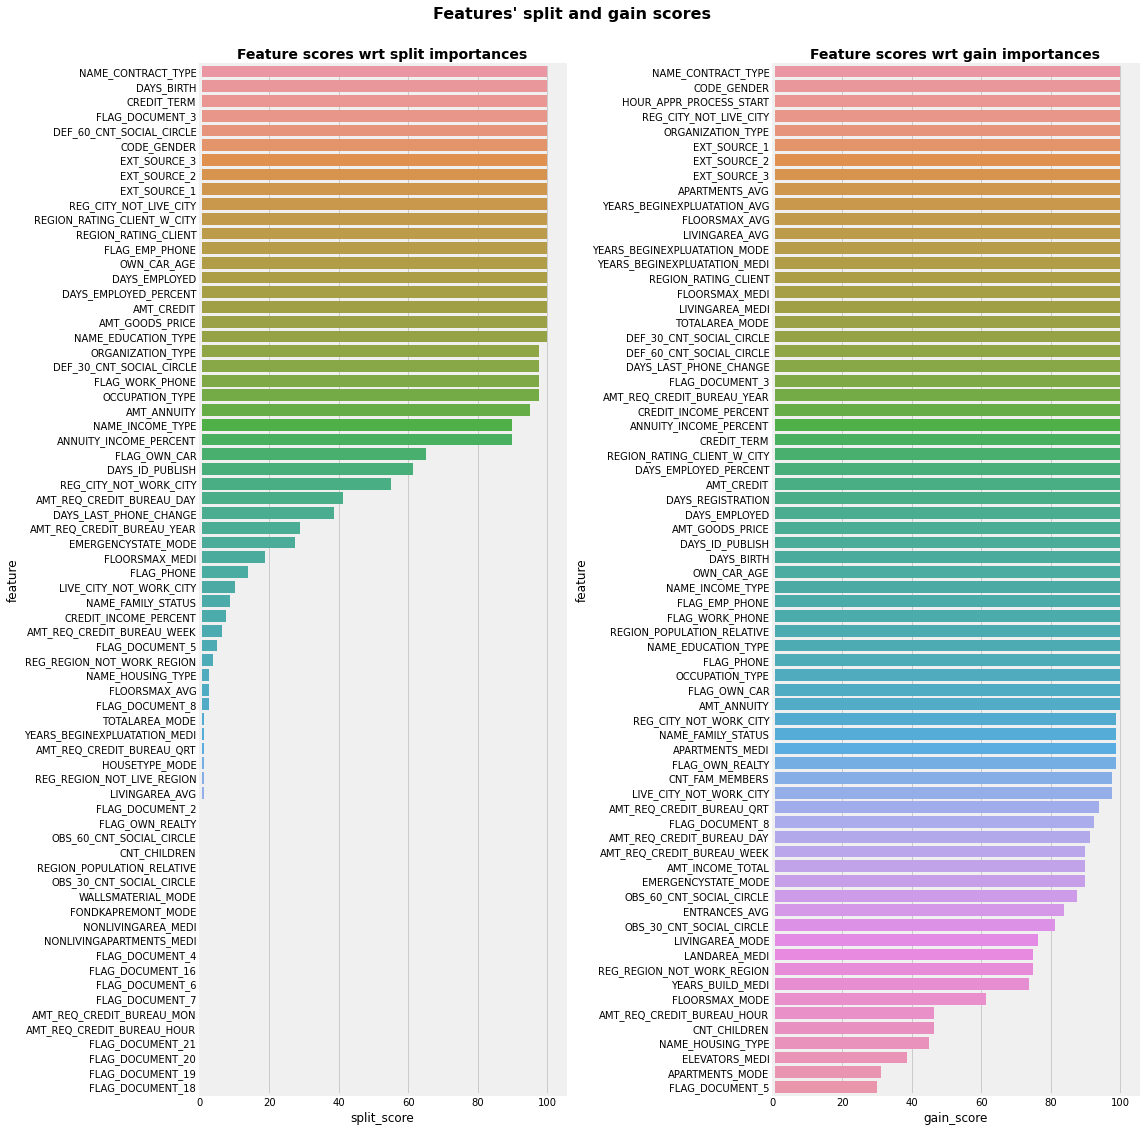

In [135]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

## Score feature removal for different thresholds

In [136]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc'
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['TARGET'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['TARGET'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold   0
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12321
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 120
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12321
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 120
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Warning] Auto-choosing row-w

## Feature selection par null importance par split score

### Imputation

In [137]:
# keep features only with feature importance by split score > 0
corr_scores_df_split_score = corr_scores_df.loc[corr_scores_df['split_score'] > 0]

# sort by split_score then by feature name, reset index
corr_scores_df_split_score = corr_scores_df_split_score.sort_values(by=['split_score', 'feature'], ascending=[False, True])
corr_scores_df_split_score.reset_index(drop=True, inplace=True)

In [138]:
print(corr_scores_df_split_score.shape)
corr_scores_df_split_score.head()

(50, 3)


feature  split_score  gain_score
0       AMT_CREDIT        100.0       100.0
1  AMT_GOODS_PRICE        100.0       100.0
2      CODE_GENDER        100.0       100.0
3      CREDIT_TERM        100.0       100.0
4       DAYS_BIRTH        100.0       100.0

In [139]:
columns_feature_importance_split_score = list(corr_scores_df_split_score['feature'])

data_feature_importance_split_score = data[['TARGET', 'SK_ID_CURR'] + columns_feature_importance_split_score]

In [140]:
data_feature_importance_split_score.isna().mean().value_counts()

0.000000    32
0.135016     4
0.000039     3
0.003320     2
0.497608     2
0.000904     1
0.563811     1
0.002146     1
0.198253     1
0.659908     1
0.000003     1
0.501933     1
0.482685     1
0.487810     1
dtype: int64

In [141]:
train_features = [f for f in data_feature_importance_split_score if f not in ['TARGET', 'SK_ID_CURR']]

# X = data_feature_importance_split_score[train_features]

# y = data['TARGET'].copy()

In [142]:
# if modelization is too long, take sample of dataset
# df_application_train_splitable = df_application_train.sample(frac=0.2, replace=False, random_state=42)

# if not too long or for computing all dataset
df_application_train_splitable = data_feature_importance_split_score.copy()

In [143]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

target = df_application_train_splitable['TARGET']

features = df_application_train_splitable.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Feature names
feature_names = list(features.columns)

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(features)

# Transform both training and testing data
features = imputer.transform(features)

# Repeat with the scaler
scaler.fit(features)
features = scaler.transform(features)

print('Training data shape: ', features.shape)

Training data shape:  (307511, 50)


In [144]:
np.count_nonzero(np.isnan(features))

0

### Séparer les données en train et test

In [145]:
from sklearn.model_selection import train_test_split

# Séparer X et y
# Séparer les données en train et test 80/20 avec train test split de sklearn
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size = 0.2, random_state = 0)

In [146]:
X_train.shape

(246008, 50)

In [147]:
X_test.shape

(61503, 50)

In [148]:
y_train.shape

(246008,)

### Santardiser les données d'entraînement

In [149]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler().fit(X_train)
X_scaled = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

### Entraînements, prédictions, scoring

#### LGBM Classifier

In [150]:
model_name = 'LightGBM Classifier'

# Train on the training data
# best_LGBM_classifier.fit(X_scaled, y_train)

In [151]:
computeFitPredictProbaOneClassifierOneY(best_LGBM_classifier, model_name, scoring, X_scaled, X_test_std, y_train, y_test, '4 Feature selection null importance split score', df_scores, n_jobs=6)

Fitting time in seconds: 2.7184739112854004
Execution time in seconds: 2.96

Step: 			 4 Feature selection null importance split score 
Model: 			 LightGBM Classifier 
best_params: 		 {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0005623413251903491, 'reg_lambda': 0.0031622776601683794, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Recall: 		 0.6919 
F1 score: 		 0.2633 
ROC_AUC: 		 0.7597 
Execution time: 	 2.9600s (0m  2.96s) 
Mean fit time: 	 2.72s (0m  2.72s) 
Mean score time:  0.24s (0m  0.24s) 


 [[39349 17299]
 [ 1496  3359]]

               precision    recall  f1-score   support

           0       0.96      0.69      0.81     56648
           1       0.16 

In [152]:
df_scores.loc[df_scores['Model'] == 'LightGBM Classifier']

Step                Model  \
4                                         0 Initial  LightGBM Classifier   
11                                   2 class_weight  LightGBM Classifier   
13                            3 Feature engineering  LightGBM Classifier   
15  4 Feature selection null importance split score  LightGBM Classifier   

                                          best_params    recall  F1-score  \
4   {'boosting_type': 'gbdt', 'class_weight': None...  0.015416  0.029940   
11  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.631038  0.251433   
13  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.651593  0.260370   
15  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.691864  0.263317   

     ROC_AUC  execution_time  mean_fit_time  mean_score_time  \
4   0.738876      575.357862        3276.77           132.07   
11  0.739702      887.912704        5237.40            54.16   
13  0.745118        1.270000           1.22             0.05   
15  0.759742        2.960000           2.72             0.24   

                                          predictions  
4   [0.2269374499911105, 0.076065362927037, 0.0678...  
11  [0.7977831733673173, 0.35674312132629116, 0.45...  
13  [0.8012274387338882, 0.3721689036232509, 0.458...  
15  [0.7920294160750874, 0.31691533966211155, 0.35...

Comparaison des temps d'entraînement et de prédictions et des scores Recall/F1/ROC_AUC par modèles pour la variable TARGET à l'étape 4 Feature selection null importance split score


<Figure size 1440x864 with 0 Axes>

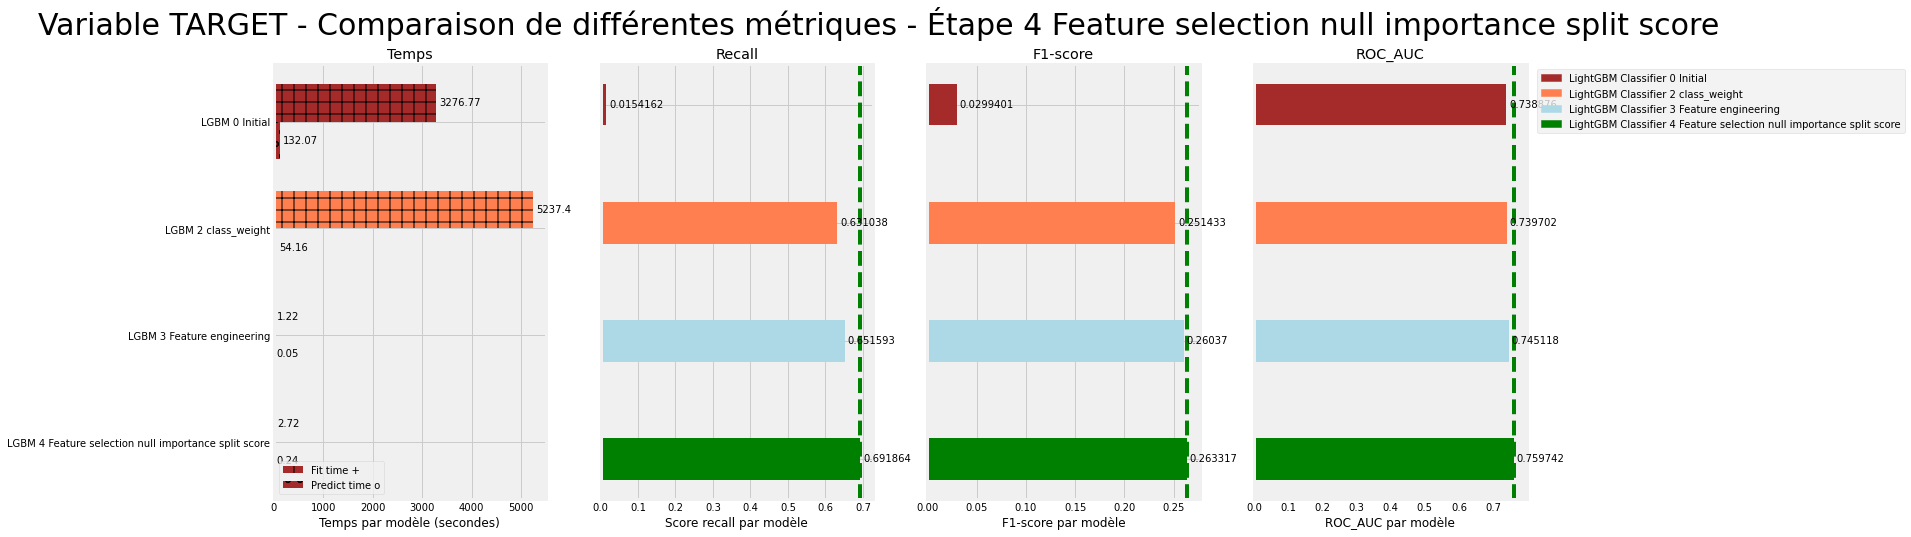

In [153]:
df_scores_lgbm = df_scores.loc[df_scores['Model'] == 'LightGBM Classifier'].reset_index(drop=True)

colors = []
for index, classifier_name in enumerate(df_scores_lgbm['Model']):
    colors.append(colors_arr[index])
colors

patches = []
for model, step, color in zip(df_scores_lgbm['Model'], df_scores_lgbm['Step'], colors):
    patches.append(mpatches.Patch(color=color, label=model + ' ' + step))

yticklabels = 'LGBM ' + df_scores_lgbm['Step']
    
displayTimesScoresComparisonForVariable('TARGET', df_scores_lgbm, colors, patches, yticklabels, step, step)

#### Decision Tree Classifier

In [154]:
model_name = 'Decision Tree Classifier'

# Train on the training data
# best_decision_tree_classifier.fit(X_scaled, y_train)

In [155]:
computeFitPredictProbaOneClassifierOneY(best_decision_tree_classifier, model_name, scoring, X_scaled, X_test_std, y_train, y_test, '4 Feature selection null importance split score', df_scores, n_jobs=6)

Fitting time in seconds: 2.348137140274048
Execution time in seconds: 2.36

Step: 			 4 Feature selection null importance split score 
Model: 			 Decision Tree Classifier 
best_params: 		 {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 11, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 
Recall: 		 0.6192 
F1 score: 		 0.2329 
ROC_AUC: 		 0.7054 
Execution time: 	 2.3600s (0m  2.36s) 
Mean fit time: 	 2.35s (0m  2.35s) 
Mean score time:  0.01s (0m  0.01s) 


 [[38698 17950]
 [ 1849  3006]]

               precision    recall  f1-score   support

           0       0.95      0.68      0.80     56648
           1       0.14      0.62      0.23      4855

    accuracy                           0.68     61503
   macro avg       0.55      0.65      0.51     61503
weighted avg       0.89      0.68      0.75

In [156]:
df_scores.loc[df_scores['Model'] == 'Decision Tree Classifier']

Step                     Model  \
2                                         0 Initial  Decision Tree Classifier   
9                                    2 class_weight  Decision Tree Classifier   
14                            3 Feature engineering  Decision Tree Classifier   
16  4 Feature selection null importance split score  Decision Tree Classifier   

                                          best_params    recall  F1-score  \
2   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  0.000000  0.000000   
9   {'ccp_alpha': 0.0, 'class_weight': 'balanced',...  0.677287  0.220438   
14  {'ccp_alpha': 0.0, 'class_weight': 'balanced',...  0.678314  0.221106   
16  {'ccp_alpha': 0.0, 'class_weight': 'balanced',...  0.619156  0.232924   

     ROC_AUC  execution_time  mean_fit_time  mean_score_time  \
2   0.691500       52.889139         295.32             4.19   
9   0.690978       50.589114         280.54             4.32   
14  0.691402        1.240000           1.23             0.01   
16  0.705364        2.360000           2.35             0.01   

                                          predictions  
2   [0.12148010239702117, 0.13855421686746988, 0.0...  
9   [0.6294307423351305, 0.6443037909077501, 0.509...  
14  [0.6294307423351305, 0.6443037909077501, 0.509...  
16  [0.7837181221129783, 0.12992769165510856, 0.78...

Comparaison des temps d'entraînement et de prédictions et des scores Recall/F1/ROC_AUC par modèles pour la variable TARGET à l'étape 4 Feature selection null importance split score


<Figure size 1440x864 with 0 Axes>

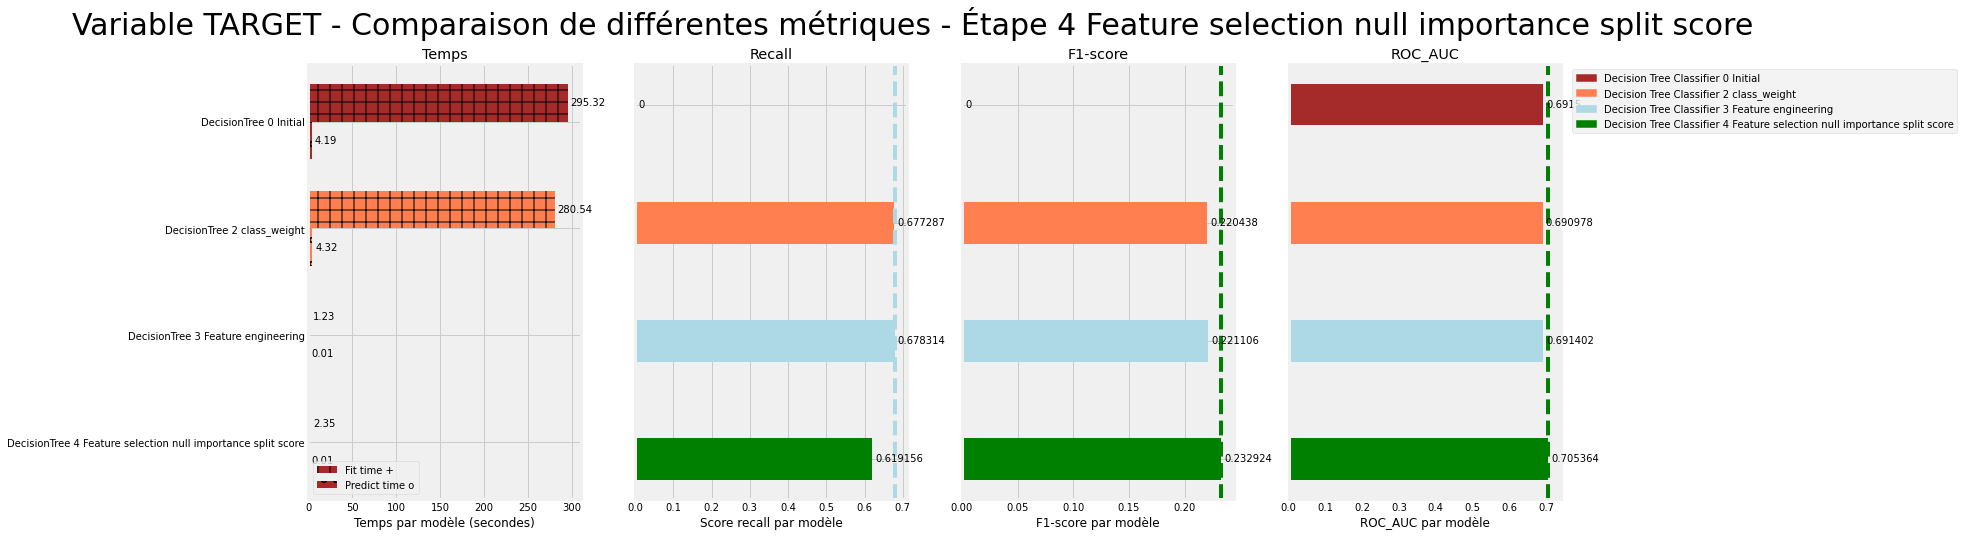

In [157]:
df_scores_dtree = df_scores.loc[df_scores['Model'] == 'Decision Tree Classifier'].reset_index(drop=True)

colors = []
for index, classifier_name in enumerate(df_scores_dtree['Model']):
    colors.append(colors_arr[index])
colors

patches = []
for model, step, color in zip(df_scores_dtree['Model'], df_scores_dtree['Step'], colors):
    patches.append(mpatches.Patch(color=color, label=model + ' ' + step))

yticklabels = 'DecisionTree ' + df_scores_dtree['Step']
    
displayTimesScoresComparisonForVariable('TARGET', df_scores_dtree, colors, patches, yticklabels, step, step)

## Feature selection par null importance par gain score

### Imputation

In [158]:
# keep features only with feature importance by gain score > 0
corr_scores_df_gain_score = corr_scores_df.loc[corr_scores_df['gain_score'] > 0]

# sort by gain_score then by feature name, reset index
corr_scores_df_gain_score = corr_scores_df_gain_score.sort_values(by=['gain_score', 'feature'], ascending=[False, True])
corr_scores_df_gain_score.reset_index(drop=True, inplace=True)

In [159]:
print(corr_scores_df_gain_score.shape)
corr_scores_df_gain_score.head()

(88, 3)


feature  split_score  gain_score
0                 AMT_ANNUITY        95.00       100.0
1                  AMT_CREDIT       100.00       100.0
2             AMT_GOODS_PRICE       100.00       100.0
3  AMT_REQ_CREDIT_BUREAU_YEAR        28.75       100.0
4      ANNUITY_INCOME_PERCENT        90.00       100.0

In [160]:
columns_feature_importance_gain_score = list(corr_scores_df_gain_score['feature'])

data_feature_importance_gain_score = data[['TARGET', 'SK_ID_CURR'] + columns_feature_importance_gain_score]

In [161]:
data_feature_importance_gain_score.isna().mean().value_counts()

0.000000    42
0.135016     6
0.003320     4
0.507497     3
0.664978     3
0.497608     3
0.501933     3
0.000039     3
0.487810     3
0.503488     2
0.683550     2
0.698723     2
0.532960     2
0.593767     2
0.551792     1
0.659908     1
0.000007     1
0.482685     1
0.198253     1
0.002146     1
0.563811     1
0.000003     1
0.000904     1
0.678486     1
dtype: int64

In [162]:
train_features = [f for f in data_feature_importance_gain_score if f not in ['TARGET', 'SK_ID_CURR']]

# X = data_feature_importance_gain_score[train_features]

# y = data['TARGET'].copy()

In [163]:
# if modelization is too long, take sample of dataset
# df_application_train_gainable = df_application_train.sample(frac=0.2, replace=False, random_state=42)

# if not too long or for computing all dataset
df_application_train_gainable = data_feature_importance_gain_score.copy()

In [164]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

target = df_application_train_gainable['TARGET']

features = df_application_train_gainable.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Feature names
feature_names = list(features.columns)

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(features)

# Transform both training and testing data
features = imputer.transform(features)

# Repeat with the scaler
scaler.fit(features)
features = scaler.transform(features)

print('Training data shape: ', features.shape)

Training data shape:  (307511, 88)


In [165]:
np.count_nonzero(np.isnan(features))

0

### Séparer les données en train et test

In [166]:
from sklearn.model_selection import train_test_split

# Séparer X et y
# Séparer les données en train et test 80/20 avec train test split de sklearn
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size = 0.2, random_state = 0)

In [167]:
X_train.shape

(246008, 88)

In [168]:
X_test.shape

(61503, 88)

In [169]:
y_train.shape

(246008,)

### Santardiser les données d'entraînement

In [170]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler().fit(X_train)
X_scaled = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

### Entraînements, prédictions, scoring

#### LGBM Classifier

In [171]:
model_name = 'LightGBM Classifier'

# Train on the training data
# best_LGBM_classifier.fit(X_scaled, y_train)

In [172]:
computeFitPredictProbaOneClassifierOneY(best_LGBM_classifier, model_name, scoring, X_scaled, X_test_std, y_train, y_test, '4 Feature selection null importance gain score', df_scores, n_jobs=6)

Fitting time in seconds: 4.333944797515869
Execution time in seconds: 4.58

Step: 			 4 Feature selection null importance gain score 
Model: 			 LightGBM Classifier 
best_params: 		 {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0005623413251903491, 'reg_lambda': 0.0031622776601683794, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Recall: 		 0.6894 
F1 score: 		 0.2633 
ROC_AUC: 		 0.7596 
Execution time: 	 4.5800s (0m  4.58s) 
Mean fit time: 	 4.33s (0m  4.33s) 
Mean score time:  0.25s (0m  0.25s) 


 [[39424 17224]
 [ 1508  3347]]

               precision    recall  f1-score   support

           0       0.96      0.70      0.81     56648
           1       0.16   

In [173]:
df_scores.loc[df_scores['Model'] == 'LightGBM Classifier']

Step                Model  \
4                                         0 Initial  LightGBM Classifier   
11                                   2 class_weight  LightGBM Classifier   
13                            3 Feature engineering  LightGBM Classifier   
15  4 Feature selection null importance split score  LightGBM Classifier   
17   4 Feature selection null importance gain score  LightGBM Classifier   

                                          best_params    recall  F1-score  \
4   {'boosting_type': 'gbdt', 'class_weight': None...  0.015416  0.029940   
11  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.631038  0.251433   
13  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.651593  0.260370   
15  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.691864  0.263317   
17  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.689392  0.263274   

     ROC_AUC  execution_time  mean_fit_time  mean_score_time  \
4   0.738876      575.357862        3276.77           132.07   
11  0.739702      887.912704        5237.40            54.16   
13  0.745118        1.270000           1.22             0.05   
15  0.759742        2.960000           2.72             0.24   
17  0.759603        4.580000           4.33             0.25   

                                          predictions  
4   [0.2269374499911105, 0.076065362927037, 0.0678...  
11  [0.7977831733673173, 0.35674312132629116, 0.45...  
13  [0.8012274387338882, 0.3721689036232509, 0.458...  
15  [0.7920294160750874, 0.31691533966211155, 0.35...  
17  [0.7899796659100292, 0.3134200722556585, 0.369...

Comparaison des temps d'entraînement et de prédictions et des scores Recall/F1/ROC_AUC par modèles pour la variable TARGET à l'étape 4 Feature selection null importance gain score


<Figure size 1440x864 with 0 Axes>

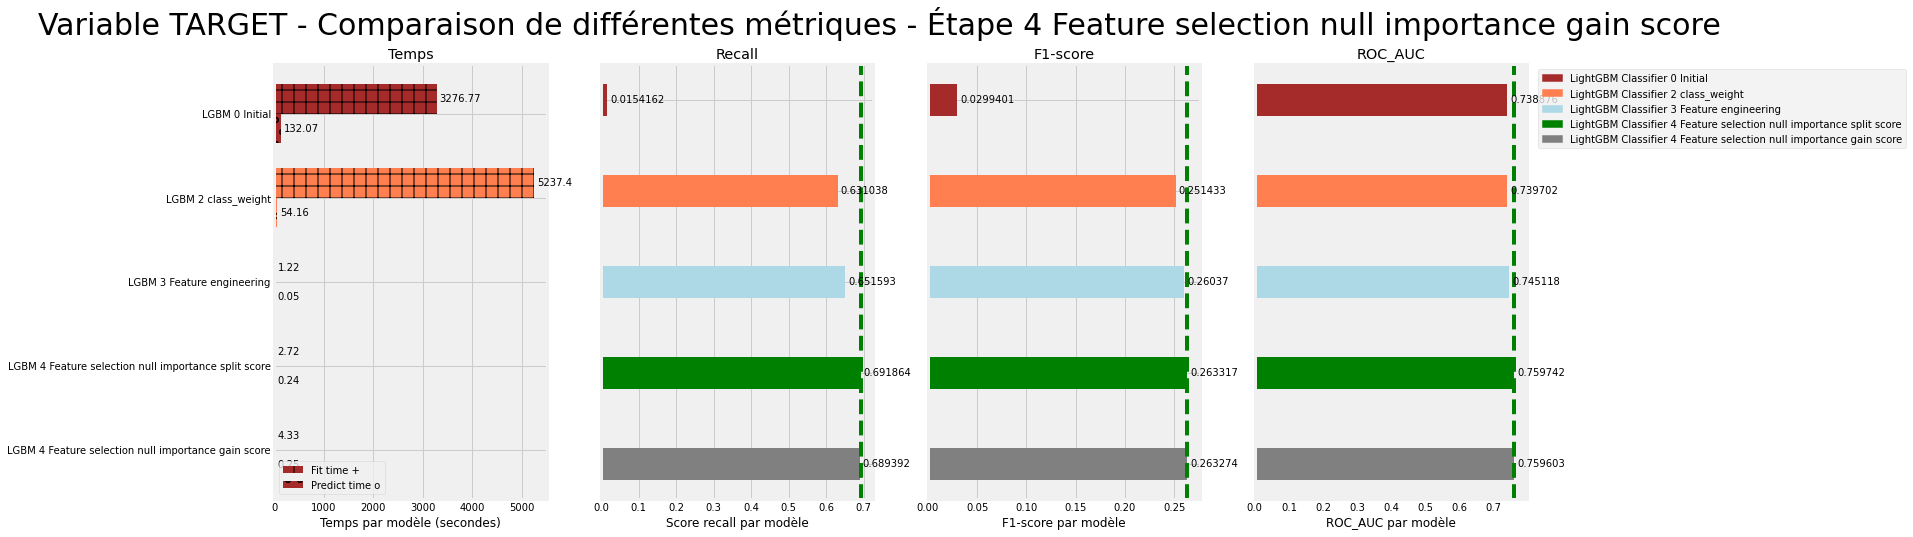

In [174]:
df_scores_lgbm = df_scores.loc[df_scores['Model'] == 'LightGBM Classifier'].reset_index(drop=True)

colors = []
for index, classifier_name in enumerate(df_scores_lgbm['Model']):
    colors.append(colors_arr[index])
colors

patches = []
for model, step, color in zip(df_scores_lgbm['Model'], df_scores_lgbm['Step'], colors):
    patches.append(mpatches.Patch(color=color, label=model + ' ' + step))

yticklabels = 'LGBM ' + df_scores_lgbm['Step']
    
displayTimesScoresComparisonForVariable('TARGET', df_scores_lgbm, colors, patches, yticklabels, step, step)

#### Decision Tree Classifier

In [175]:
model_name = 'Decision Tree Classifier'

# Train on the training data
# best_decision_tree_classifier.fit(X_scaled, y_train)

In [176]:
computeFitPredictProbaOneClassifierOneY(best_decision_tree_classifier, model_name, scoring, X_scaled, X_test_std, y_train, y_test, '4 Feature selection null importance gain score', df_scores, n_jobs=6)

Fitting time in seconds: 3.6653361320495605
Execution time in seconds: 3.69

Step: 			 4 Feature selection null importance gain score 
Model: 			 Decision Tree Classifier 
best_params: 		 {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 11, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 
Recall: 		 0.6192 
F1 score: 		 0.2329 
ROC_AUC: 		 0.7054 
Execution time: 	 3.6900s (0m  3.69s) 
Mean fit time: 	 3.67s (0m  3.67s) 
Mean score time:  0.02s (0m  0.02s) 


 [[38698 17950]
 [ 1849  3006]]

               precision    recall  f1-score   support

           0       0.95      0.68      0.80     56648
           1       0.14      0.62      0.23      4855

    accuracy                           0.68     61503
   macro avg       0.55      0.65      0.51     61503
weighted avg       0.89      0.68      0.75

In [177]:
df_scores.loc[df_scores['Model'] == 'Decision Tree Classifier']

Step                     Model  \
2                                         0 Initial  Decision Tree Classifier   
9                                    2 class_weight  Decision Tree Classifier   
14                            3 Feature engineering  Decision Tree Classifier   
16  4 Feature selection null importance split score  Decision Tree Classifier   
18   4 Feature selection null importance gain score  Decision Tree Classifier   

                                          best_params    recall  F1-score  \
2   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  0.000000  0.000000   
9   {'ccp_alpha': 0.0, 'class_weight': 'balanced',...  0.677287  0.220438   
14  {'ccp_alpha': 0.0, 'class_weight': 'balanced',...  0.678314  0.221106   
16  {'ccp_alpha': 0.0, 'class_weight': 'balanced',...  0.619156  0.232924   
18  {'ccp_alpha': 0.0, 'class_weight': 'balanced',...  0.619156  0.232924   

     ROC_AUC  execution_time  mean_fit_time  mean_score_time  \
2   0.691500       52.889139         295.32             4.19   
9   0.690978       50.589114         280.54             4.32   
14  0.691402        1.240000           1.23             0.01   
16  0.705364        2.360000           2.35             0.01   
18  0.705364        3.690000           3.67             0.02   

                                          predictions  
2   [0.12148010239702117, 0.13855421686746988, 0.0...  
9   [0.6294307423351305, 0.6443037909077501, 0.509...  
14  [0.6294307423351305, 0.6443037909077501, 0.509...  
16  [0.7837181221129783, 0.12992769165510856, 0.78...  
18  [0.7837181221129783, 0.12992769165510856, 0.78...

Comparaison des temps d'entraînement et de prédictions et des scores Recall/F1/ROC_AUC par modèles pour la variable TARGET à l'étape 4 Feature selection null importance gain score


<Figure size 1440x864 with 0 Axes>

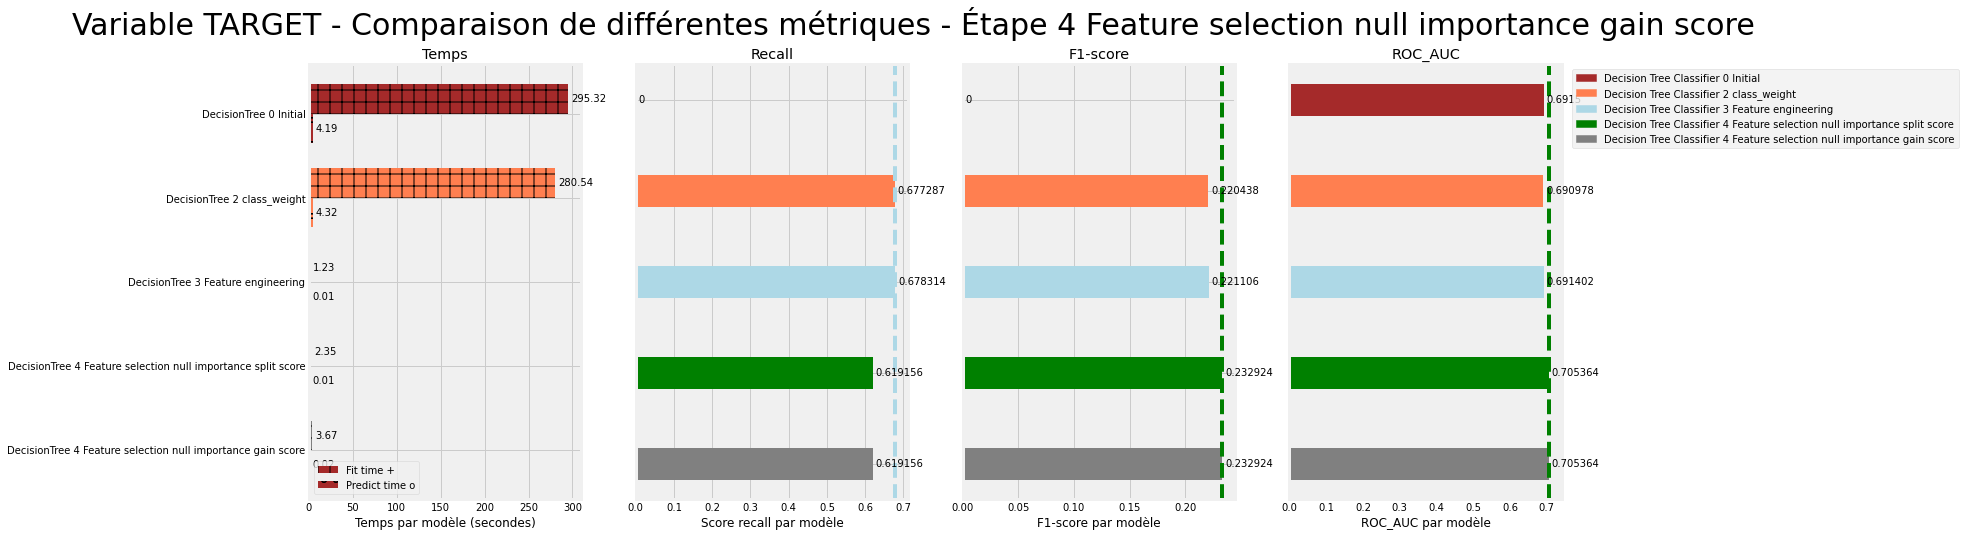

In [178]:
df_scores_dtree = df_scores.loc[df_scores['Model'] == 'Decision Tree Classifier'].reset_index(drop=True)

colors = []
for index, classifier_name in enumerate(df_scores_dtree['Model']):
    colors.append(colors_arr[index])
colors

patches = []
for model, step, color in zip(df_scores_dtree['Model'], df_scores_dtree['Step'], colors):
    patches.append(mpatches.Patch(color=color, label=model + ' ' + step))

yticklabels = 'DecisionTree ' + df_scores_dtree['Step']
    
displayTimesScoresComparisonForVariable('TARGET', df_scores_dtree, colors, patches, yticklabels, step, step)

## Récapitulatif des améliorations

<b>Cette étape est validée si ROC AUC augmente même légèrement et pas de diminution sur les autres métriques.</b>

In [179]:
print('Feature importance > 0 by split_score : ', len(scores_df.loc[scores_df['split_score'] > 0 ]))
scores_df.loc[scores_df['split_score'] > 0 ].sort_values(by='split_score', ascending=False).head(15)

Feature importance > 0 by split_score :  26


feature  split_score  gain_score
11           NAME_EDUCATION_TYPE     2.605223    4.652609
95               FLAG_DOCUMENT_3     1.983521    3.511560
21                FLAG_EMP_PHONE     1.871802    4.368916
29   REGION_RATING_CLIENT_W_CITY     1.783791    3.620349
1                    CODE_GENDER     1.624874    3.674420
35        REG_CITY_NOT_LIVE_CITY     1.524764    2.597479
28          REGION_RATING_CLIENT     1.398953    2.985768
39                  EXT_SOURCE_1     1.375101    3.348713
0             NAME_CONTRACT_TYPE     1.341174    3.373428
122                  CREDIT_TERM     1.083473    2.530822
40                  EXT_SOURCE_2     0.985488    4.395129
8                AMT_GOODS_PRICE     0.618991    2.041343
92      DEF_60_CNT_SOCIAL_CIRCLE     0.577634    1.392373
16                 DAYS_EMPLOYED     0.521699    2.110427
90      DEF_30_CNT_SOCIAL_CIRCLE     0.484392    1.275004

In [180]:
print('Feature importance > 0 by gain_score : ', len(scores_df.loc[scores_df['gain_score'] > 0 ]))
scores_df.loc[scores_df['gain_score'] > 0 ].sort_values(by='gain_score', ascending=False).head(15)

Feature importance > 0 by gain_score :  61


feature  split_score  gain_score
11           NAME_EDUCATION_TYPE     2.605223    4.652609
40                  EXT_SOURCE_2     0.985488    4.395129
21                FLAG_EMP_PHONE     1.871802    4.368916
41                  EXT_SOURCE_3     0.465952    4.275812
1                    CODE_GENDER     1.624874    3.674420
29   REGION_RATING_CLIENT_W_CITY     1.783791    3.620349
95               FLAG_DOCUMENT_3     1.983521    3.511560
0             NAME_CONTRACT_TYPE     1.341174    3.373428
39                  EXT_SOURCE_1     1.375101    3.348713
28          REGION_RATING_CLIENT     1.398953    2.985768
26               OCCUPATION_TYPE     0.145048    2.788735
35        REG_CITY_NOT_LIVE_CITY     1.524764    2.597479
122                  CREDIT_TERM     1.083473    2.530822
10              NAME_INCOME_TYPE     0.251314    2.483968
16                 DAYS_EMPLOYED     0.521699    2.110427

In [181]:
# list(scores_df.loc[scores_df['split_score'] > 0 ]['feature'])

In [182]:
# list(scores_df.loc[scores_df['gain_score'] > 0 ]['feature'])

# Adaptation de la métrique au métier

- Création d'une métrique en lien avec le besoin métier puis rechercher les hyper-paramètres avec cette fonction
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
- Ajouter une nouvelle colonne dans le tableau des performances pour mesurer l'amélioration du f-beta score
- Récapitulatif des améliorations

## Nouvelle métrique

In [183]:
from sklearn.metrics import fbeta_score, make_scorer

ftwo_scorer = make_scorer(fbeta_score, beta=2)
ftwo_scorer

make_scorer(fbeta_score, beta=2)

## Mise à jour de l'automatisation

### Objets

In [184]:
# scores : recall, F1-score, AUC, F-beta et matrice de confusion
updated_data_models_scores = {'Step': [], 'Model': [], 'best_params': [], 'recall': [], 'F1-score': [], 'ROC_AUC': [], 'F-beta-score': [], 'execution_time': [], 'mean_fit_time': [], 'mean_score_time': [], 'predictions': []}

### Méthodes

In [185]:
def computeScoresPredictionsUpdated(model_name, best_params, y_test, y_pred, step, df_scores, execution_time, mean_fit_time, mean_score_time, score_test_fbeta):
        
    # y_pred contains probability, need to choose class depending on threshold
    # take 0.5 for now :
    threshold = 0.5
    
    # if prediction is 0.5, client has same chance of repaying than defaulting the loan
    # from bank perspective, it's better not to take the chance to lose money, so don't loan = class 1
    # if pred < 0.5, class 0 the loan was repaid on time
    # else pred >= 0.5, class 1 the client had payment difficulties
    y_pred_binarized = np.where(np.array(y_pred) >= threshold, 1, 0)
    
    # calculate recall : tp / (tp + fn)
    recall = recall_score(y_test, y_pred_binarized)

    # calculate F1 score : 2 * (precision * recall) / (precision + recall)
    f1 = f1_score(y_test, y_pred_binarized)

    # calculate ROC_AUC
    roc_auc = roc_auc_score(y_test, y_pred)
    
    print('\nStep: \t\t\t', step,
            '\nModel: \t\t\t', model_name,
            '\nbest_params: \t\t', best_params,
            '\nRecall: \t\t', "{:.4f}".format(recall),
            '\nF1 score: \t\t', "{:.4f}".format(f1),
            '\nROC_AUC: \t\t', "{:.4f}".format(roc_auc),
            '\nF-beta: \t\t', "{:.4f}".format(score_test_fbeta),
            '\nExecution time: \t', "{:.4f}s".format(execution_time), "({:}m ".format(int(execution_time / 60)), "{:.2f}s)".format(round((execution_time - (60 * int(execution_time / 60))) % 60, 2)),
            '\nMean fit time: \t', "{:.2f}s".format(mean_fit_time), "({:}m ".format(int(mean_fit_time / 60)), "{:.2f}s)".format(round((mean_fit_time - (60 * int(mean_fit_time / 60))) % 60, 2)),
            '\nMean score time: ', "{:.2f}s".format(mean_score_time), "({:}m ".format(int(mean_score_time / 60)), "{:.2f}s)".format(round((mean_score_time - (60 * int(mean_score_time / 60))) % 60, 2)),
            '\n')
    
    print('\n', confusion_matrix(y_test, y_pred_binarized))
    print('\n', classification_report(y_test, y_pred_binarized))
    
    # add new row to end of DataFrame
    df_scores.loc[len(df_scores.index)] = [step, model_name, best_params, recall, f1, roc_auc, score_test_fbeta, execution_time, mean_fit_time, mean_score_time, y_pred]

In [186]:
import time

def computeGridSearchCVOneClassifierOneYUpdated(model, model_name, param_grid, n_folds, scoring, X_train, X_test, y_train, y_test, step, df_scores, n_jobs):
    
    startTime = time.time()
    
    # GridSearchCV
    gscv = GridSearchCV(model, param_grid, cv=n_folds, scoring=scoring, n_jobs=n_jobs)
    
    # Lancer l'entraînement du model pour la variable
    gscv.fit(X_train, y_train)
    
    # Score du model sur la variable
    score_train = gscv.score(X_train, y_train)
    
    # Calculer les performances sur la base de test avec score
    score_test_fbeta = gscv.score(X_test, y_test)

    # Prédictions sur les variables de test
    # Now that the model has been trained, we can use it to make predictions.
    # We want to predict the probabilities of not paying a loan, so we use the model predict.proba method.
    # This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1).
    # We want the probability the loan is not repaid, so we will select the second column.
    y_pred_proba = gscv.predict_proba(X_test)[:, 1]
    # y_pred = gscv.predict(X_test)
    
    cv_results = gscv.cv_results_
    best_estimator = gscv.best_estimator_

    executionTime = (time.time() - startTime)
    
    # Temps d'entraînement 
    mean_fit_time = round(gscv.cv_results_['mean_fit_time'].mean() * gscv.n_splits_ * gscv.cv_results_['mean_fit_time'].shape[0], 2)    
    
    # Temps de prédiction 
    mean_score_time = round(gscv.cv_results_['mean_score_time'].mean() * gscv.n_splits_ * gscv.cv_results_['mean_fit_time'].shape[0], 2)
    
    print('Execution time in seconds: ' + str(executionTime))
    
    # Calcul des résultats
    computeScoresPredictionsUpdated(model_name, best_estimator.get_params(), y_test, y_pred_proba, step, df_scores, executionTime, mean_fit_time, mean_score_time, score_test_fbeta)    

    return best_estimator, y_pred_proba, cv_results

In [187]:
def gridSearchCVOneClassifierOneYUpdated(model, model_name, param_grid, n_folds, scoring, X_train, X_test, y_train, y_test, step, df_scores, n_jobs, logScale, graphics):
            
    # Résultats
    results = dict()
        
    # Entraînement, CV, sélection des meilleurs hyperparamètres, calcul des scores et prédictions
    best_estimator, y_pred, cv_results = computeGridSearchCVOneClassifierOneYUpdated(model, model_name, param_grid, n_folds, scoring, X_train, X_test, y_train, y_test, step, df_scores, n_jobs)

    # Enregistrement des résultats
    results = dict(best_estimator=best_estimator, y_pred=y_pred, cv_results=cv_results)

    # Affichage
    if graphics:
        fig, ax = plt.subplots(figsize=(15, 12))
        plt.title(step + ' - ' + model_name + ' - ' + variable_name + ' - Nuage de points valeurs réelles/prédites')
        plt.ylabel('Valeurs réelles')
        plt.xlabel('Valeurs prédites')

        if logScale:
            ax.set_xscale("log")
            ax.set_yscale("log")

        # Affichage des valeurs prédites en fonction des valeurs réelles 
        # axs[index].scatter(actual, predicted, color='coral')
        plt.scatter(y_test, y_pred, color='coral', label=model_name + ' - ' + variable_name)

        # Affichage de la diagonale entre la valeur min et la valeur max réelle
        y_test_min = y_test.min()
        y_test_max = y_test.max()
        plt.plot([y_test_min, y_test_max], [y_test_min, y_test_max], linestyle='--', color='blue', alpha=0.8, label="Diagonale entre la valeur min et la valeur max réelle")

        plt.legend(loc = 'lower right')
        plt.show()
        
    # retourne les résultats pour les multiples y de la recherche CV pour ce regresseur
    return results

In [188]:
import matplotlib.patches as mpatches

def displayTimesScoresComparisonForVariableUpdated(variable, df_scores_, colors, patches, yticklabels, step, filename_key):
    # graphique
    fig = plt.figure(figsize=(20, 12))

    print('Comparaison des temps d\'entraînement et de prédictions et des scores Recall/F1/ROC_AUC/F-beta par modèles pour la variable {} à l\'étape {}'.format(variable, step))

    # use default palette colors
    # sns.set_palette(default_colors_palette)

    y = np.arange(len(df_scores_['Model'].index))
    width = 0.35

    fig, ax = plt.subplots(1, 5, figsize=(20,8), sharey=False, sharex=False)
    # fig.subplots_adjust(top=0.8)
    # fig.tight_layout()
    # fig.subplots_adjust(wspace=0.6)

    # Temps de Train/Test
    train = ax[0].barh(y - width/2, df_scores_['mean_fit_time'], width, color=colors, hatch="+", label='Fit time +')
    test = ax[0].barh(y + width/2, df_scores_['mean_score_time'], width, color=colors, hatch="o", label='Predict time o')
    ax[0].set_xlabel('Temps par modèle (secondes)')
    ax[0].set_title('Temps')
    ax[0].set_yticks(y)
    ax[0].set_yticklabels(yticklabels)
    ax[0].invert_yaxis()  # labels read top-to-bottom
    ax[0].legend()
    # patches_copy = patches.copy()
    # patches_copy.insert(0, mpatches.Patch(label="Fit pattern", hatch="o"))
    # patches_copy.insert(1, mpatches.Patch(label="Train pattern", hatch="+"))
    # plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", handles=patches)
    ax[0].bar_label(test, padding=3)
    ax[0].bar_label(train, padding=3)
    
    # Scores Recall
    scores1 = ax[1].barh(y, df_scores_['recall'], width, color=colors)
    ax[1].set_xlabel('Score recall par modèle')
    ax[1].set_title('Recall')
    ax[1].set_yticks(y)
    ax[1].set_yticklabels(yticklabels)
    ax[1].invert_yaxis()  # labels read top-to-bottom
    ax[1].tick_params(labelleft=False)
    # ax[1].legend(handles=patches)
    ax[1].bar_label(scores1, padding=3)
    ax[1].axvline(x=max(df_scores_['recall']), color=colors[df_scores_.loc[df_scores_['recall'] == df_scores_['recall'].max(axis=0), :].index[0]], linestyle='--')
    
    # Scores F1
    scores2 = ax[2].barh(y, df_scores_['F1-score'], width, color=colors)
    ax[2].set_xlabel('F1-score par modèle')
    ax[2].set_title('F1-score')
    ax[2].set_yticks(y)
    ax[2].set_yticklabels(yticklabels)
    ax[2].invert_yaxis()  # labels read top-to-bottom
    ax[2].tick_params(labelleft=False)
    # ax[2].legend(handles=patches)
    ax[2].bar_label(scores2, padding=3)
    ax[2].axvline(x=max(df_scores_['F1-score']), color=colors[df_scores_.loc[df_scores_['F1-score'] == df_scores_['F1-score'].max(axis=0), :].index[0]], linestyle='--')
    
    # Scores ROC_AUC
    scores3 = ax[3].barh(y, df_scores_['ROC_AUC'], width, color=colors)
    ax[3].set_xlabel('ROC_AUC par modèle')
    ax[3].set_title('ROC_AUC')
    ax[3].set_yticks(y)
    ax[3].set_yticklabels(yticklabels)
    ax[3].invert_yaxis()  # labels read top-to-bottom
    ax[3].tick_params(labelleft=False)
    # ax[3].legend(handles=patches)
    ax[3].bar_label(scores3, padding=3)
    ax[3].axvline(x=max(df_scores_['ROC_AUC']), color=colors[df_scores_.loc[df_scores_['ROC_AUC'] == df_scores_['ROC_AUC'].max(axis=0), :].index[0]], linestyle='--')
    
    # Scores F-beta
    scores4 = ax[4].barh(y, df_scores_['F-beta-score'], width, color=colors)
    ax[4].set_xlabel('F-beta-score par modèle')
    ax[4].set_title('F-beta-score')
    ax[4].set_yticks(y)
    ax[4].set_yticklabels(yticklabels)
    ax[4].invert_yaxis()  # labels read top-to-bottom
    ax[4].tick_params(labelleft=False)
    # ax[4].legend(handles=patches)
    ax[4].bar_label(scores4, padding=3)
    ax[4].axvline(x=max(df_scores_['F-beta-score']), color=colors[df_scores_.loc[df_scores_['F-beta-score'] == df_scores_['F-beta-score'].max(axis=0), :].index[0]], linestyle='--')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", handles=patches)
    
    fig.suptitle('Variable {} - Comparaison de différentes métriques - Étape {}'.format(variable, step), fontsize=30, y=0.98)

    plt.savefig('20-Groupedbar-times-scores-models-{}-for-{}-300dpi.png'.format(filename_key, variable), dpi=300, bbox_inches='tight', pad_inches=0)

    plt.grid()
    plt.show()

# Ré-apprendre le meilleur modèle sur le train set complet

Le meilleur model est le LGBM Classifier.

In [189]:
def keepOnlyFeaturesWithImportanceAboveThreshold(df, importance_feature, threshold):
    
    # keep features only with feature importance by split score > 0
    corr_scores_df_importance_feature = corr_scores_df.loc[corr_scores_df[importance_feature] > 0]

    # sort by split_score then by feature name, reset index
    corr_scores_df_importance_feature = corr_scores_df_importance_feature.sort_values(by=[importance_feature, 'feature'], ascending=[False, True])
    corr_scores_df_importance_feature.reset_index(drop=True, inplace=True)
    
    print('{} Features having "{}" above "{}"'.format(corr_scores_df_importance_feature.shape[0], importance_feature, threshold))
    print(corr_scores_df_importance_feature.head())
    
    columns_feature_importance_split_score = list(corr_scores_df_split_score['feature'])

    return columns_feature_importance_split_score

In [190]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
    
def imputeData(data, target, feature_id):
    print('Imputation')
    
    features = data.drop(columns = [target, feature_id])

    # Feature names
    feature_names = list(features.columns)

    # Median imputation of missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))

    # Fit on the training data
    imputer.fit(features)

    # Transform both training and testing data
    features = imputer.transform(features)

    # Repeat with the scaler
    scaler.fit(features)
    features = scaler.transform(features)

    print('Training data shape: ', features.shape)
    
    return features

In [191]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def superMethodQuiFaitLeCafe(data, column_names, test_size, n_folds, scoring, step, classifiers_cv, df_scores, n_jobs=6, logScale=False, graphics=False):
    
    # Données à traiter
    features = data[column_names]
    print('\nFeatures: \t', features.shape)
        
    # Target
    target = features['TARGET']
    print('Target: \t', target.shape)
        
    # Imputation
    features_imputed = imputeData(features, 'TARGET', 'SK_ID_CURR')
    
    # Séparer X et y
    # Séparer les données en train et test 80/20 avec train test split de sklearn
    X_train, X_test, y_train, y_test = train_test_split(features_imputed,
                                                        target,
                                                        test_size = test_size, random_state = 0)
    
    print('\nX_train: \t', X_train.shape)
    print('X_test: \t', X_test.shape)
    print('y_train: \t', y_train.shape)
    
    # Standardisation
    std_scale = StandardScaler().fit(X_train)
    X_scaled = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)
    
    # GridSearchCV and best results
    for model_name in classifiers_cv:
        print('GridSearchCV for: \t', model_name)
        classifiers_cv_results = gridSearchCVOneClassifierOneYUpdated(classifiers_cv[model_name]['classifier'], model_name, classifiers_cv[model_name]['param_grid'], n_folds, scoring, X_scaled, X_test_std, y_train, y_test, step, df_scores, n_jobs=6, logScale=False, graphics=False)

    return classifiers_cv_results, X_scaled, X_test_std, y_train, y_test

In [192]:
import lightgbm as lgb

# Feature selection par null importance : par split_score supérieur à 0
columns_feature_importance_split_score = keepOnlyFeaturesWithImportanceAboveThreshold(corr_scores_df, 'split_score', 0)

df_scores_fbeta = pd.DataFrame(data=updated_data_models_scores)

model_name = 'LightGBM Classifier'

# Préparation du dictionnaire contenant les models et leurs paramètres pour la recherche croisée    
classifiers_cv = {'LightGBM Classifier': {
        'classifier': lgb.LGBMClassifier(),
        'color': 'violet',
        'param_grid': # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
            {'learning_rate': [.03, .05, .07],
             'n_estimators': [500],
             'max_depth': [1, 2, 3],
             'reg_alpha': np.logspace(-4, -1, 5),
             'reg_lambda': np.logspace(-4, -1, 5),
             'class_weight': class_weight_params}
    }
}

classifiers_cv_results_fbeta, X_scaled, X_test_std, y_train, y_test = superMethodQuiFaitLeCafe(data=data,
                                                                                                column_names=['TARGET', 'SK_ID_CURR'] + columns_feature_importance_split_score,
                                                                                                test_size=0.2,
                                                                                                n_folds=5,
                                                                                                scoring=ftwo_scorer,
                                                                                                step='5 F-beta score',
                                                                                                classifiers_cv=classifiers_cv,
                                                                                                df_scores=df_scores_fbeta,
                                                                                                n_jobs=6,
                                                                                                logScale=False,
                                                                                                graphics=False)

50 Features having "split_score" above "0"
           feature  split_score  gain_score
0       AMT_CREDIT        100.0       100.0
1  AMT_GOODS_PRICE        100.0       100.0
2      CODE_GENDER        100.0       100.0
3      CREDIT_TERM        100.0       100.0
4       DAYS_BIRTH        100.0       100.0

Features: 	 (307511, 52)
Target: 	 (307511,)
Imputation
Training data shape:  (307511, 50)

X_train: 	 (246008, 50)
X_test: 	 (61503, 50)
y_train: 	 (246008,)
GridSearchCV for: 	 LightGBM Classifier
Execution time in seconds: 1223.4905376434326

Step: 			 5 F-beta score 
Model: 			 LightGBM Classifier 
best_params: 		 {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.07, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.1, 'reg_lambda': 0.0005623413251903491, 's

In [193]:
df_scores_fbeta

Step                Model  \
0  5 F-beta score  LightGBM Classifier   

                                         best_params   recall  F1-score  \
0  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.69104  0.269901   

    ROC_AUC  F-beta-score  execution_time  mean_fit_time  mean_score_time  \
0  0.766817      0.425481     1223.490538        6632.59           612.79   

                                         predictions  
0  [0.837636236452578, 0.3069489577327195, 0.3653...

In [194]:
df_scores_updated = df_scores.copy()
df_scores_updated['F-beta-score'] = np.nan

# Concat
df_scores_updated = pd.concat([df_scores_updated, df_scores_fbeta], axis=0)

In [195]:
df_scores_updated.loc[df_scores_updated['Model'] == 'LightGBM Classifier'].sort_values(by='F-beta-score', ascending=False)

Step                Model  \
0                                    5 F-beta score  LightGBM Classifier   
4                                         0 Initial  LightGBM Classifier   
11                                   2 class_weight  LightGBM Classifier   
13                            3 Feature engineering  LightGBM Classifier   
15  4 Feature selection null importance split score  LightGBM Classifier   
17   4 Feature selection null importance gain score  LightGBM Classifier   

                                          best_params    recall  F1-score  \
0   {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.691040  0.269901   
4   {'boosting_type': 'gbdt', 'class_weight': None...  0.015416  0.029940   
11  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.631038  0.251433   
13  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.651593  0.260370   
15  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.691864  0.263317   
17  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.689392  0.263274   

     ROC_AUC  execution_time  mean_fit_time  mean_score_time  \
0   0.766817     1223.490538        6632.59           612.79   
4   0.738876      575.357862        3276.77           132.07   
11  0.739702      887.912704        5237.40            54.16   
13  0.745118        1.270000           1.22             0.05   
15  0.759742        2.960000           2.72             0.24   
17  0.759603        4.580000           4.33             0.25   

                                          predictions  F-beta-score  
0   [0.837636236452578, 0.3069489577327195, 0.3653...      0.425481  
4   [0.2269374499911105, 0.076065362927037, 0.0678...           NaN  
11  [0.7977831733673173, 0.35674312132629116, 0.45...           NaN  
13  [0.8012274387338882, 0.3721689036232509, 0.458...           NaN  
15  [0.7920294160750874, 0.31691533966211155, 0.35...           NaN  
17  [0.7899796659100292, 0.3134200722556585, 0.369...           NaN

Comparaison des temps d'entraînement et de prédictions et des scores Recall/F1/ROC_AUC/F-beta par modèles pour la variable TARGET à l'étape 5 F-beta score


<Figure size 1440x864 with 0 Axes>

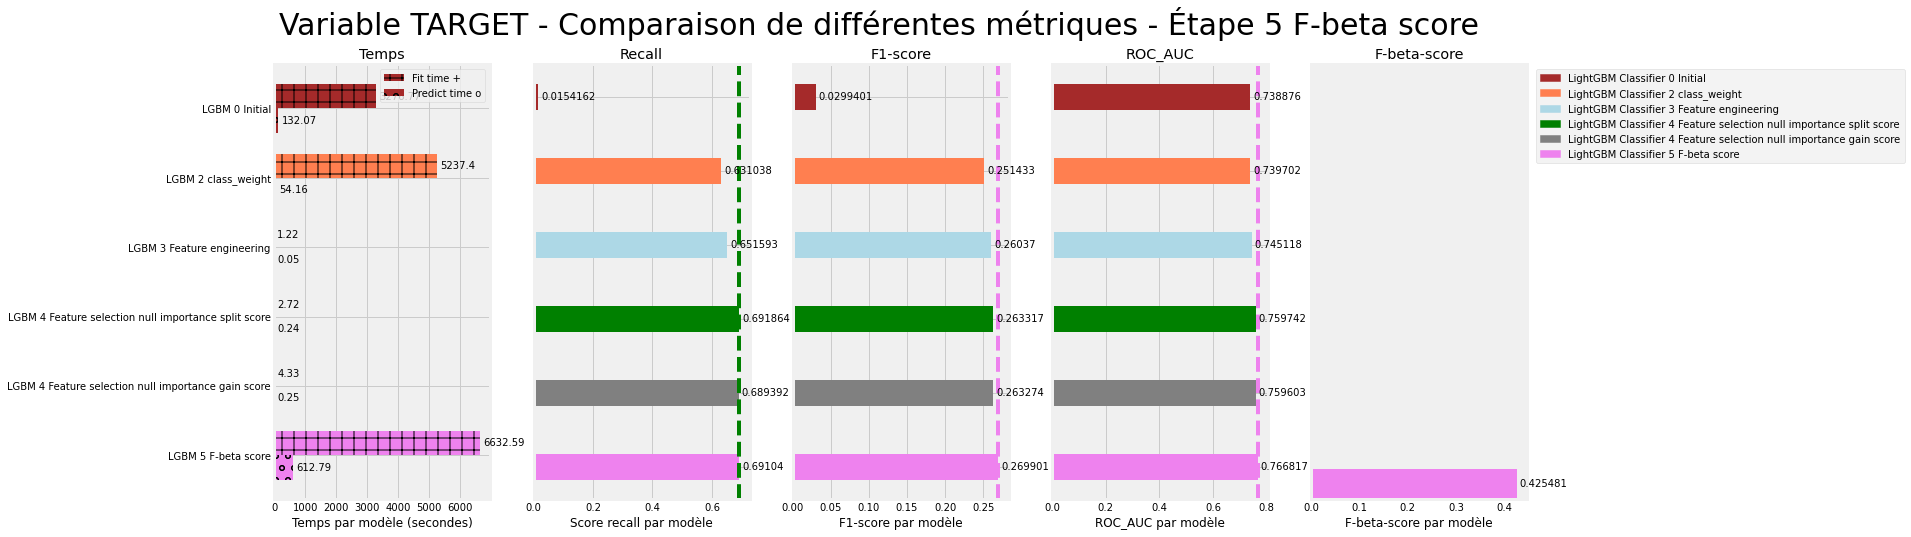

In [196]:
df_scores_lgbm = df_scores_updated.loc[df_scores_updated['Model'] == 'LightGBM Classifier'].reset_index(drop=True)

colors = []
for index, classifier_name in enumerate(df_scores_lgbm['Model']):
    colors.append(colors_arr[index])
colors

patches = []
for model, step, color in zip(df_scores_lgbm['Model'], df_scores_lgbm['Step'], colors):
    patches.append(mpatches.Patch(color=color, label=model + ' ' + step))

yticklabels = 'LGBM ' + df_scores_lgbm['Step']
    
displayTimesScoresComparisonForVariableUpdated('TARGET', df_scores_lgbm, colors, patches, yticklabels, step, step)

# Rechercher le seuil de décision le plus adapté par rapport à la métrique métier

- Calculer la métrique métier pour un ensemble de seuil de décision (entre 0 et 1)
- Faire une courbe pour mesurer l'évolution de la métrique métier en fonction du seuil
- Choisir un seuil permettant de maximiser le critère métier

In [197]:
best_model = classifiers_cv_results_fbeta['best_estimator']

# Prédictions sur les variables de test
# Now that the model has been trained, we can use it to make predictions.
# We want to predict the probabilities of not paying a loan, so we use the model predict.proba method.
# This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1).
# We want the probability the loan is not repaid, so we will select the second column.
y_train_proba = best_model.predict_proba(X_scaled)[:, 1]

In [198]:
y_pred_proba = df_scores_fbeta.loc[0, 'predictions']

In [199]:
# apply threshold to positive probabilities to create labels
def apply_threshold(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [200]:
beta_ratio=2

# define thresholds
thresholds = np.arange(0.2, 0.6, 0.001)

# evaluate each threshold
scores = [fbeta_score(y_train, apply_threshold(y_train_proba, t), beta=beta_ratio) for t in thresholds]

# get best threshold
ix = np.argmax(scores)
best_threshold = thresholds[ix]
best_score = scores[ix]
print('Train base : Threshold=%.3f, F-beta Score=%.5f' % (best_threshold, best_score))

Train base : Threshold=0.504, F-beta Score=0.44632


In [201]:
# # define thresholds
# thresholds = np.arange(0.2, 0.6, 0.001)

# # define betas
# betas = np.arange(2, 6, 0.01)
# # betas = [2, 2.5, 3, 5] # for testing purposes
# only_10_curves_modulo = len(betas) / 10

# plt.figure(figsize = (20, 16))

# best_beta, best_threshold, best_score = betas[0], None, 0
# for count, beta_ratio in enumerate(betas):
#     # evaluate each threshold
#     scores = [fbeta_score(y_test, apply_threshold(y_pred_proba, t), beta=beta_ratio) for t in thresholds]

#     # get best threshold
#     ix = np.argmax(scores)
#     print('Beta=%.3f, Threshold=%.3f, F-beta-score=%.5f' % (beta_ratio, thresholds[ix], scores[ix]))
    
#     if scores[ix] > best_score:
#         best_score = scores[ix]
#         best_threshold = thresholds[ix]
#         best_beta = beta_ratio
        
#     if count % only_10_curves_modulo == 0:
#         # plot only 10 curves
#         plt.plot(thresholds, scores, linestyle='--', label='Beta ' + str(beta_ratio))
#         plt.scatter(thresholds[ix], scores[ix], marker='o', color='black', zorder=2.5) #, label='Best Beta ' + str(beta_ratio))

# # plot best curve
# plt.plot(thresholds, scores, label='Best Beta {}'.format(best_beta))
# plt.scatter(thresholds[ix], scores[ix], marker='+', color='black', label='Best threshold {}'.format(best_threshold), zorder=2.5)
        
# # Labeling of plot
# plt.xlabel('Thresholds (0 < t < 1)'); plt.ylabel('Scores (0 < t < 1)'); plt.title('Scores F-beta en fonction de beta et du threshold');
# plt.legend(loc = 'lower right')
# # show the plot
# plt.show()

In [202]:
step = '6 beta {} threshold {}'.format(beta_ratio, best_threshold)
model_name = 'LightGBM Classifier'

# if prediction is 0.5, client has same chance of repaying than defaulting the loan
# from bank perspective, it's better not to take the chance to lose money, so don't loan = class 1
# if pred < threshold, class 0 the loan was repaid on time
# else pred >= threshold, class 1 the client had payment difficulties
y_pred_binarized = np.where(np.array(y_pred_proba) >= best_threshold, 1, 0)

# calculate recall : tp / (tp + fn)
recall = recall_score(y_test, y_pred_binarized)

# calculate F1 score : 2 * (precision * recall) / (precision + recall)
f1 = f1_score(y_test, y_pred_binarized)

# calculate ROC_AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# calculate F-beta score
score_test_fbeta = fbeta_score(y_test, y_pred_binarized, beta=beta_ratio)

print('\nStep: \t\t\t', step,
        '\nModel: \t\t\t', model_name,
        '\nbest_params: \t\t', classifiers_cv_results_fbeta['best_estimator'].get_params(),
        '\nRecall: \t\t', "{:.4f}".format(recall),
        '\nF1 score: \t\t', "{:.4f}".format(f1),
        '\nROC_AUC: \t\t', "{:.4f}".format(roc_auc),
        '\n\nF-beta: \t\t', "{:.4f}".format(score_test_fbeta),
        '\nbeta: \t\t', beta_ratio,
        '\nbest_threshold: \t', best_threshold,        
        # '\nExecution time: \t', "{:.4f}s".format(execution_time), "({:}m ".format(int(execution_time / 60)), "{:.2f}s)".format(round((execution_time - (60 * int(execution_time / 60))) % 60, 2)),
        # '\nMean fit time: \t', "{:.2f}s".format(mean_fit_time), "({:}m ".format(int(mean_fit_time / 60)), "{:.2f}s)".format(round((mean_fit_time - (60 * int(mean_fit_time / 60))) % 60, 2)),
        # '\nMean score time: ', "{:.2f}s".format(mean_score_time), "({:}m ".format(int(mean_score_time / 60)), "{:.2f}s)".format(round((mean_score_time - (60 * int(mean_score_time / 60))) % 60, 2)),
        '\n')

print('\n', confusion_matrix(y_test, y_pred_binarized))
print('\n', classification_report(y_test, y_pred_binarized))

# add new row to end of DataFrame
df_scores_fbeta.loc[len(df_scores_fbeta.index)] = [step, model_name, df_scores_fbeta.loc[0, 'best_params'], recall, f1, roc_auc, score_test_fbeta, df_scores_fbeta.loc[0, 'execution_time'], df_scores_fbeta.loc[0, 'mean_fit_time'], df_scores_fbeta.loc[0, 'mean_score_time'], df_scores_fbeta.loc[0, 'predictions']]


Step: 			 6 beta 2 threshold 0.5040000000000002 
Model: 			 LightGBM Classifier 
best_params: 		 {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.07, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.1, 'reg_lambda': 0.0005623413251903491, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Recall: 		 0.6849 
F1 score: 		 0.2712 
ROC_AUC: 		 0.7668 

F-beta: 		 0.4253 
beta: 		 2 
best_threshold: 	 0.5040000000000002 


 [[40307 16341]
 [ 1530  3325]]

               precision    recall  f1-score   support

           0       0.96      0.71      0.82     56648
           1       0.17      0.68      0.27      4855

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.54     61503
weighte

In [203]:
df_scores_fbeta

Step                Model  \
0                         5 F-beta score  LightGBM Classifier   
1  6 beta 2 threshold 0.5040000000000002  LightGBM Classifier   

                                         best_params    recall  F1-score  \
0  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.691040  0.269901   
1  {'boosting_type': 'gbdt', 'class_weight': 'bal...  0.684861  0.271196   

    ROC_AUC  F-beta-score  execution_time  mean_fit_time  mean_score_time  \
0  0.766817      0.425481     1223.490538        6632.59           612.79   
1  0.766817      0.425344     1223.490538        6632.59           612.79   

                                         predictions  
0  [0.837636236452578, 0.3069489577327195, 0.3653...  
1  [0.837636236452578, 0.3069489577327195, 0.3653...

Comparaison des temps d'entraînement et de prédictions et des scores Recall/F1/ROC_AUC/F-beta par modèles pour la variable TARGET à l'étape 6 beta threshold


<Figure size 1440x864 with 0 Axes>

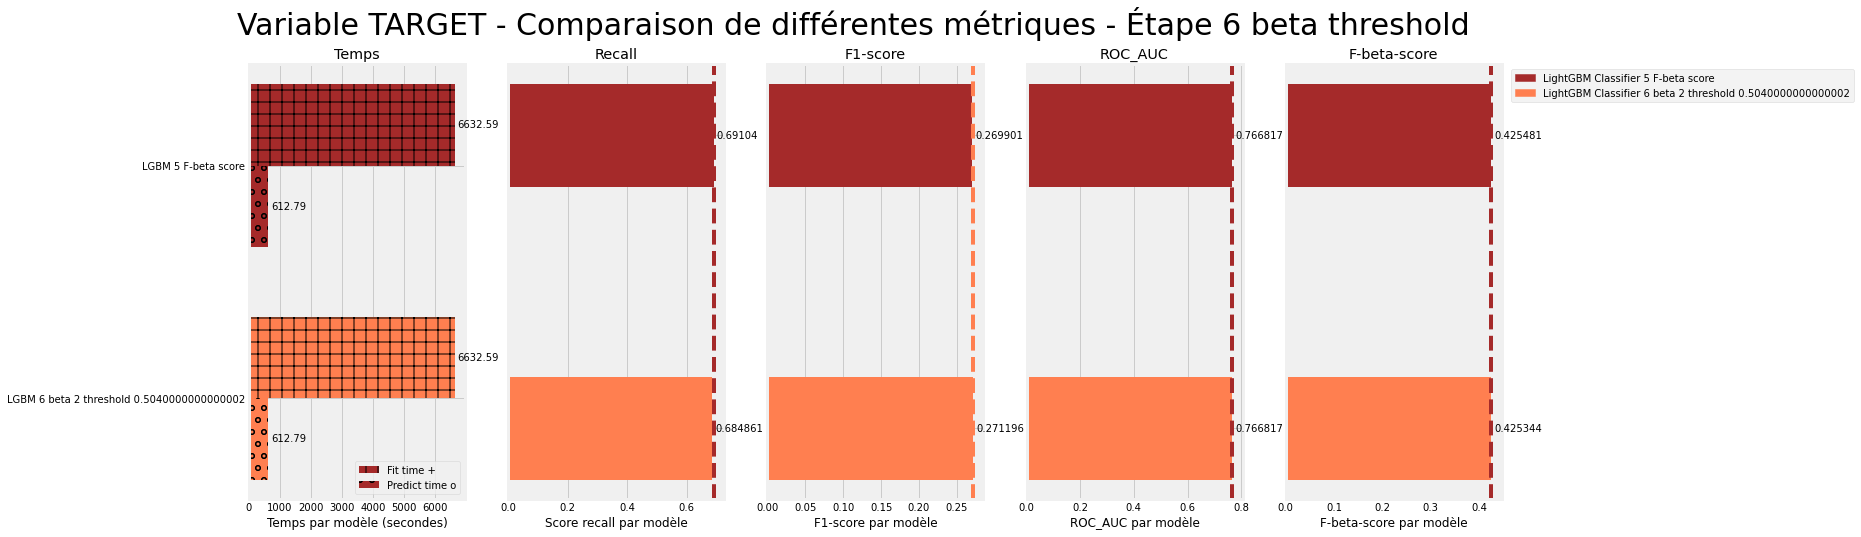

In [204]:
colors = []
for index, classifier_name in enumerate(df_scores_fbeta['Model']):
    colors.append(colors_arr[index])
colors

patches = []
for model, step, color in zip(df_scores_fbeta['Model'], df_scores_fbeta['Step'], colors):
    patches.append(mpatches.Patch(color=color, label=model + ' ' + step))

yticklabels = 'LGBM ' + df_scores_fbeta['Step']
    
displayTimesScoresComparisonForVariableUpdated('TARGET', df_scores_fbeta, colors, patches, yticklabels, '6 beta threshold', '6 beta threshold')

L'augmentation du beta de la fonction de scoring F-beta entraîne une amélioration du score F-beta et du recall, une stagnation de ROC_AUC et une diminution du F1-score.

# Interprétation du modèle

- Interpréter l'importance des variables pour les meilleures modèles (coefficients de régression, feature importance pour les arbres, librairie SHAP/LIME si modèle complexe)
- Graphiques Shap :
    - feature importance
    - force plot
    - summary plot
- https://www.aquiladata.fr/insights/shap-mieux-comprendre-linterpretation-de-modeles/
- https://www.kaggle.com/cast42/lightgbm-model-explained-by-shap

In [205]:
# import sys
# !{sys.executable} -m pip install shap

In [206]:
import shap
shap.initjs()

## Préparation des données

In [207]:
data_display = pd.read_csv('data/application_train.csv')

categorical_feats = [
    f for f in data_display.columns if data_display[f].dtype == 'object'
]

categorical_feats
for f_ in categorical_feats:
    # data_display[f_], _ = pd.factorize(data_display[f_])
    # Set feature type as categorical
    data_display[f_] = data_display[f_].astype('category')

In [208]:
data_display['CREDIT_INCOME_PERCENT'] = data_display['AMT_CREDIT'] / data_display['AMT_INCOME_TOTAL']
data_display['ANNUITY_INCOME_PERCENT'] = data_display['AMT_ANNUITY'] / data_display['AMT_INCOME_TOTAL']
data_display['CREDIT_TERM'] = data_display['AMT_ANNUITY'] / data_display['AMT_CREDIT']
data_display['DAYS_EMPLOYED_PERCENT'] = data_display['DAYS_EMPLOYED'] / data_display['DAYS_BIRTH']

In [209]:
# Feature selection par null importance : par split_score supérieur à 0
columns_feature_importance_split_score = keepOnlyFeaturesWithImportanceAboveThreshold(corr_scores_df, 'split_score', 0)
column_names = ['TARGET', 'SK_ID_CURR'] + columns_feature_importance_split_score

# Données à traiter
features = data[column_names]
    
# Target
target = features['TARGET']
print('\nTarget: \t', target.shape)

features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])
print('Features: \t', features.shape)

50 Features having "split_score" above "0"
           feature  split_score  gain_score
0       AMT_CREDIT        100.0       100.0
1  AMT_GOODS_PRICE        100.0       100.0
2      CODE_GENDER        100.0       100.0
3      CREDIT_TERM        100.0       100.0
4       DAYS_BIRTH        100.0       100.0

Target: 	 (307511,)
Features: 	 (307511, 50)


In [210]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(features)

In [211]:
# %time shap_values = shap.TreeExplainer(best_model).shap_values(X_scaled)

In [212]:
# shap_values

## Explication d’impact des variables pour des exemples du dataset

In [213]:
target[:2]

0    1
1    0
Name: TARGET, dtype: int64

In [214]:
y_pred_binarized[:2]

array([1, 0])

Le client d'index 0 ne rembourse pas son crédit (TARGET = 1).

In [215]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], features.iloc[0,:])

Le client d'index 1 rembourse son crédit (TARGET = 0).

In [216]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], features.iloc[1,:])

In [217]:
df_application_train.head(2)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002       1                   0             0                1   
1      100003       0                   0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   

   ...  WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0  ...                         0                         0   
1  ...                         1                         0   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                              0                          0   
1                              0                          0   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                         0                                1   
1                         0                                0   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  \
0                          0                       1                        0   
1                          0                       1                        0   

   DAYS_EMPLOYED_ANOM  
0               False  
1               False  

[2 rows x 244 columns]

En rouge, les variables qui ont un impact positif (contribuent à ce que la prédiction soit plus élevée que la valeur de base) et en bleu celles ayant un impact négatif (contribuent à ce que la prédiction soit plus basse que la valeur de base).

Pour rappel dans notre cas, la TARGET 1 signifie que le client d'index 0 ne rembourse pas son crédit. Ici, on constate que:
- la valeur du crédit, l'occupation_type etc ... influe sur le refus du crédit,
- l'AMT_GOODS_PRICE, DAYS_EMPLOPYED ... influe sur l'acceptation du crédit,
- plus de valeurs tendent vers le refus.

Pour rappel dans notre cas, la TARGET 0 signifie que le client d'index 1 rembourse son crédit. Ici, on constate que:
- la valeur du crédit, l'occupation_type etc ... influe sur le refus du crédit,
- l'AMT_GOODS_PRICE, DAYS_EMPLOPYED, EXT_SOURCE_2 ... influe sur l'acceptation du crédit,
- plus de valeurs tendent vers l'acceptation.

In [218]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:10,:], features.iloc[:10,:])

## Importance globale des variables en utilisant les valeurs de Shap

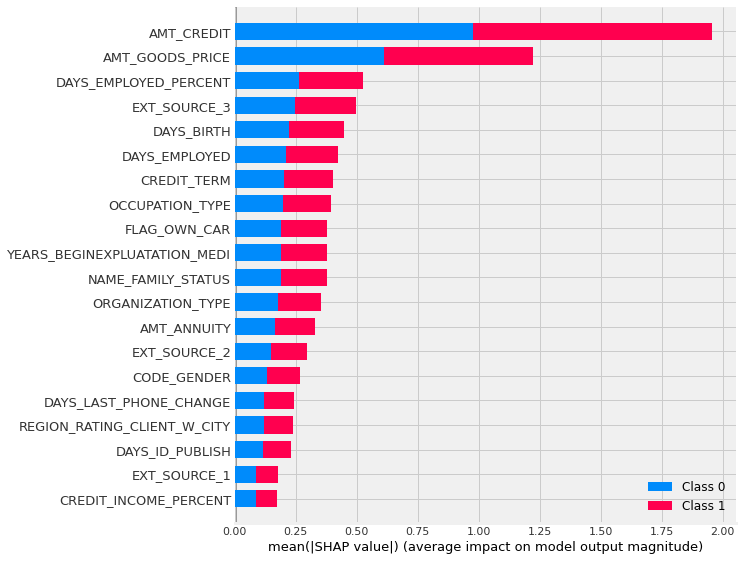

In [219]:
shap.summary_plot(shap_values, features)

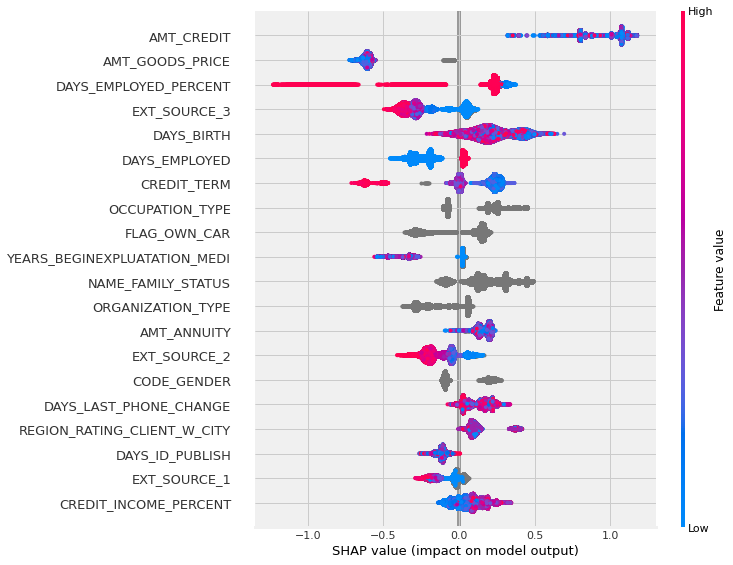

In [220]:
shap.summary_plot(shap_values[1], features)

Les valeurs de Shap sont représentées pour chaque variable dans leur ordre d’importance, chaque point représente une valeur de Shap (pour un exemple), les points rouges représentent des valeurs élevées de la variable et les points bleus des valeurs basses de la variable.
Grâce au fait que les valeurs sont calculées pour chaque exemple du dataset, il est possible de représenter chaque exemple par un point et ainsi avoir une information supplémentaire sur l’impact de la variable en fonction de sa valeur. Par exemple EXT_SOURCE_3 qui est une des variables les plus importantes a un impact négatif quand la valeur de cette variable est élevée (les valeurs rouges sont dans l'axe négatif).

TreeExplainer de Shap permet d’accéder avec un temps de calcul raisonnable à une approximation des valeurs de Shapley dans le cas de modèles d’arbre de décision ou d’ensembles d’arbres. Par cette approche, il est possible de calculer l’importance globale des variables mais surtout les effets des variables pour chaque exemple du dataset. J'ai pu expliqué grâce au modèle Shap l’importance des variables au niveau global du modèle mais aussi pour chaque exemple spécifique du modèle.

J'ai ainsi pu comparer deux clients avec refus/acceptation de crédit selon le modèle et j'ai montré que les raisons pour lesquelles le modèle a attribué ou non le crédit au client sont différentes.